In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tabulate import tabulate
import numpy as np
from pycaret.classification import *
from IPython.display import display, HTML
from matplotlib.colors import LinearSegmentedColormap  # Certifique-se de importar este módulo
import shap
from sklearn.preprocessing import LabelEncoder

In [2]:
# Ajustar configurações de exibição do Pandas
pd.set_option('display.max_columns', None)  # Exibir todas as colunas
pd.set_option('display.max_colwidth', 200)  # Ajustar a largura máxima das colunas
pd.set_option('display.width', 2000)  # Ajustar a largura total da exibição
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

In [3]:
# Tenho q substituir pelo banco de dados e não ".csv"
# Caminho completo para o arquivo CSV
caminho_arquivo = r'E:\OneDrive\Documentos\Roger\Projetos\ES\Banco_Brasil\Modelo_Renda\query-hive-136468.csv'


In [4]:
# Carregando o arquivo CSV em um DataFrame do pandas
df = pd.read_csv(caminho_arquivo)

In [5]:
# Agora você pode usar o DataFrame (df) para manipular e analisar os dados
display(HTML(df.head(10).to_html()))  # Exemplo: exibe as primeiras linhas do DataFrame

In [6]:
# Listar as variáveis (nomes das colunas)
variaveis = df.columns.tolist()

# Exibir a lista de variáveis
print("Variáveis no banco de dados:")
for var in variaveis:
    print(var)

Variáveis no banco de dados:
dados_brutos_amostra.cd_cli
dados_brutos_amostra.cpf
dados_brutos_amostra.ts_protocolo
dados_brutos_amostra.y
dados_brutos_amostra.renda_analisada
dados_brutos_amostra.recebe_salario
dados_brutos_amostra.total_investimento
dados_brutos_amostra.carteira_principal
dados_brutos_amostra.vlr_bens
dados_brutos_amostra.tempo_relacionamento_anos
dados_brutos_amostra.idade_anos
dados_brutos_amostra.cod_grau_inst
dados_brutos_amostra.anotacao_externa
dados_brutos_amostra.anotacao_interna
dados_brutos_amostra.anotacao_principal
dados_brutos_amostra.qt_opr
dados_brutos_amostra.vl_limite_credito
dados_brutos_amostra.outros
dados_brutos_amostra.dirigente
dados_brutos_amostra.agricultor
dados_brutos_amostra.estudantes
dados_brutos_amostra.aposentado
dados_brutos_amostra.sem_atividade
dados_brutos_amostra.servidor_publico
dados_brutos_amostra.iniciativa_privada
dados_brutos_amostra.segmento
dados_brutos_amostra.mediana_total_saldo
dados_brutos_amostra.vl_ren_pres
dados_bru

In [7]:
# Remover o prefixo 'dados_brutos_amostra.' das colunas.. 
#acredito não precisar rodar uma vez q vamos conectar no banco diretamente
df.columns = [col.replace('dados_brutos_amostra.', '') for col in df.columns]

# Exibindo o DataFrame para verificar a mudança
display(HTML(df.head(10).to_html()))

In [8]:
# Calculando o número de valores únicos
num_valores_unicos = df.nunique()

# Criar DataFrame para exibição
num_valores_unicos_df = pd.DataFrame(num_valores_unicos, columns=['Número de Valores Únicos'])

# Exibir DataFrame como HTML
display(HTML(num_valores_unicos_df.to_html()))

In [9]:
# Verificando duplicidades combinadas nas colunas 'cd_cli', 'cpf' e 'ts_protocolo'
duplicados_combinados = df.duplicated(subset=['cd_cli', 'cpf', 'ts_protocolo']).sum()

# Removendo duplicatas considerando todas as colunas
df_sem_duplicatas = df.drop_duplicates(subset=['cd_cli', 'cpf', 'ts_protocolo'])

# Verificando se as duplicatas foram removidas
duplicados_restantes = df_sem_duplicatas.duplicated(subset=['cd_cli', 'cpf', 'ts_protocolo']).sum()

# Criar um DataFrame para exibir informações sobre duplicidade
info_duplicidade = pd.DataFrame({
    'Descrição': ['Duplicados combinados', 'Duplicados restantes após a remoção'],
    'Quantidade': [duplicados_combinados, duplicados_restantes]
})

# Exibir informações sobre duplicidade em HTML
display(HTML(info_duplicidade.to_html(index=False, header=True, table_id="info_duplicidade", border=0)))

# Exibir as 5 primeiras e 5 últimas linhas do DataFrame sem duplicatas
primeiras_linhas = df_sem_duplicatas.head(5)

display(HTML(primeiras_linhas.to_html(index=False, header=True, table_id="primeiras_linhas", border=0)))


In [10]:
# Verificar o tamanho do DataFrame
num_linhas, num_colunas = df_sem_duplicatas.shape

print(f"O DataFrame possui {num_linhas} linhas e {num_colunas} colunas.")

O DataFrame possui 20365 linhas e 33 colunas.


In [11]:
# Alternativamente, se quiser remover linhas com qualquer valor missing
df_cleaned_all = df_sem_duplicatas.dropna()

print("\nDataFrame após remover casos onde qualquer variável está missing:")


DataFrame após remover casos onde qualquer variável está missing:


In [12]:
# Fazer uma cópia..
df_inicial = df_cleaned_all.copy()

In [13]:
# Verificar o tamanho do DataFrame
num_linhas, num_colunas = df_inicial.shape

print(f"O DataFrame possui {num_linhas} linhas e {num_colunas} colunas.")

O DataFrame possui 20315 linhas e 33 colunas.


## Análise Descritiva --- versus TARGET

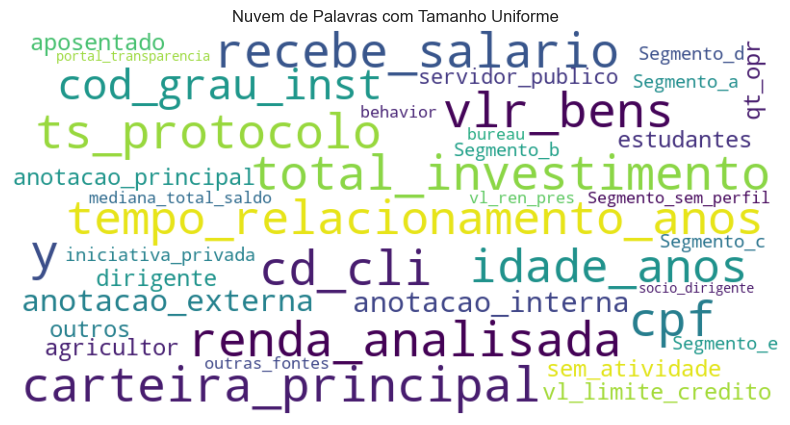

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Lista de palavras fornecida
words = [
    'cd_cli', 'cpf', 'ts_protocolo', 'y', 'renda_analisada', 'recebe_salario', 
    'total_investimento', 'carteira_principal', 'vlr_bens', 'tempo_relacionamento_anos', 
    'idade_anos', 'cod_grau_inst', 'anotacao_externa', 'anotacao_interna', 
    'anotacao_principal', 'qt_opr', 'vl_limite_credito', 'outros', 'dirigente', 
    'agricultor', 'estudantes', 'aposentado', 'sem_atividade', 'servidor_publico', 
    'iniciativa_privada', 'Segmento_a', 'Segmento_b', 'Segmento_c', 'Segmento_d', 'Segmento_e', 'Segmento_sem_perfil', 
    'mediana_total_saldo', 'vl_ren_pres', 'outras_fontes', 'bureau', 'behavior', 
    'portal_transparencia', 'socio_dirigente'
]

# Criar um texto com cada palavra aparecendo um número igual de vezes
# Aqui, todas as palavras têm o mesmo peso
text = ' '.join(words)

# Gerar a nuvem de palavras com tamanho uniforme
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      max_font_size=50, min_font_size=10).generate(text)

# Plotar a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Não mostrar os eixos
plt.title('Nuvem de Palavras com Tamanho Uniforme')
plt.show()

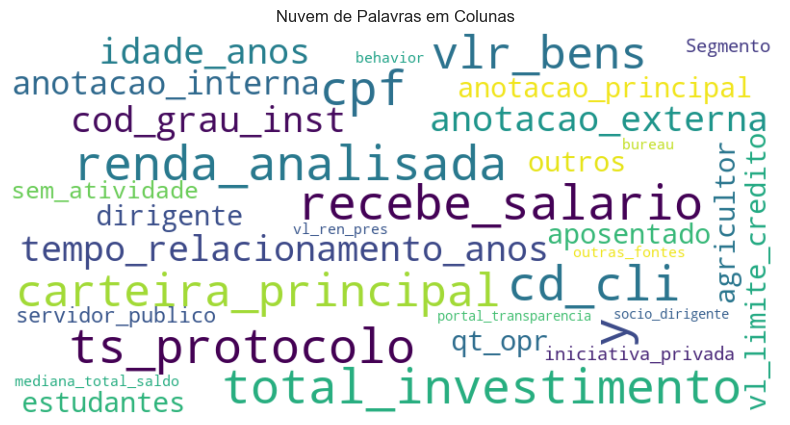

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Lista de palavras fornecida
words = [
    'cd_cli', 
    'cpf', 
    'ts_protocolo', 
    'y', 
    'renda_analisada', 
    'recebe_salario', 
    'total_investimento', 
    'carteira_principal', 
    'vlr_bens', 
    'tempo_relacionamento_anos', 
    'idade_anos', 
    'cod_grau_inst', 
    'anotacao_externa', 
    'anotacao_interna', 
    'anotacao_principal', 
    'qt_opr', 
    'vl_limite_credito', 
    'outros', 
    'dirigente', 
    'agricultor', 
    'estudantes', 
    'aposentado', 
    'sem_atividade', 
    'servidor_publico', 
    'iniciativa_privada', 
    'Segmento', 
    'mediana_total_saldo', 
    'vl_ren_pres', 
    'outras_fontes', 
    'bureau', 
    'behavior', 
    'portal_transparencia', 
    'socio_dirigente'
]

# Dividir as palavras em colunas com 5 palavras cada
num_per_col = 1
columns = [words[i:i + num_per_col] for i in range(0, len(words), num_per_col)]

# Transformar colunas em texto
text = ''
for col in zip(*columns):
    text += ' '.join(col) + ' '
# Adicionando palavras restantes se houver
remaining_words = len(words) % num_per_col
if remaining_words:
    for word in words[-remaining_words:]:
        text += word + ' '

# Gerar a nuvem de palavras com tamanho uniforme
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      max_font_size=50, min_font_size=10, relative_scaling=0).generate(text)

# Plotar a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Não mostrar os eixos
plt.title('Nuvem de Palavras em Colunas')
plt.show()

In [16]:
cruzamento = pd.crosstab(df_inicial['dirigente'], df_inicial['socio_dirigente'])

# Exibir a matriz de cruzamento
display(cruzamento)

socio_dirigente     0     1
dirigente                  
0                9365  3740
1                 907  6303

In [17]:
df_inicial['Ocupacao_dirigente'] = (df_inicial['dirigente'] == df_inicial['socio_dirigente']).astype(int)
frequencia_ocupacao = df_inicial['Ocupacao_dirigente'].value_counts()

# Exibir a tabela de frequência
display(frequencia_ocupacao)

Ocupacao_dirigente
1    15668
0     4647
Name: count, dtype: int64

In [18]:
df_inicial

cd_cli           cpf                ts_protocolo  y  renda_analisada  recebe_salario  total_investimento  carteira_principal    vlr_bens  tempo_relacionamento_anos  idade_anos  cod_grau_inst  anotacao_externa  anotacao_interna  anotacao_principal  qt_opr  vl_limite_credito  outros  dirigente  agricultor  estudantes  aposentado  sem_atividade  servidor_publico  iniciativa_privada  segmento  mediana_total_saldo  vl_ren_pres  outras_fontes  bureau  behavior  portal_transparencia  socio_dirigente  Ocupacao_dirigente
0         228290  6.755155e+10  2024-07-19 15:35:48.309949  1         61901.93               0                0.00                16.0   473050.00                         34        56.0            2.0                 0                 1                   1      27               0.00       0          0           1           0           0              0                 0                   0    2112.0            11797.500       5800.0              1       0         0                     0                0                   1
1         316506  6.796962e+10  2024-07-24 17:47:22.626552  1         44839.01               0                0.00                56.0        0.00                         33        52.0            5.0                 1                 1                   2      77               0.00       0          1           0           0           0              0                 0                   0    2112.0             4710.000      48750.0              1       0         0                     0                0                   0
2         651566  5.368891e+08  2024-07-22 13:49:44.413721  1         60501.60               0                0.00                10.0        0.00                         28        38.0            5.0                 2                 1                   3     798          627000.00       0          1           0           0           0              0                 0                   0    2112.0             5500.000      53100.0              1       0         0                     0                1                   1
3        1516620  7.602559e+10   2024-07-24 10:49:32.31193  0         40180.28               0                0.00                63.0  1257311.00                         28        52.0            2.0                 0                 1                   1      15           51802.00       0          1           0           0           0              0                 0                   0    2702.0                0.000     150000.0              1       0         0                     0                1                   1
4       30711137  7.081897e+10  2024-07-23 13:02:58.092134  1         43942.47               0                0.00                10.0   247408.11                         19        42.0            3.0                 0                 1                   1      37               0.00       0          0           0           0           0              0                 1                   0    2112.0                0.000      39600.0              1       0         0                     0                0                   1
...          ...           ...                         ... ..              ...             ...                 ...                 ...         ...                        ...         ...            ...               ...               ...                 ...     ...                ...     ...        ...         ...         ...         ...            ...               ...                 ...       ...                  ...          ...            ...     ...       ...                   ...              ...                 ...
20360  931103084  6.110121e+08  2024-07-23 17:58:12.177562  1         29166.67               0             1440.97                10.0        0.00                         20        39.0            3.0                 1                 1                   2     208               0.00       0          1           0

In [19]:
# Criar uma nova coluna 'TARGET' com o mesmo conteúdo da coluna 'y'
df_inicial['TARGET'] = df_inicial['y']

# Exibir as primeiras linhas do DataFrame com a nova coluna em HTML
display(HTML(df_inicial.head(10).to_html(index=False, table_id="df_inicial", border=0)))

pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.max_colwidth', None)  # Mostrar todo o conteúdo das colunas

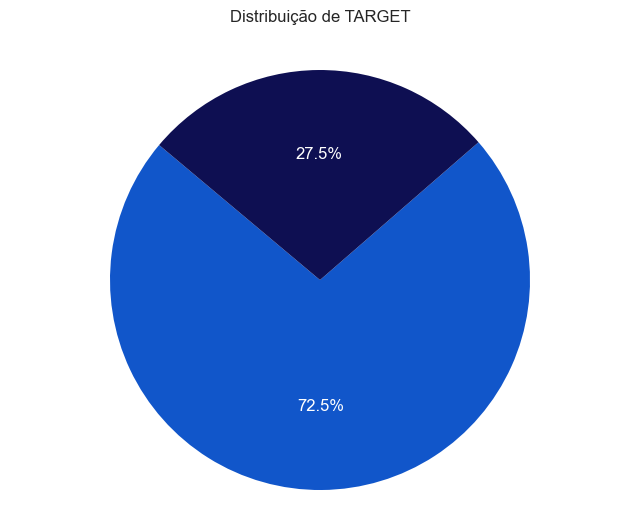

In [20]:
# Criar a tabela de frequência
freq_table = df_inicial['TARGET'].value_counts().reset_index()
freq_table.columns = ['TARGET', 'Frequency']

# Mapear os valores de TARGET para rótulos descritivos
target_labels = {1: 'Liberada', 0: 'Não liberada'}
freq_table['TARGET'] = freq_table['TARGET'].map(target_labels)

# Calcular a porcentagem
freq_table['Percentage'] = (freq_table['Frequency'] / freq_table['Frequency'].sum()) * 100

# Formatando a coluna de porcentagem para exibir duas casas decimais
freq_table['Percentage'] = freq_table['Percentage'].map('{:.2f}'.format)

# Adicionar uma linha de total
total = pd.DataFrame({'TARGET': ['Total'], 
                      'Frequency': [freq_table['Frequency'].sum()], 
                      'Percentage': ['100.00']})
freq_table = pd.concat([freq_table, total], ignore_index=True)

# Converter a tabela para HTML
html_table = freq_table.to_html(index=False, justify='center')

# Exibir a tabela HTML no Jupyter Notebook
display(HTML(html_table))

# Definir as cores para cada segmento
colors = ['#1156ca', '#0e0f52']

# Função para mudar a cor do texto para branco
def func(pct):
    return f'{pct:.1f}%' if pct > 0 else ''

# Criar o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(freq_table['Frequency'][:-1], labels=freq_table['TARGET'][:-1], autopct=lambda pct: func(pct), startangle=140, colors=colors, textprops={'color':'white'})
plt.title('Distribuição de TARGET', pad=20)  # Ajuste do espaçamento do título
plt.axis('equal')  # Assegura que o gráfico de pizza seja desenhado como um círculo.

# Exibir o gráfico de pizza
plt.show()

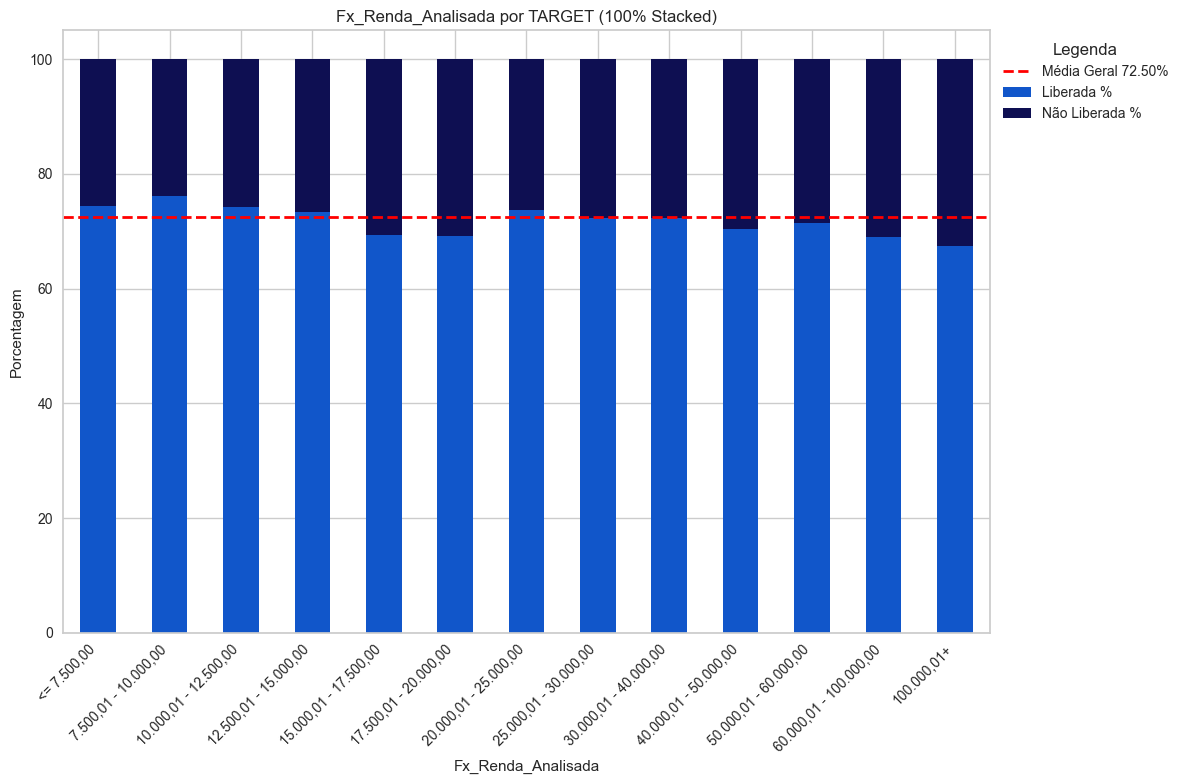

In [21]:
# Definindo os intervalos e as etiquetas
bins = [-float('inf'), 7500, 10000, 12500, 15000, 17500, 20000, 25000, 30000, 40000, 50000, 60000, 100000, float('inf')]
labels = [
    '<= 7.500,00', '7.500,01 - 10.000,00', '10.000,01 - 12.500,00', '12.500,01 - 15.000,00',
    '15.000,01 - 17.500,00', '17.500,01 - 20.000,00', '20.000,01 - 25.000,00', '25.000,01 - 30.000,00',
    '30.000,01 - 40.000,00', '40.000,01 - 50.000,00', '50.000,01 - 60.000,00', '60.000,01 - 100.000,00', '100.000,01+'
]

# Aplicando a categorização
df_inicial['Fx_Renda_Analisada'] = pd.cut(df_inicial['renda_analisada'], bins=bins, labels=labels)

# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['Fx_Renda_Analisada'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'Fx_Renda_Analisada'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['Fx_Renda_Analisada', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['Fx_Renda_Analisada'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('Fx_Renda_Analisada')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('Fx_Renda_Analisada por TARGET (100% Stacked)')
plt.xlabel('Fx_Renda_Analisada')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()


# Calculando as estatísticas
renda_analisada = df_inicial['renda_analisada'].dropna()
n = len(renda_analisada)
min_val = np.min(renda_analisada)
max_val = np.max(renda_analisada)
mean = np.mean(renda_analisada)
stddev = np.std(renda_analisada)

# Criando um DataFrame para as estatísticas
stats = pd.DataFrame({
    'Estatística': ['N', 'Mínimo', 'Máximo', 'Média', 'Desvio Padrão'],
    'Valor': [n, min_val, max_val, mean, stddev]
})

# Arredondando os valores para 2 casas decimais e formatando com pontos de milhares e vírgulas para decimais
stats['Valor'] = stats['Valor'].round(2).apply(lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Converter DataFrame para HTML
html_stats = stats.to_html(classes='table table-striped table-bordered', index=False)

# Exibir a tabela HTML no Jupyter Notebook
display(HTML(html_stats))

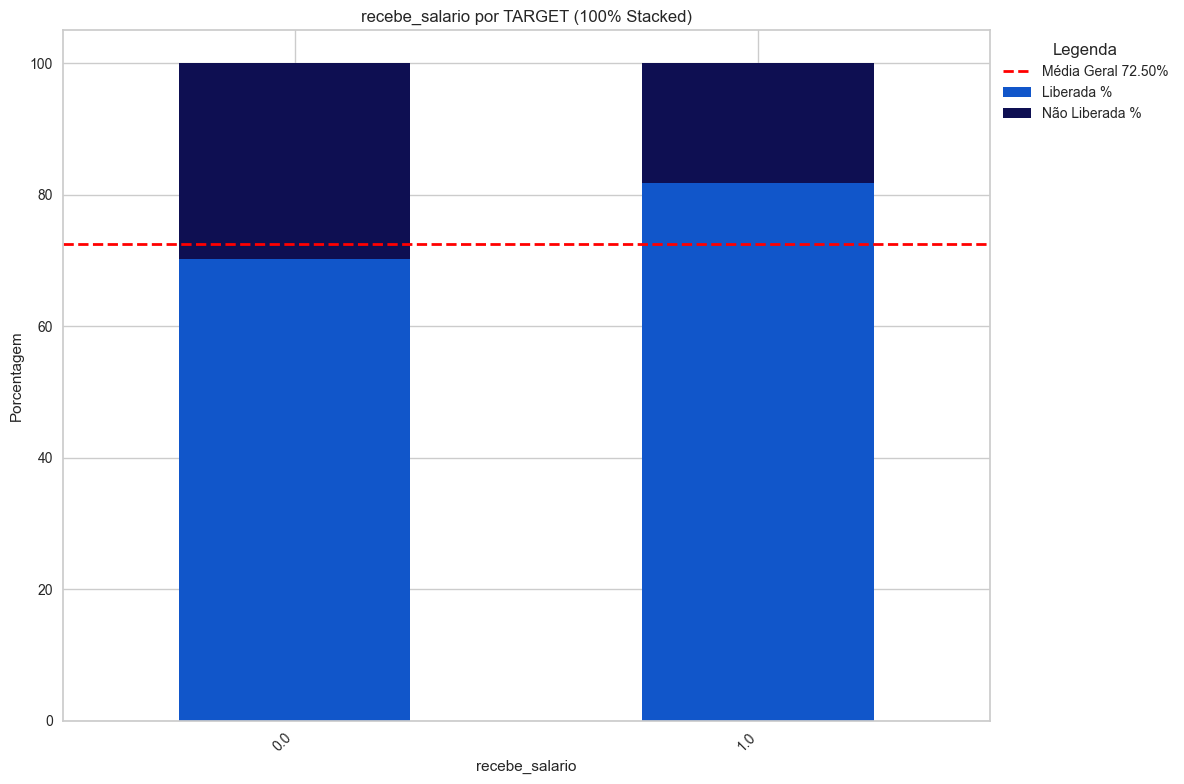

In [22]:
# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['recebe_salario'], df_inicial['TARGET'], margins=True)

recebe_salario = {0: '0 - Não', 1: '1 - Sim'}

df_inicial['recebe_salario'] = df_inicial['recebe_salario'].map(recebe_salario)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'recebe_salario'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['recebe_salario', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha


# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['recebe_salario'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('recebe_salario')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('recebe_salario por TARGET (100% Stacked)')
plt.xlabel('recebe_salario')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

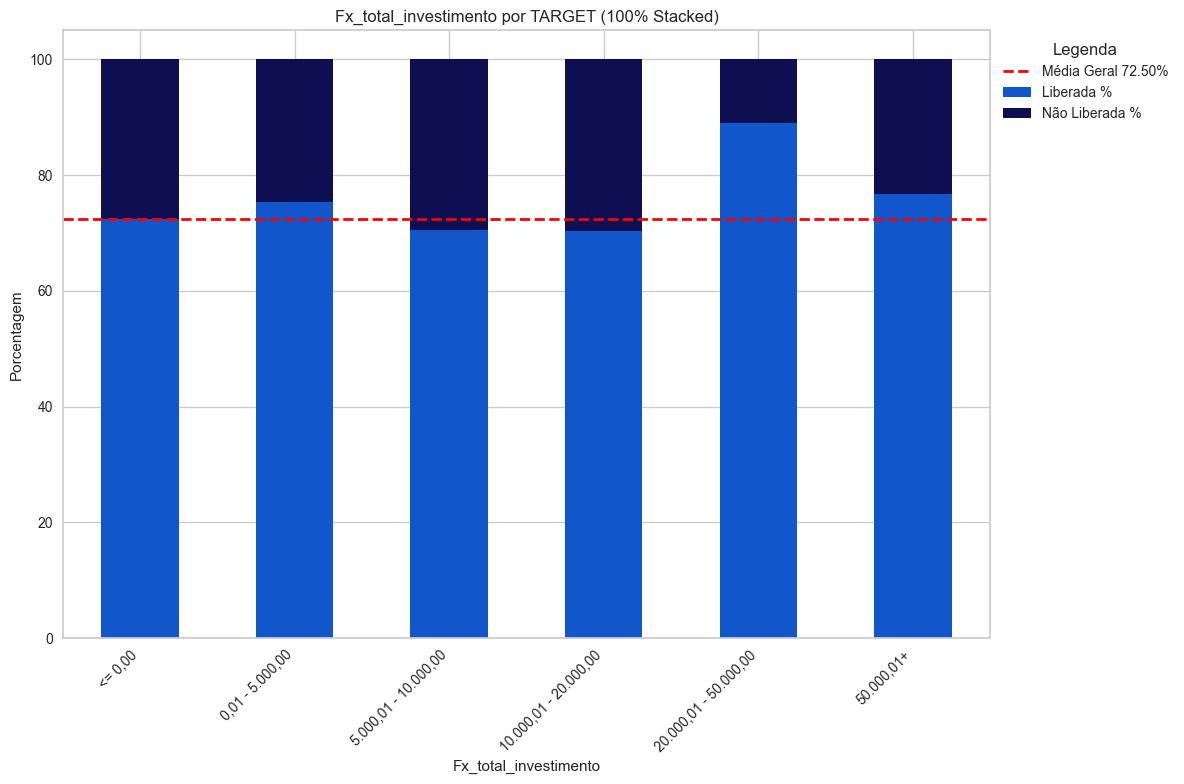

In [23]:
# Definindo os intervalos e as etiquetas
bins = [-float('inf'), 0, 5000, 10000, 20000, 50000, float('inf')]
labels = [
    '<= 0,00', '0,01 - 5.000,00', '5.000,01 - 10.000,00', '10.000,01 - 20.000,00',
    '20.000,01 - 50.000,00', '50.000,01+'
]
# Aplicando a categorização
df_inicial['Fx_total_investimento'] = pd.cut(df_inicial['total_investimento'], bins=bins, labels=labels)

# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['Fx_total_investimento'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'Fx_total_investimento'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['Fx_total_investimento', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['Fx_total_investimento'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('Fx_total_investimento')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('Fx_total_investimento por TARGET (100% Stacked)')
plt.xlabel('Fx_total_investimento')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()


# Calculando as estatísticas
total_investimento = df_inicial['total_investimento'].dropna()
n = len(total_investimento)
min_val = np.min(total_investimento)
max_val = np.max(total_investimento)
mean = np.mean(total_investimento)
stddev = np.std(total_investimento)

# Criando um DataFrame para as estatísticas
stats = pd.DataFrame({
    'Estatística': ['N', 'Mínimo', 'Máximo', 'Média', 'Desvio Padrão'],
    'Valor': [n, min_val, max_val, mean, stddev]
})

# Arredondando os valores para 2 casas decimais e formatando com pontos de milhares e vírgulas para decimais
stats['Valor'] = stats['Valor'].round(2).apply(lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Converter DataFrame para HTML
html_stats = stats.to_html(classes='table table-striped table-bordered', index=False)

# Exibir a tabela HTML no Jupyter Notebook
display(HTML(html_stats))

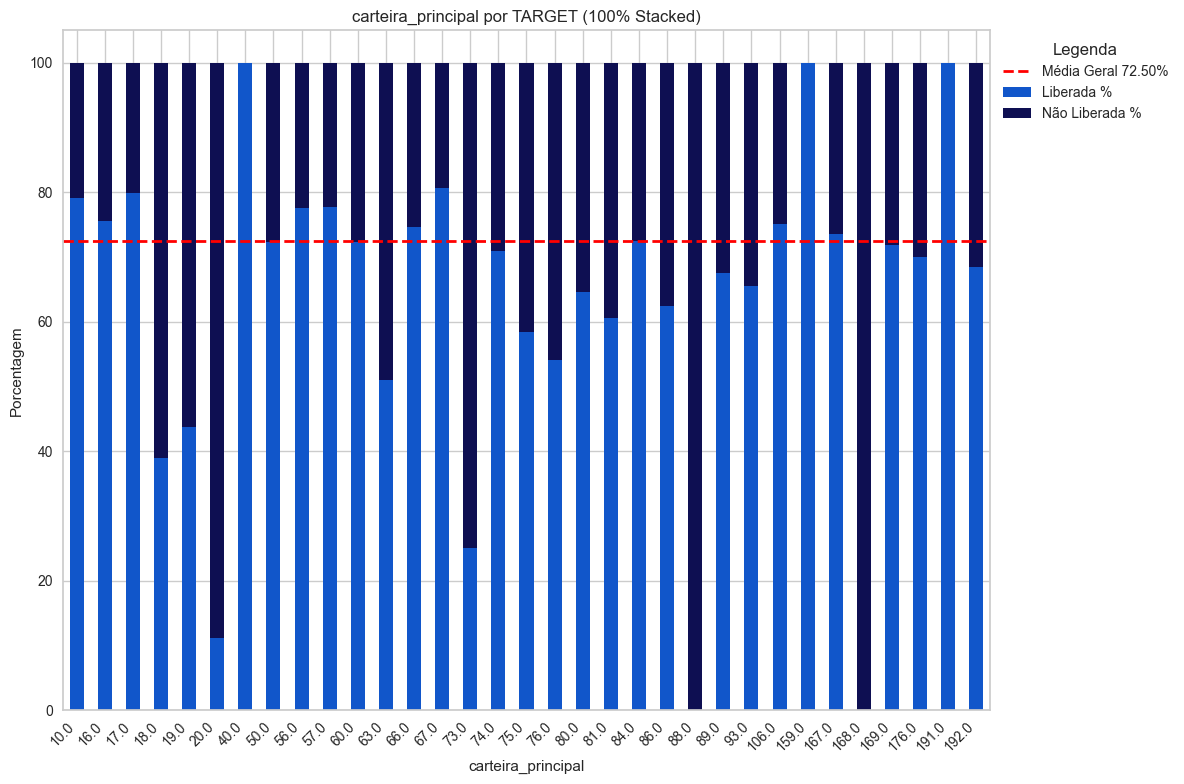

In [24]:
# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['carteira_principal'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'carteira_principal'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['carteira_principal', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['carteira_principal'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('carteira_principal')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('carteira_principal por TARGET (100% Stacked)')
plt.xlabel('carteira_principal')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

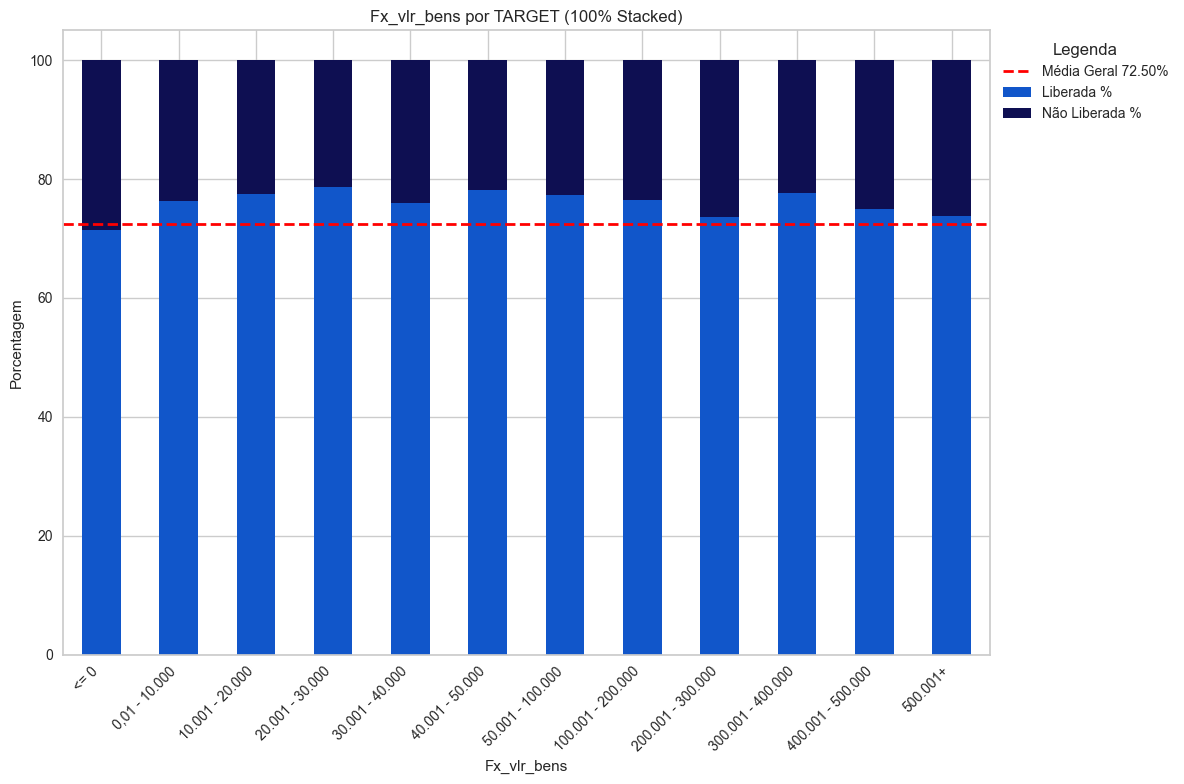

In [25]:
# Definindo os intervalos e as etiquetas
bins = [-float('inf'), 0, 10000, 20000, 30000, 40000, 50000, 100000, 200000, 300000, 400000, 500000, float('inf')]
labels = [
    '<= 0', 
    '0,01 - 10.000', 
    '10.001 - 20.000', 
    '20.001 - 30.000', 
    '30.001 - 40.000',
    '40.001 - 50.000', 
    '50.001 - 100.000', 
    '100.001 - 200.000', 
    '200.001 - 300.000',
    '300.001 - 400.000', 
    '400.001 - 500.000', 
    '500.001+'
]
# Aplicando a categorização
df_inicial['Fx_vlr_bens'] = pd.cut(df_inicial['vlr_bens'], bins=bins, labels=labels)

# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['Fx_vlr_bens'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'Fx_vlr_bens'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['Fx_vlr_bens', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['Fx_vlr_bens'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('Fx_vlr_bens')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('Fx_vlr_bens por TARGET (100% Stacked)')
plt.xlabel('Fx_vlr_bens')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()


# Calculando as estatísticas
vlr_bens = df_inicial['vlr_bens'].dropna()
n = len(vlr_bens)
min_val = np.min(vlr_bens)
max_val = np.max(vlr_bens)
mean = np.mean(vlr_bens)
stddev = np.std(vlr_bens)

# Criando um DataFrame para as estatísticas
stats = pd.DataFrame({
    'Estatística': ['N', 'Mínimo', 'Máximo', 'Média', 'Desvio Padrão'],
    'Valor': [n, min_val, max_val, mean, stddev]
})

# Arredondando os valores para 2 casas decimais e formatando com pontos de milhares e vírgulas para decimais
stats['Valor'] = stats['Valor'].round(2).apply(lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Converter DataFrame para HTML
html_stats = stats.to_html(classes='table table-striped table-bordered', index=False)

# Exibir a tabela HTML no Jupyter Notebook
display(HTML(html_stats))

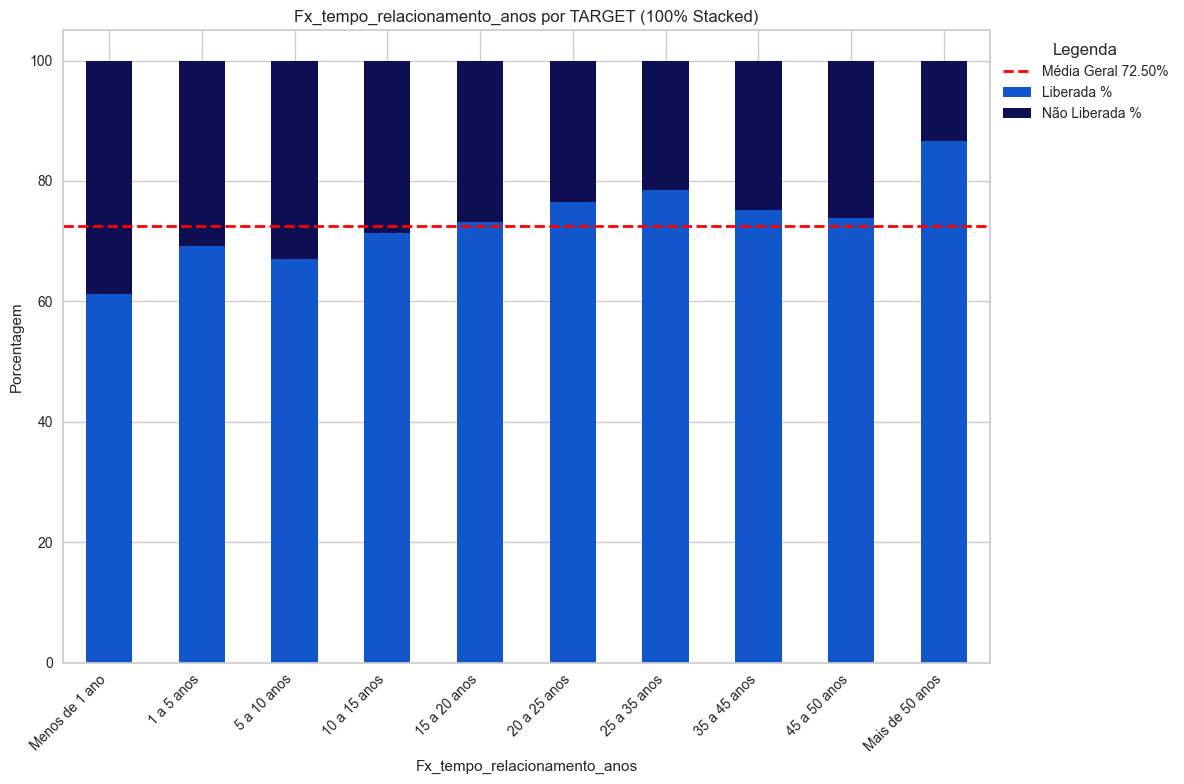

In [26]:
# Definindo os intervalos e as etiquetas de tempo de relacionamento
bins = [-float('inf'), 1, 5, 10, 15, 20, 25, 35, 45, 50, float('inf')]
labels = [
    'Menos de 1 ano', 
    '1 a 5 anos', 
    '5 a 10 anos', 
    '10 a 15 anos', 
    '15 a 20 anos', 
    '20 a 25 anos', 
    '25 a 35 anos', 
    '35 a 45 anos', 
    '45 a 50 anos', 
    'Mais de 50 anos'
]

# Aplicando a categorização
df_inicial['Fx_tempo_relacionamento_anos'] = pd.cut(df_inicial['tempo_relacionamento_anos'], bins=bins, labels=labels)

# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['Fx_tempo_relacionamento_anos'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'Fx_tempo_relacionamento_anos'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['Fx_tempo_relacionamento_anos', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['Fx_tempo_relacionamento_anos'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('Fx_tempo_relacionamento_anos')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('Fx_tempo_relacionamento_anos por TARGET (100% Stacked)')
plt.xlabel('Fx_tempo_relacionamento_anos')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()


# Calculando as estatísticas
tempo_relacionamento_anos = df_inicial['tempo_relacionamento_anos'].dropna()
n = len(tempo_relacionamento_anos)
min_val = np.min(tempo_relacionamento_anos)
max_val = np.max(tempo_relacionamento_anos)
mean = np.mean(tempo_relacionamento_anos)
stddev = np.std(tempo_relacionamento_anos)

# Criando um DataFrame para as estatísticas
stats = pd.DataFrame({
    'Estatística': ['N', 'Mínimo', 'Máximo', 'Média', 'Desvio Padrão'],
    'Valor': [n, min_val, max_val, mean, stddev]
})

# Arredondando os valores para 2 casas decimais e formatando com pontos de milhares e vírgulas para decimais
stats['Valor'] = stats['Valor'].round(2).apply(lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Converter DataFrame para HTML
html_stats = stats.to_html(classes='table table-striped table-bordered', index=False)

# Exibir a tabela HTML no Jupyter Notebook
display(HTML(html_stats))

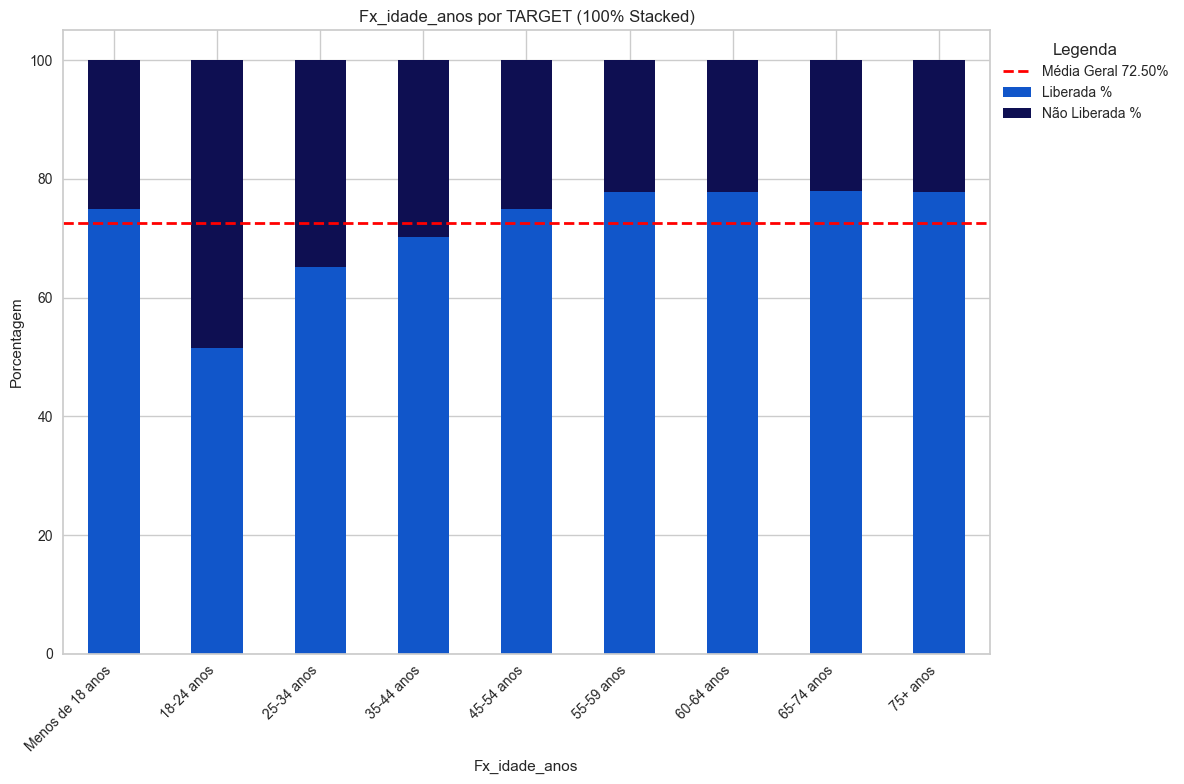

In [27]:
# Definindo os intervalos e as etiquetas de idade
bins = [-float('inf'), 17, 24, 34, 44, 54, 59, 64, 74, float('inf')]
labels = [
    'Menos de 18 anos', 
    '18-24 anos', 
    '25-34 anos', 
    '35-44 anos', 
    '45-54 anos', 
    '55-59 anos', 
    '60-64 anos', 
    '65-74 anos', 
    '75+ anos'
]
# Aplicando a categorização
df_inicial['Fx_idade_anos'] = pd.cut(df_inicial['idade_anos'], bins=bins, labels=labels)

# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['Fx_idade_anos'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'Fx_idade_anos'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['Fx_idade_anos', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['Fx_idade_anos'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('Fx_idade_anos')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('Fx_idade_anos por TARGET (100% Stacked)')
plt.xlabel('Fx_idade_anos')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()


# Calculando as estatísticas
idade_anos = df_inicial['idade_anos'].dropna()
n = len(idade_anos)
min_val = np.min(idade_anos)
max_val = np.max(idade_anos)
mean = np.mean(idade_anos)
stddev = np.std(idade_anos)

# Criando um DataFrame para as estatísticas
stats = pd.DataFrame({
    'Estatística': ['N', 'Mínimo', 'Máximo', 'Média', 'Desvio Padrão'],
    'Valor': [n, min_val, max_val, mean, stddev]
})

# Arredondando os valores para 2 casas decimais e formatando com pontos de milhares e vírgulas para decimais
stats['Valor'] = stats['Valor'].round(2).apply(lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Converter DataFrame para HTML
html_stats = stats.to_html(classes='table table-striped table-bordered', index=False)

# Exibir a tabela HTML no Jupyter Notebook
display(HTML(html_stats))

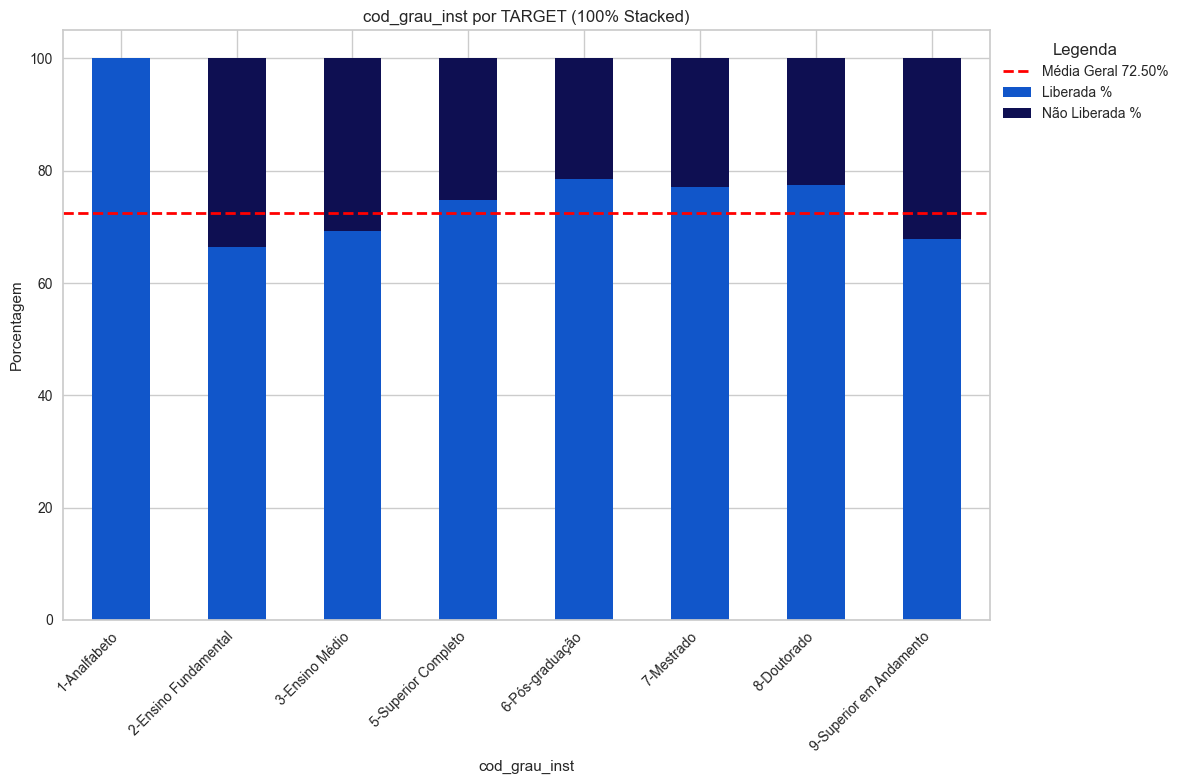

In [28]:
# Mapeamento dos códigos para os rótulos de grau de instrução
grau_inst_labels = {
    1: '1-Analfabeto',
    2: '2-Ensino Fundamental',
    3: '3-Ensino Médio',
    4: '4-Superior Incompleto',
    5: '5-Superior Completo',
    6: '6-Pós-graduação',
    7: '7-Mestrado',
    8: '8-Doutorado',
    9: '9-Superior em Andamento'
}

# Aplicando os rótulos à coluna
df_inicial['cod_grau_inst'] = df_inicial['cod_grau_inst'].map(grau_inst_labels)



# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['cod_grau_inst'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'cod_grau_inst'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['cod_grau_inst', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['cod_grau_inst'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('cod_grau_inst')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('cod_grau_inst por TARGET (100% Stacked)')
plt.xlabel('cod_grau_inst')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

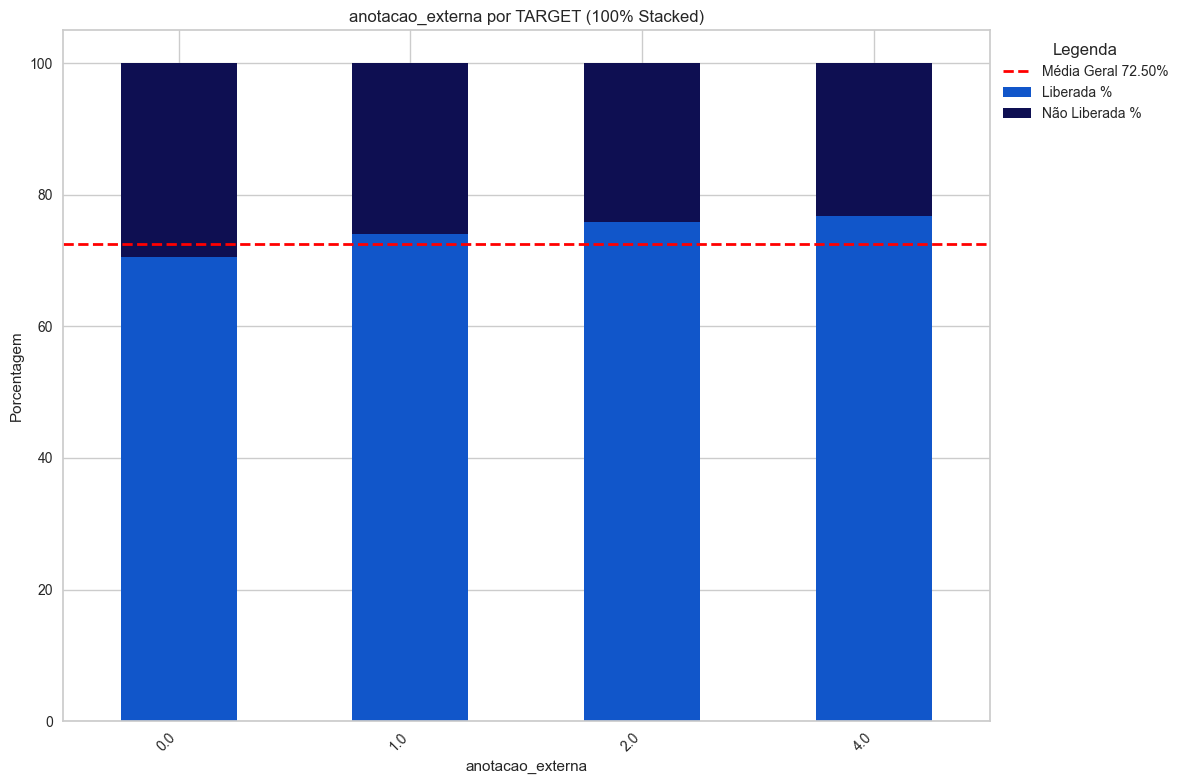

In [29]:
# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['anotacao_externa'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'anotacao_externa'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['anotacao_externa', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['anotacao_externa'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('anotacao_externa')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('anotacao_externa por TARGET (100% Stacked)')
plt.xlabel('anotacao_externa')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

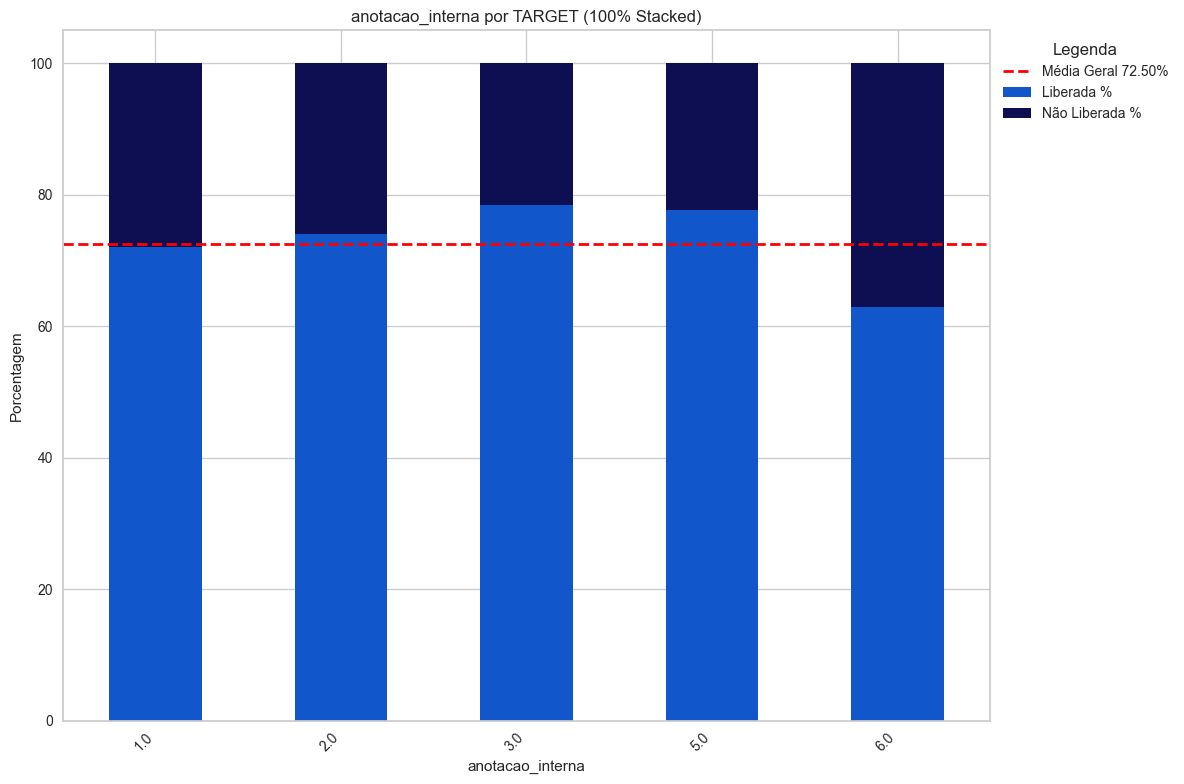

In [30]:
# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['anotacao_interna'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'anotacao_interna'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['anotacao_interna', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['anotacao_interna'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('anotacao_interna')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('anotacao_interna por TARGET (100% Stacked)')
plt.xlabel('anotacao_interna')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

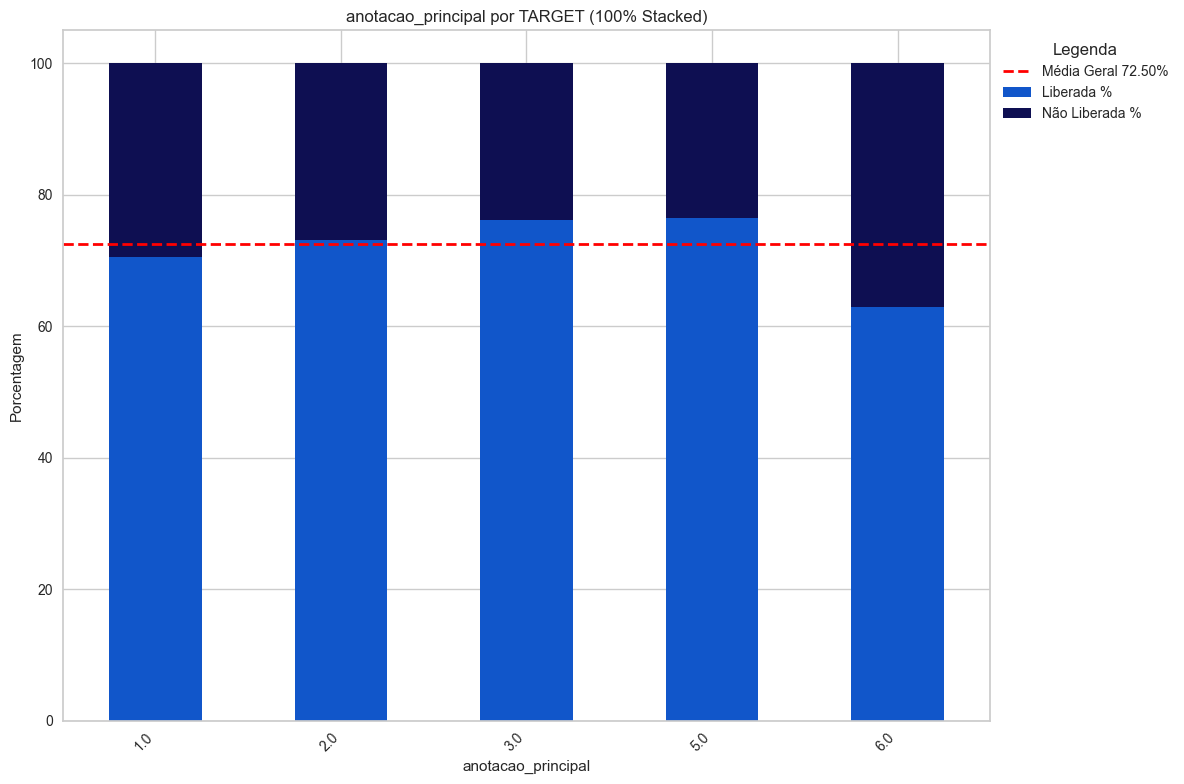

In [31]:
# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['anotacao_principal'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'anotacao_principal'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['anotacao_principal', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['anotacao_principal'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('anotacao_principal')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('anotacao_principal por TARGET (100% Stacked)')
plt.xlabel('anotacao_principal')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

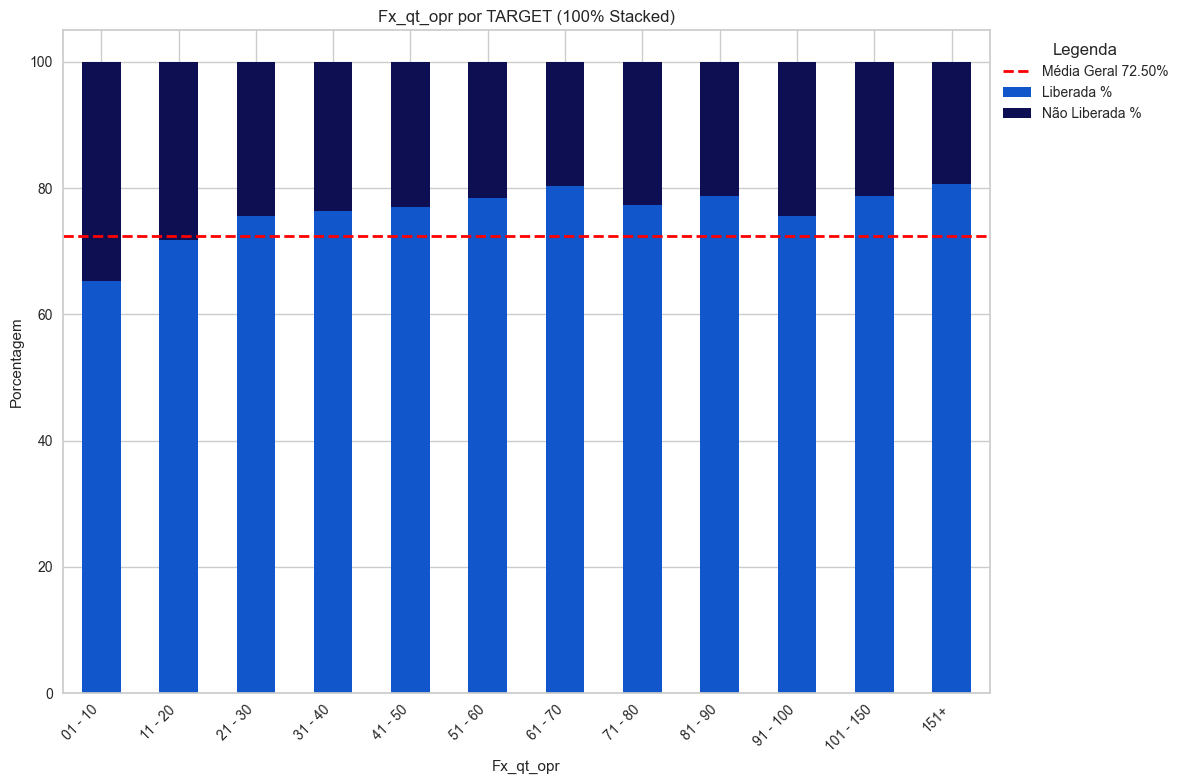

In [32]:
# Definindo os intervalos e as etiquetas para 'qt_opr'
bins = [-float('inf'),0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, float('inf')]
labels = [
    '0','01 - 10', '11 - 20', '21 - 30', '31 - 40', '41 - 50', '51 - 60', 
    '61 - 70', '71 - 80', '81 - 90', '91 - 100', '101 - 150', '151+'
]

# Aplicando a categorização
df_inicial['Fx_qt_opr'] = pd.cut(df_inicial['qt_opr'], bins=bins, labels=labels)

# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['Fx_qt_opr'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'Fx_qt_opr'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['Fx_qt_opr', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['Fx_qt_opr'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('Fx_qt_opr')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('Fx_qt_opr por TARGET (100% Stacked)')
plt.xlabel('Fx_qt_opr')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()


# Calculando as estatísticas
qt_opr = df_inicial['qt_opr'].dropna()
n = len(qt_opr)
min_val = np.min(qt_opr)
max_val = np.max(qt_opr)
mean = np.mean(qt_opr)
stddev = np.std(qt_opr)

# Criando um DataFrame para as estatísticas
stats = pd.DataFrame({
    'Estatística': ['N', 'Mínimo', 'Máximo', 'Média', 'Desvio Padrão'],
    'Valor': [n, min_val, max_val, mean, stddev]
})

# Arredondando os valores para 2 casas decimais e formatando com pontos de milhares e vírgulas para decimais
stats['Valor'] = stats['Valor'].round(2).apply(lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Converter DataFrame para HTML
html_stats = stats.to_html(classes='table table-striped table-bordered', index=False)

# Exibir a tabela HTML no Jupyter Notebook
display(HTML(html_stats))

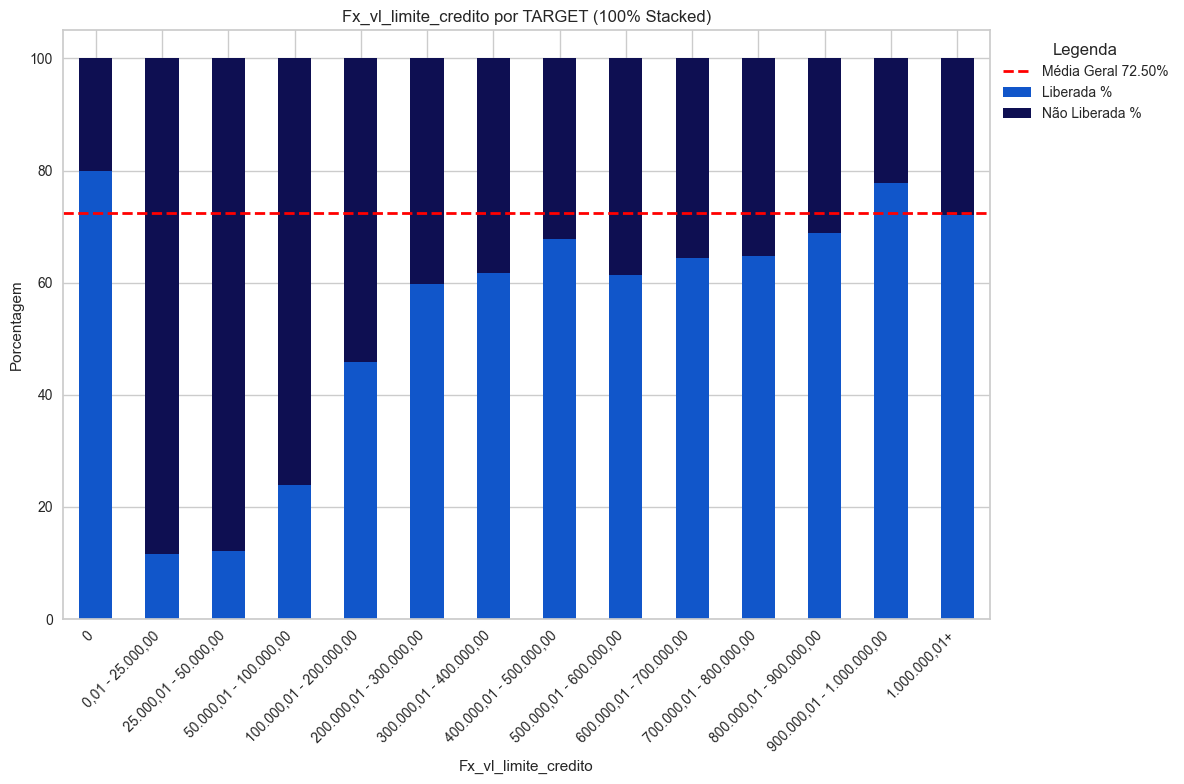

In [33]:
# Remover as categorias, convertendo de volta para numérico
df_inicial['vl_limite_credito'] = df_inicial['vl_limite_credito'].astype(float)  # ou int, se os dados forem inteiros

# Remover a coluna categorizada se necessário
df_inicial.drop(columns=['Fx_vl_limite_credito'], inplace=True, errors='ignore')
##############################################################################################################################################
# Definindo os intervalos e as etiquetas
bins = [-float('inf'), 0, 25000, 50000, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, float('inf')]
labels = [
    '0', '0,01 - 25.000,00', 
    '25.000,01 - 50.000,00', 
    '50.000,01 - 100.000,00',
    '100.000,01 - 200.000,00', 
    '200.000,01 - 300.000,00', 
    '300.000,01 - 400.000,00', 
    '400.000,01 - 500.000,00',
    '500.000,01 - 600.000,00', 
    '600.000,01 - 700.000,00', 
    '700.000,01 - 800.000,00', 
    '800.000,01 - 900.000,00', 
    '900.000,01 - 1.000.000,00', 
    '1.000.000,01+'
]

# Aplicando a categorização
df_inicial['Fx_vl_limite_credito'] = pd.cut(df_inicial['vl_limite_credito'], bins=bins, labels=labels)



# Aplicando a categorização
df_inicial['Fx_vl_limite_credito'] = pd.cut(df_inicial['vl_limite_credito'], bins=bins, labels=labels)

# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['Fx_vl_limite_credito'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'Fx_vl_limite_credito'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['Fx_vl_limite_credito', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['Fx_vl_limite_credito'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('Fx_vl_limite_credito')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('Fx_vl_limite_credito por TARGET (100% Stacked)')
plt.xlabel('Fx_vl_limite_credito')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()


# Calculando as estatísticas
vl_limite_credito = df_inicial['vl_limite_credito'].dropna()
n = len(vl_limite_credito)
min_val = np.min(vl_limite_credito)
max_val = np.max(vl_limite_credito)
mean = np.mean(vl_limite_credito)
stddev = np.std(vl_limite_credito)

# Criando um DataFrame para as estatísticas
stats = pd.DataFrame({
    'Estatística': ['N', 'Mínimo', 'Máximo', 'Média', 'Desvio Padrão'],
    'Valor': [n, min_val, max_val, mean, stddev]
})

# Arredondando os valores para 2 casas decimais e formatando com pontos de milhares e vírgulas para decimais
stats['Valor'] = stats['Valor'].round(2).apply(lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Converter DataFrame para HTML
html_stats = stats.to_html(classes='table table-striped table-bordered', index=False)

# Exibir a tabela HTML no Jupyter Notebook
display(HTML(html_stats))

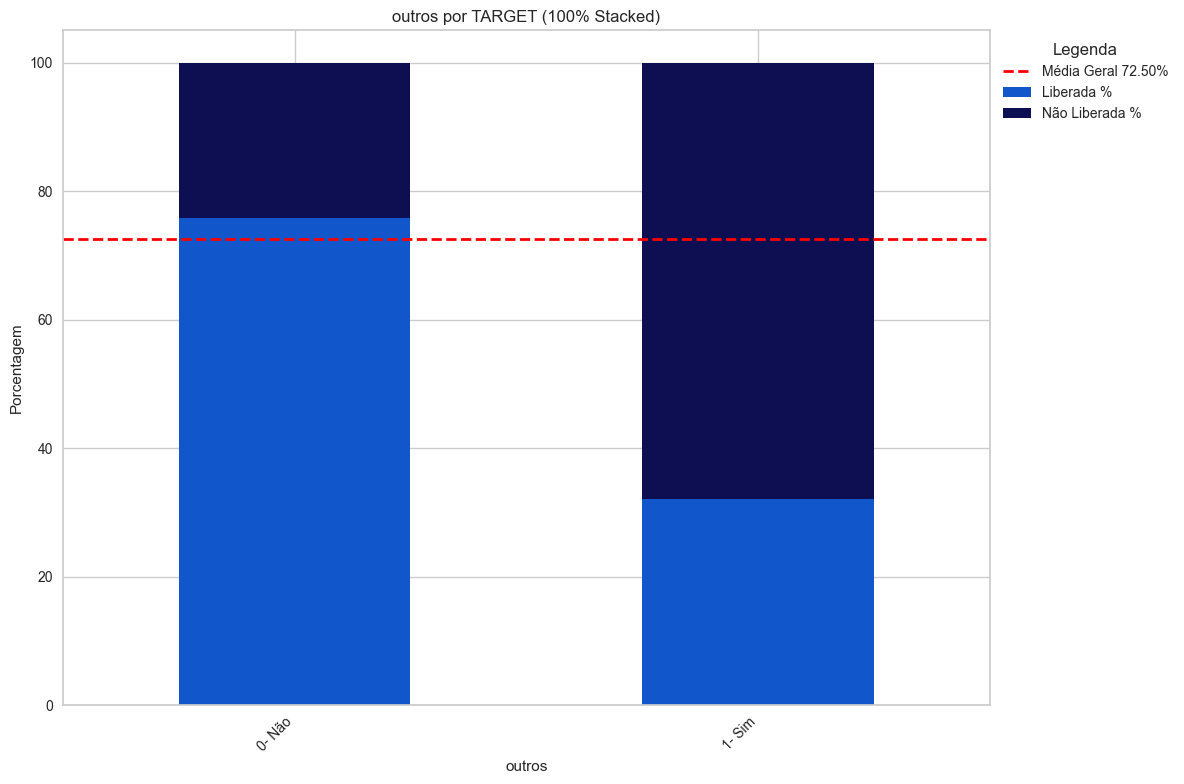

In [34]:
# Mapeamento dos códigos
outros_labels = {
    0: '0- Não',
    1: '1- Sim'
}

# Aplicando os rótulos à coluna
df_inicial['outros'] = df_inicial['outros'].map(outros_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['outros'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'outros'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['outros', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['outros'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('outros')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('outros por TARGET (100% Stacked)')
plt.xlabel('outros')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()


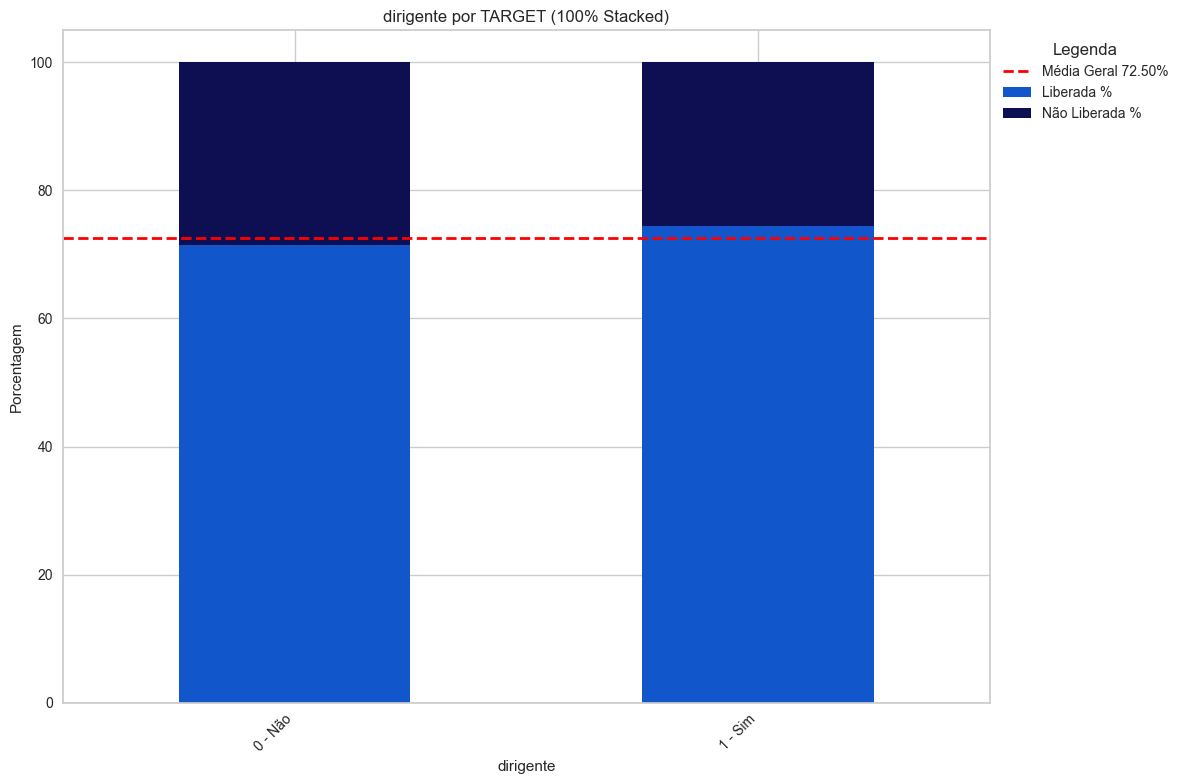

In [35]:
# Mapeamento dos códigos para os rótulos de grau de instrução
dirigente_labels = {
    0: '0 - Não',
    1: '1 - Sim'
}

# Aplicando os rótulos à coluna
df_inicial['dirigente'] = df_inicial['dirigente'].map(dirigente_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['dirigente'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'dirigente'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['dirigente', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['dirigente'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('dirigente')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('dirigente por TARGET (100% Stacked)')
plt.xlabel('dirigente')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

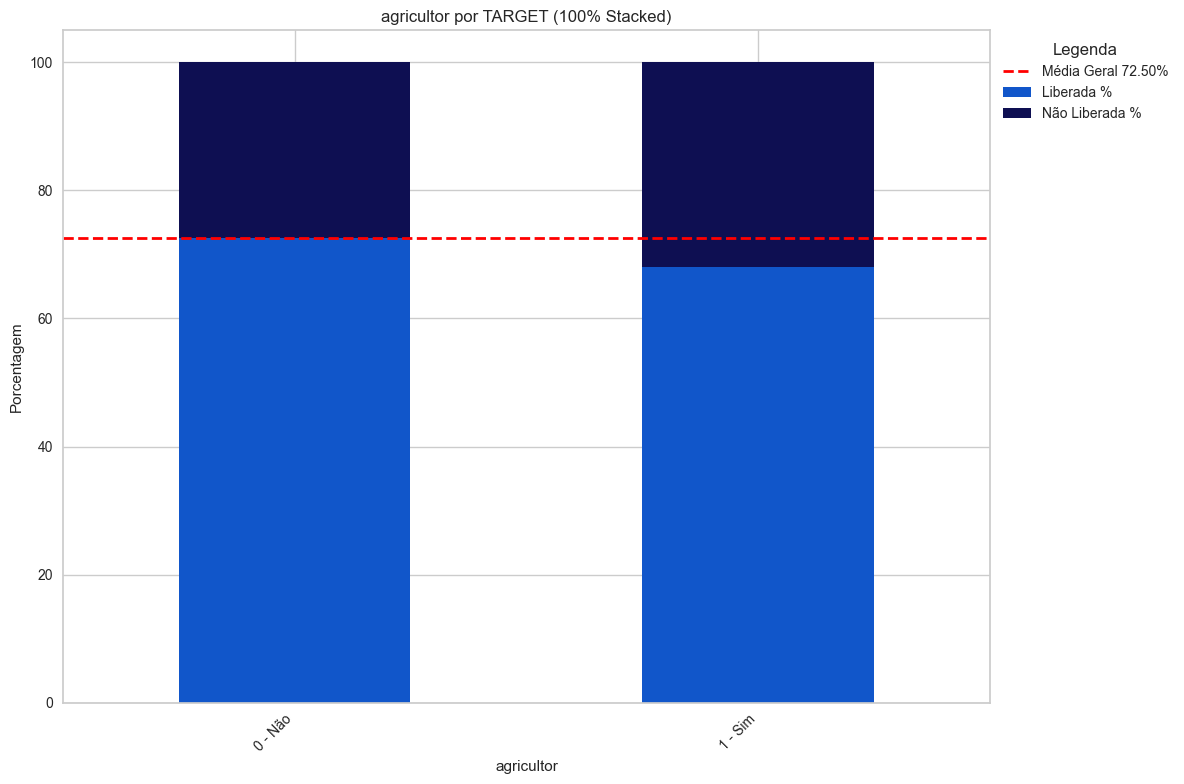

In [36]:
# Mapeamento dos códigos para os rótulos de grau de instrução
agricultor_labels = {
    0: '0 - Não',
    1: '1 - Sim'
}

# Aplicando os rótulos à coluna
df_inicial['agricultor'] = df_inicial['agricultor'].map(agricultor_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['agricultor'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'agricultor'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['agricultor', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['agricultor'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('agricultor')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('agricultor por TARGET (100% Stacked)')
plt.xlabel('agricultor')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

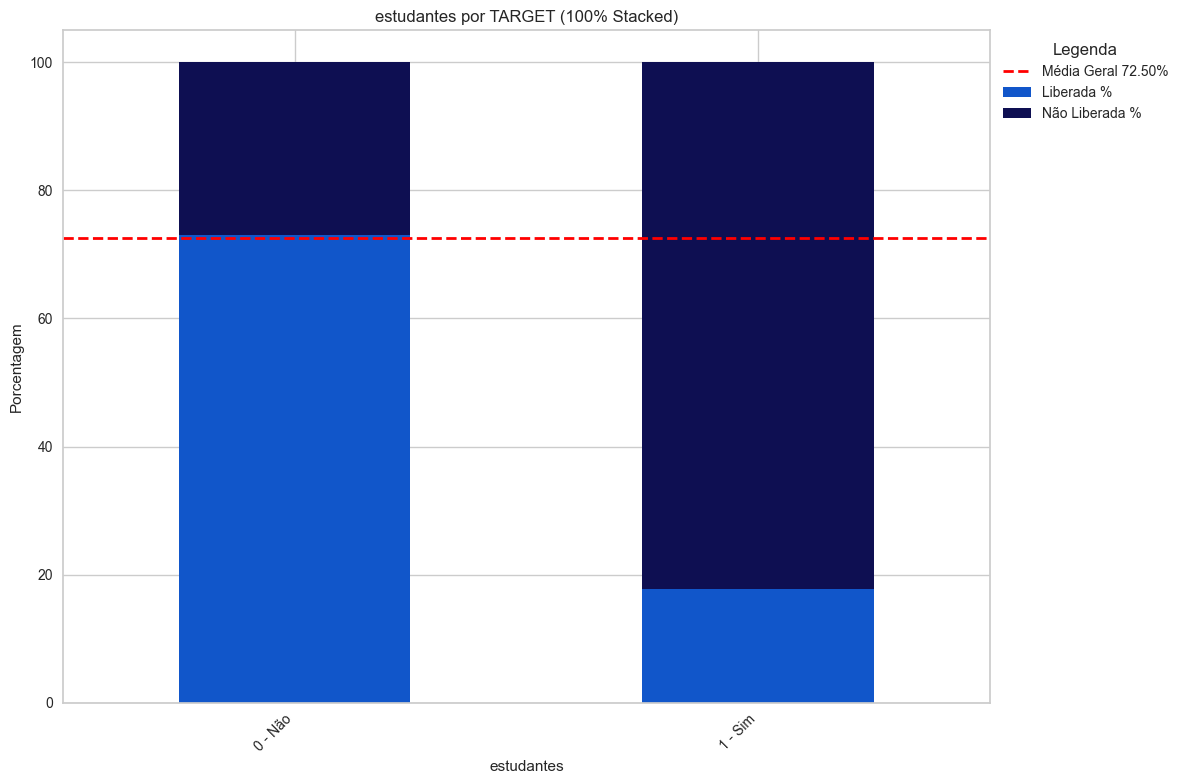

In [37]:
# Mapeamento dos códigos para os rótulos de grau de instrução
estudantes_labels = {
    0: '0 - Não',
    1: '1 - Sim'
}

# Aplicando os rótulos à coluna
df_inicial['estudantes'] = df_inicial['estudantes'].map(estudantes_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['estudantes'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'estudantes'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['estudantes', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['estudantes'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('estudantes')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('estudantes por TARGET (100% Stacked)')
plt.xlabel('estudantes')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

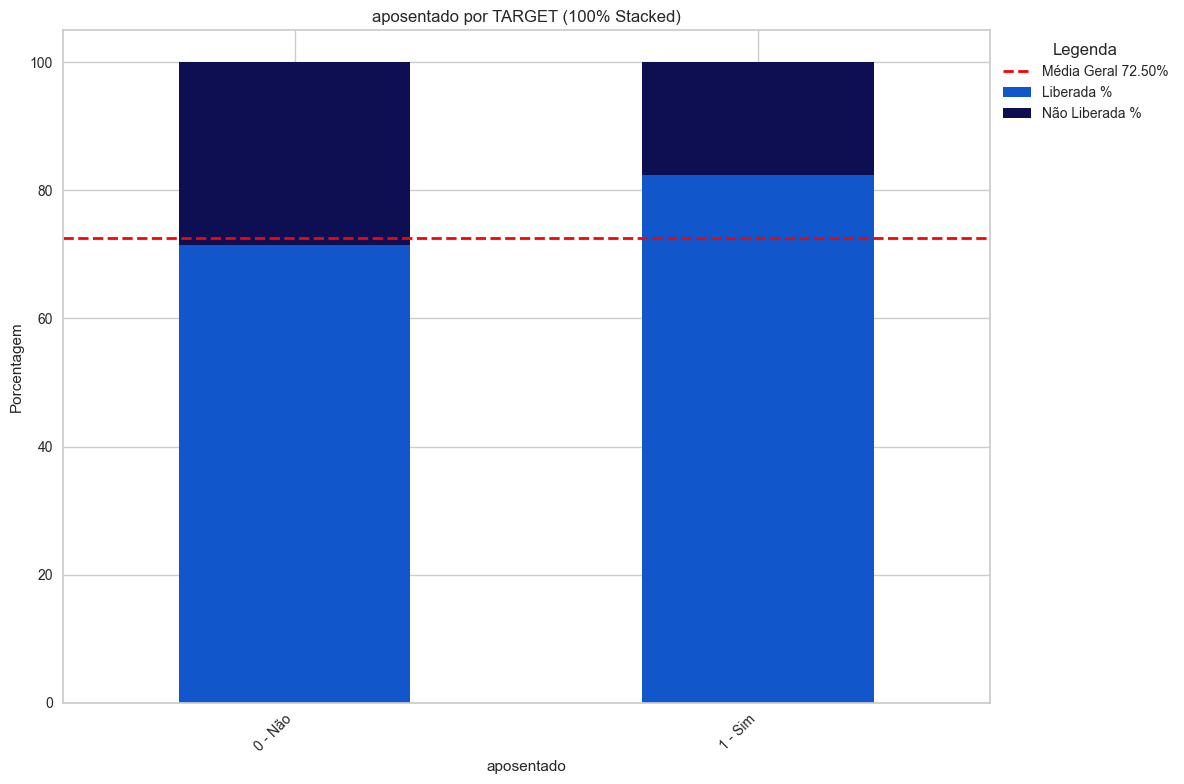

In [38]:
# Mapeamento dos códigos para os rótulos de grau de instrução
aposentado_labels = {
    0: '0 - Não',
    1: '1 - Sim'
}

# Aplicando os rótulos à coluna
df_inicial['aposentado'] = df_inicial['aposentado'].map(aposentado_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['aposentado'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'aposentado'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['aposentado', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['aposentado'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('aposentado')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('aposentado por TARGET (100% Stacked)')
plt.xlabel('aposentado')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

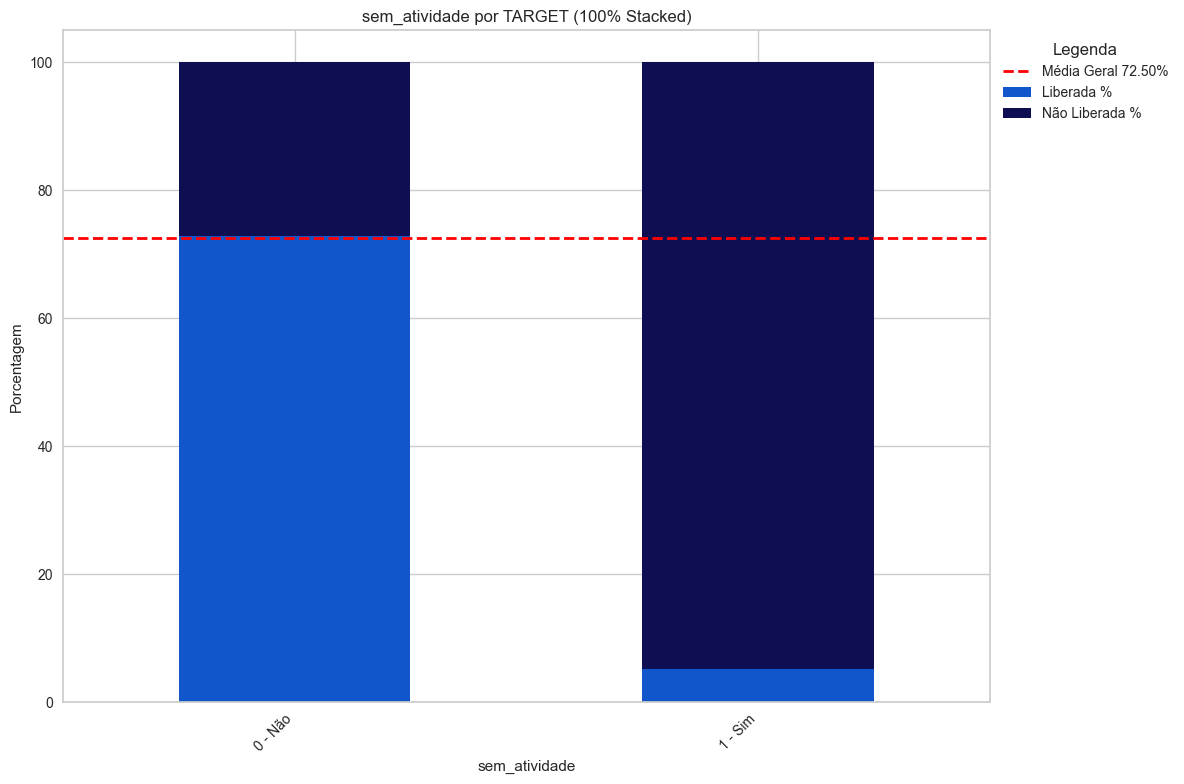

In [39]:
# Mapeamento dos códigos para os rótulos de grau de instrução
sem_atividade_labels = {
    0: '0 - Não',
    1: '1 - Sim'
}

# Aplicando os rótulos à coluna
df_inicial['sem_atividade'] = df_inicial['sem_atividade'].map(sem_atividade_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['sem_atividade'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'sem_atividade'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['sem_atividade', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['sem_atividade'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('sem_atividade')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('sem_atividade por TARGET (100% Stacked)')
plt.xlabel('sem_atividade')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

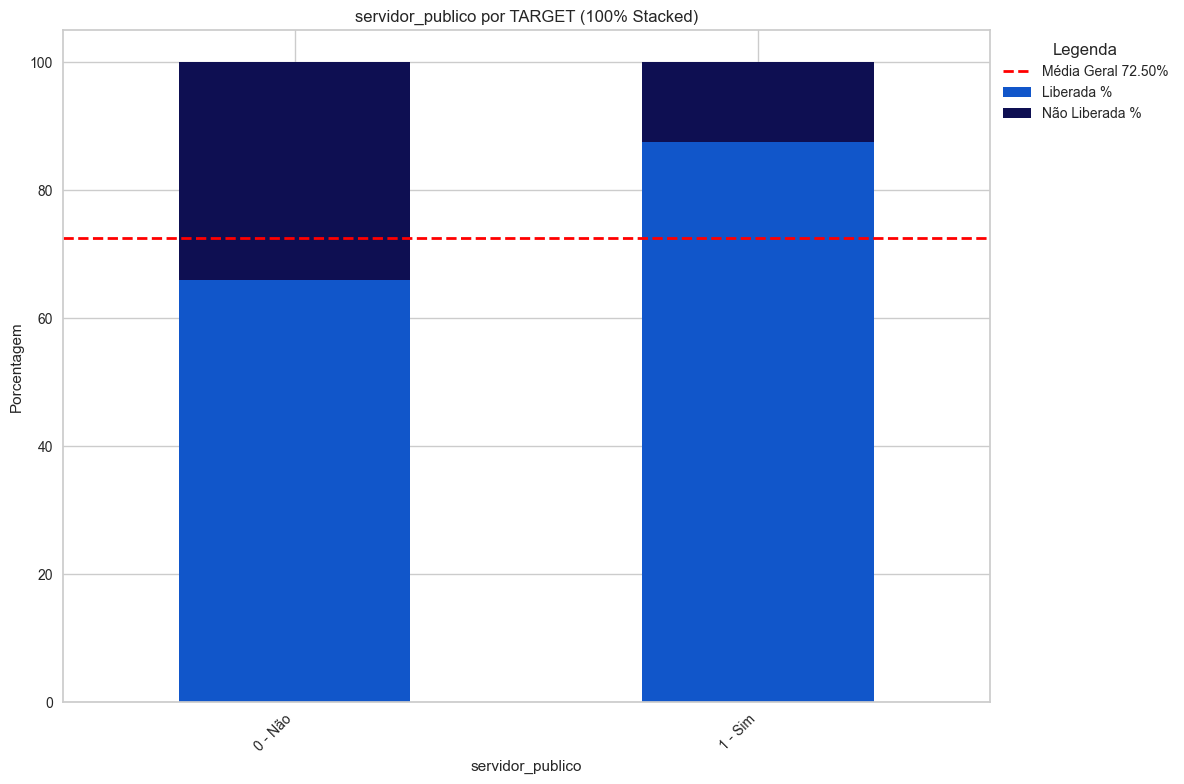

In [40]:
# Mapeamento dos códigos para os rótulos de grau de instrução
servidor_publico_labels = {
    0: '0 - Não',
    1: '1 - Sim'
}

# Aplicando os rótulos à coluna
df_inicial['servidor_publico'] = df_inicial['servidor_publico'].map(servidor_publico_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['servidor_publico'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'servidor_publico'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['servidor_publico', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['servidor_publico'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('servidor_publico')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('servidor_publico por TARGET (100% Stacked)')
plt.xlabel('servidor_publico')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()


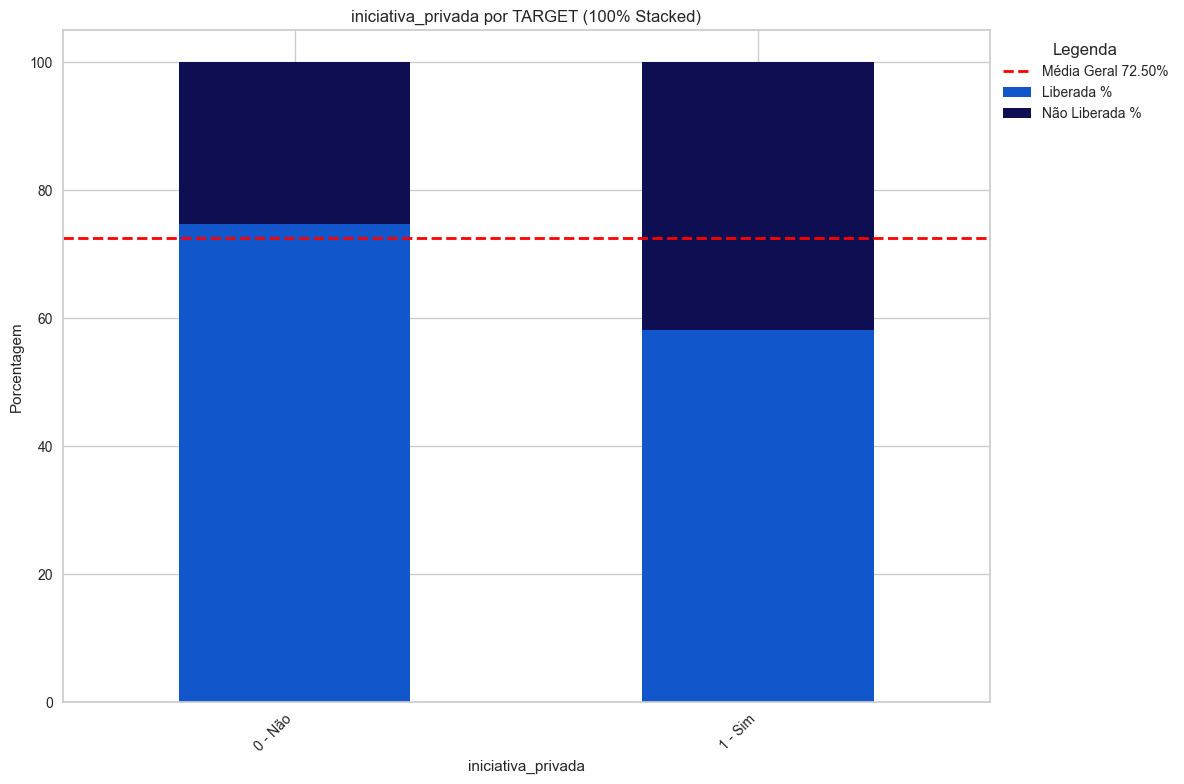

In [41]:
# Mapeamento dos códigos para os rótulos de grau de instrução
iniciativa_privada_labels = {
    0: '0 - Não',
    1: '1 - Sim'
}

# Aplicando os rótulos à coluna
df_inicial['iniciativa_privada'] = df_inicial['iniciativa_privada'].map(iniciativa_privada_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['iniciativa_privada'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'iniciativa_privada'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['iniciativa_privada', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['iniciativa_privada'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('iniciativa_privada')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('iniciativa_privada por TARGET (100% Stacked)')
plt.xlabel('iniciativa_privada')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()


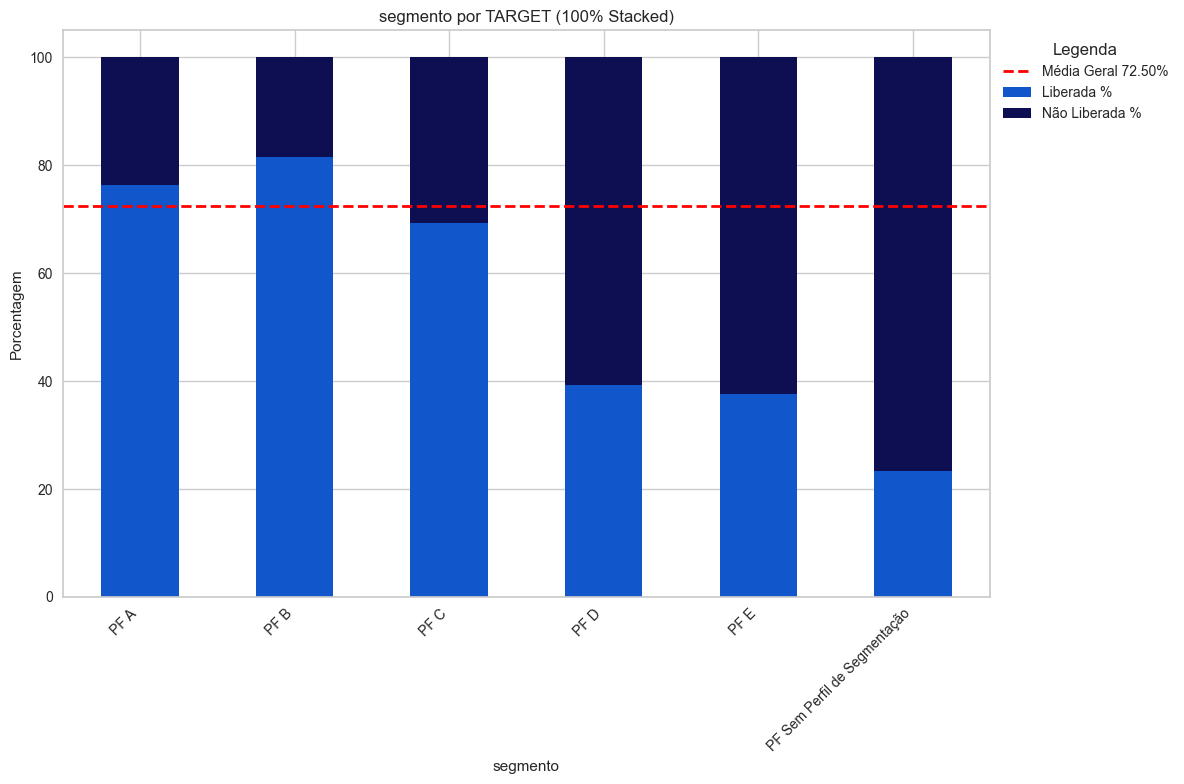

In [42]:
# Mapeamento dos códigos para os rótulos de grau de instrução
segmento_labels = {
     1111: 'PF A Classificar',
    2012: 'PF A',
    2112: 'PF B',
    2502: 'PF Sem Perfil de Segmentação',
    2602: 'PF C',
    2702: 'PF D',
    2712: 'PF E',
    2812: 'PF F'
}


# Aplicando os rótulos à coluna
df_inicial['segmento'] = df_inicial['segmento'].map(segmento_labels )


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['segmento'], df_inicial['TARGET'], margins=True)

# Renomeando as colunasc
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'segmento'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['segmento', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['segmento'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('segmento')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('segmento por TARGET (100% Stacked)')
plt.xlabel('segmento')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

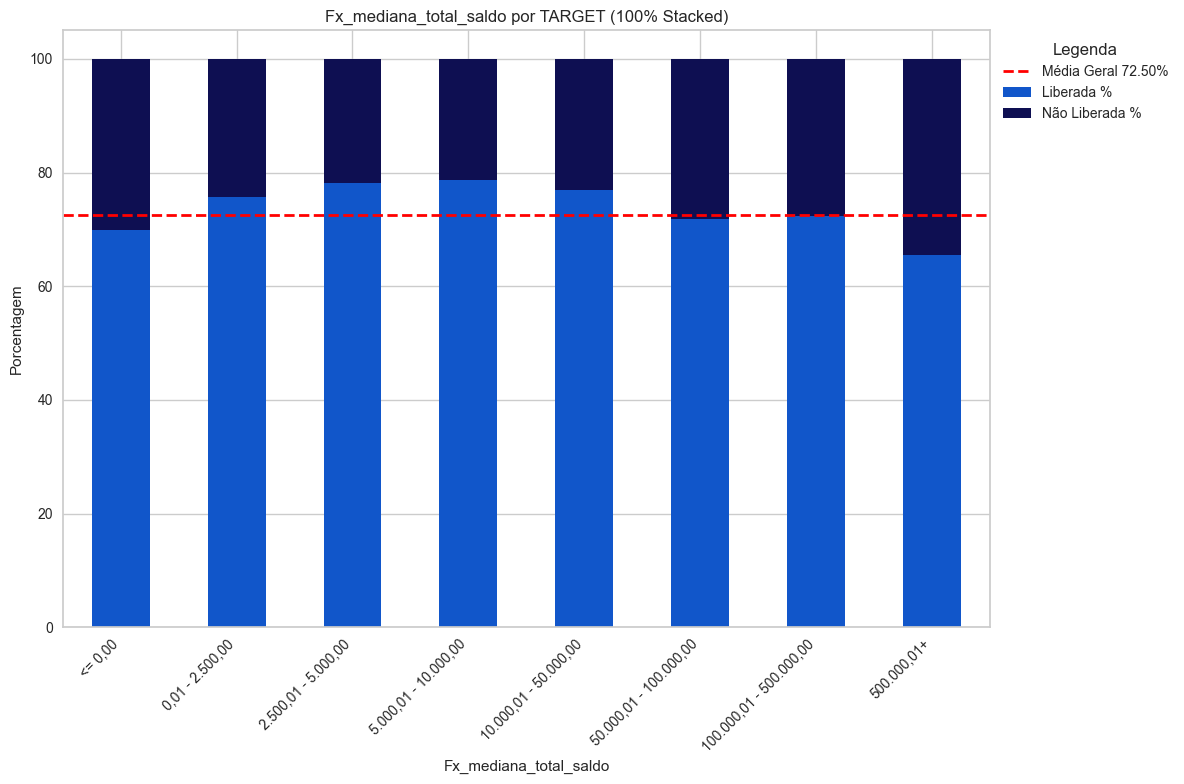

In [43]:
# Definindo os intervalos e as etiquetas para 'Mediana_TOTAL_SALDO_v2'
bins = [-float('inf'), 0, 2500, 5000, 10000, 50000, 100000, 500000, float('inf')]
labels = [
    '<= 0,00', 
    '0,01 - 2.500,00', 
    '2.500,01 - 5.000,00', 
    '5.000,01 - 10.000,00',
    '10.000,01 - 50.000,00', 
    '50.000,01 - 100.000,00', 
    '100.000,01 - 500.000,00', 
    '500.000,01+'
]

# Aplicando a categorização
df_inicial['Fx_mediana_total_saldo'] = pd.cut(df_inicial['mediana_total_saldo'], bins=bins, labels=labels)

# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['Fx_mediana_total_saldo'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'Fx_mediana_total_saldo'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['Fx_mediana_total_saldo', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['Fx_mediana_total_saldo'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('Fx_mediana_total_saldo')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('Fx_mediana_total_saldo por TARGET (100% Stacked)')
plt.xlabel('Fx_mediana_total_saldo')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()


# Calculando as estatísticas
mediana_total_saldo = df_inicial['mediana_total_saldo'].dropna()
n = len(mediana_total_saldo)
min_val = np.min(mediana_total_saldo)
max_val = np.max(mediana_total_saldo)
mean = np.mean(mediana_total_saldo)
stddev = np.std(mediana_total_saldo)

# Criando um DataFrame para as estatísticas
stats = pd.DataFrame({
    'Estatística': ['N', 'Mínimo', 'Máximo', 'Média', 'Desvio Padrão'],
    'Valor': [n, min_val, max_val, mean, stddev]
})

# Arredondando os valores para 2 casas decimais e formatando com pontos de milhares e vírgulas para decimais
stats['Valor'] = stats['Valor'].round(2).apply(lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Converter DataFrame para HTML
html_stats = stats.to_html(classes='table table-striped table-bordered', index=False)

# Exibir a tabela HTML no Jupyter Notebook
display(HTML(html_stats))

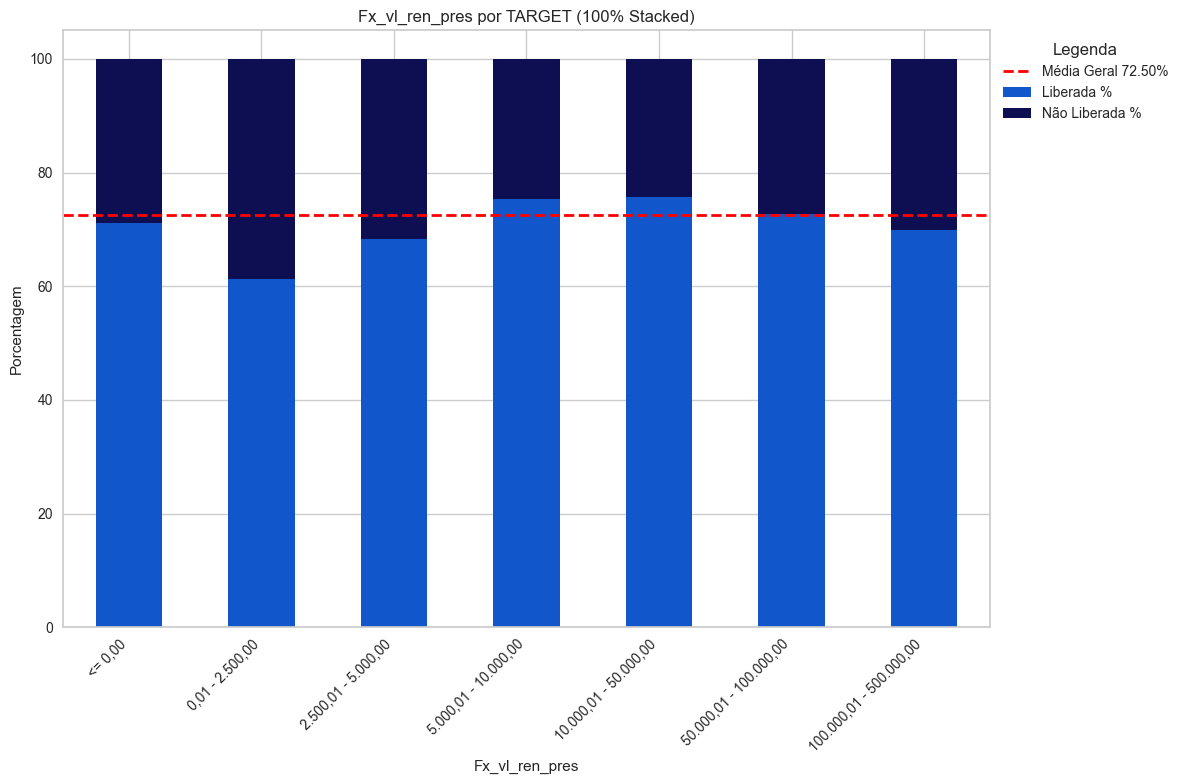

In [44]:
# Definindo os intervalos e as etiquetas para 'vl_ren_pres_v2'
bins = [-float('inf'), 0, 2500, 5000, 10000, 50000, 100000, 500000, float('inf')]
labels = [
    '<= 0,00', 
    '0,01 - 2.500,00', 
    '2.500,01 - 5.000,00', 
    '5.000,01 - 10.000,00',
    '10.000,01 - 50.000,00', 
    '50.000,01 - 100.000,00', 
    '100.000,01 - 500.000,00', 
    '500.000,01+'
]

# Aplicando a categorização
df_inicial['Fx_vl_ren_pres'] = pd.cut(df_inicial['vl_ren_pres'], bins=bins, labels=labels)

# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['Fx_vl_ren_pres'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'Fx_vl_ren_pres'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['Fx_vl_ren_pres', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['Fx_vl_ren_pres'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('Fx_vl_ren_pres')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('Fx_vl_ren_pres por TARGET (100% Stacked)')
plt.xlabel('Fx_vl_ren_pres')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()


# Calculando as estatísticas
vl_ren_pres = df_inicial['vl_ren_pres'].dropna()
n = len(vl_ren_pres)
min_val = np.min(vl_ren_pres)
max_val = np.max(vl_ren_pres)
mean = np.mean(vl_ren_pres)
stddev = np.std(vl_ren_pres)

# Criando um DataFrame para as estatísticas
stats = pd.DataFrame({
    'Estatística': ['N', 'Mínimo', 'Máximo', 'Média', 'Desvio Padrão'],
    'Valor': [n, min_val, max_val, mean, stddev]
})

# Arredondando os valores para 2 casas decimais e formatando com pontos de milhares e vírgulas para decimais
stats['Valor'] = stats['Valor'].round(2).apply(lambda x: f"{x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Converter DataFrame para HTML
html_stats = stats.to_html(classes='table table-striped table-bordered', index=False)

# Exibir a tabela HTML no Jupyter Notebook
display(HTML(html_stats))

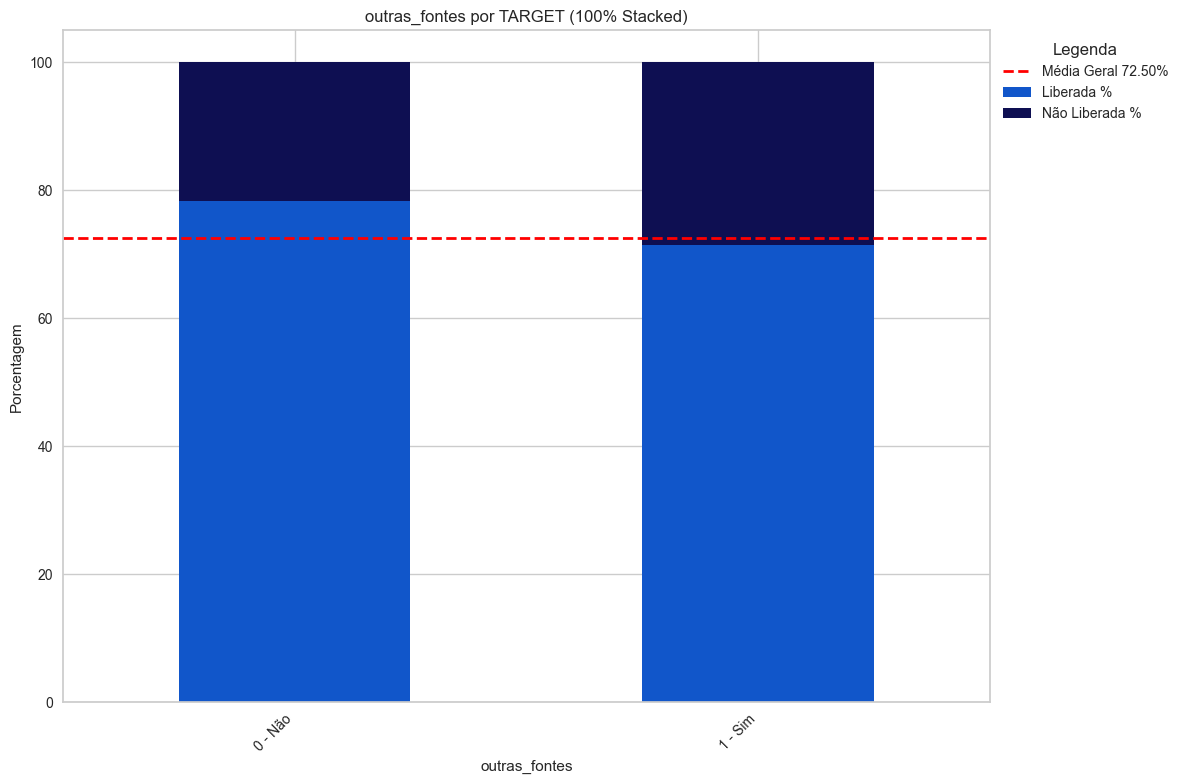

In [45]:
# Mapeamento dos códigos para os rótulos de grau de instrução
outras_fontes_labels = {
    0: '0 - Não',
    1: '1 - Sim'
}

# Aplicando os rótulos à coluna
df_inicial['outras_fontes'] = df_inicial['outras_fontes'].map(outras_fontes_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['outras_fontes'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'outras_fontes'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['outras_fontes', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['outras_fontes'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('outras_fontes')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('outras_fontes por TARGET (100% Stacked)')
plt.xlabel('outras_fontes')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

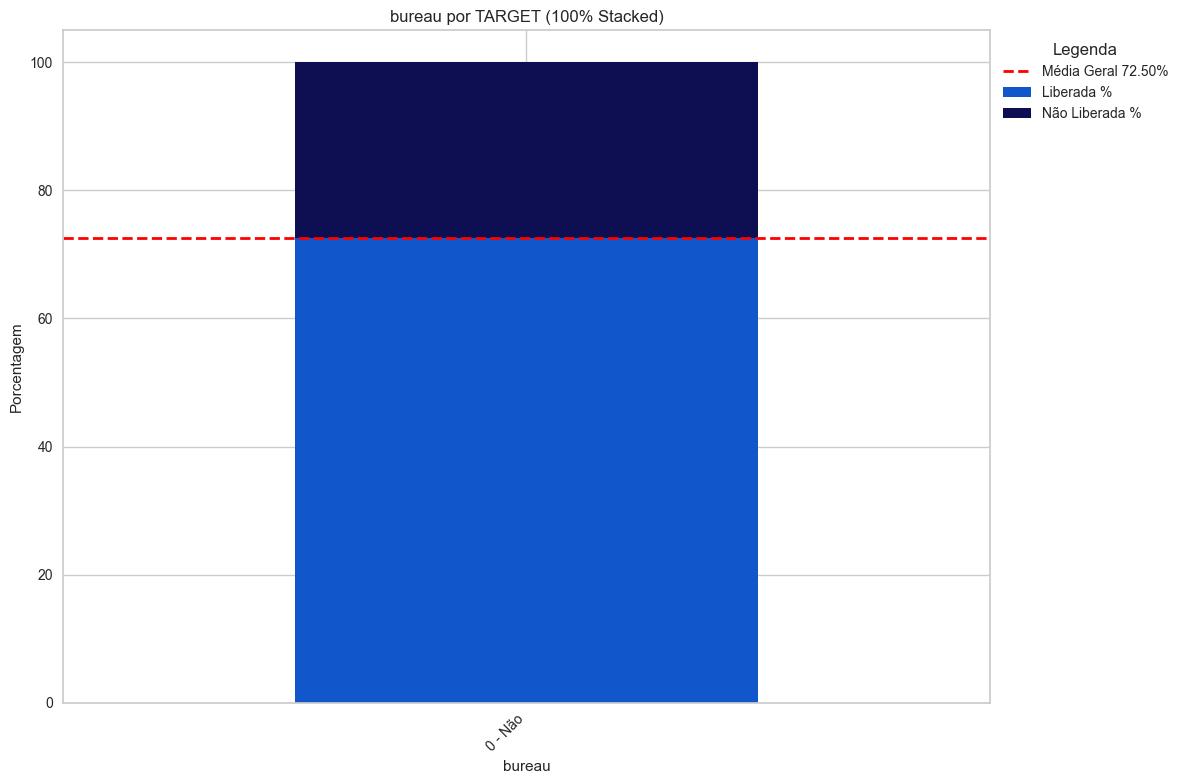

In [46]:
# Mapeamento dos códigos para os rótulos de grau de instrução
bureau_labels = {
    0: '0 - Não',
    1: '1 - Sim'
}

# Aplicando os rótulos à coluna
df_inicial['bureau'] = df_inicial['bureau'].map(bureau_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['bureau'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'bureau'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['bureau', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['bureau'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('bureau')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('bureau por TARGET (100% Stacked)')
plt.xlabel('bureau')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

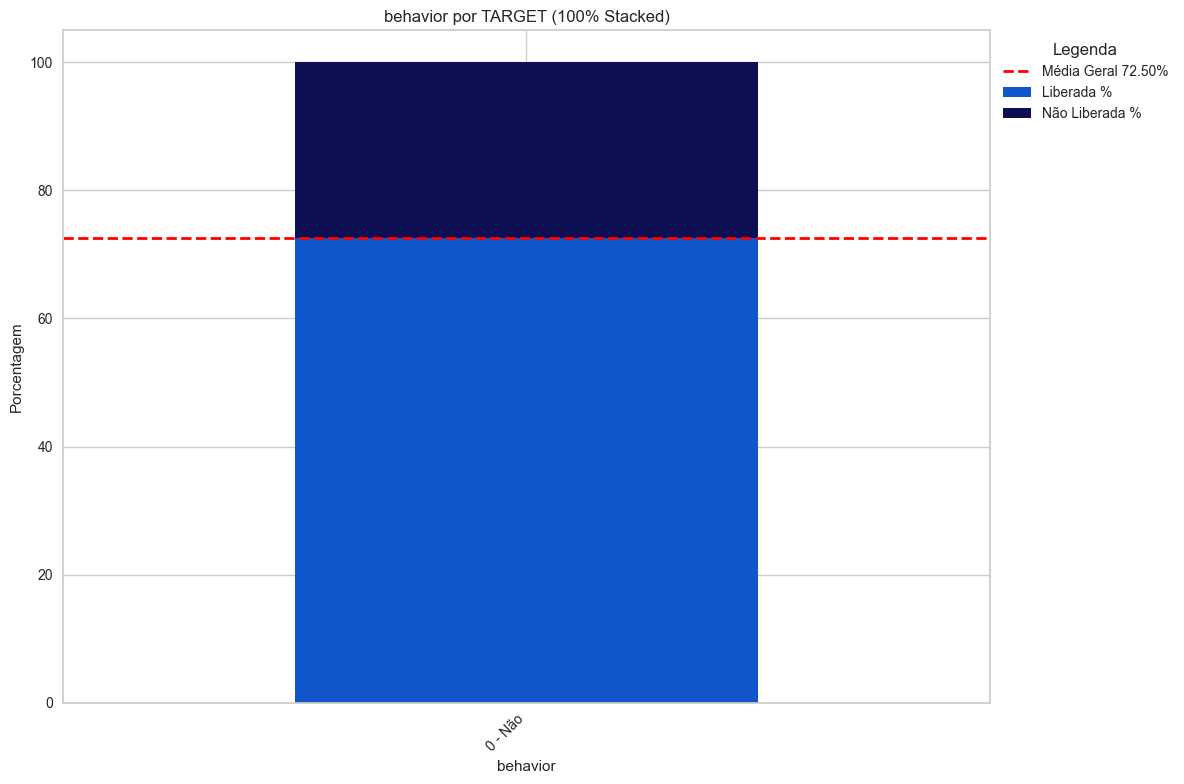

In [47]:
# Mapeamento dos códigos para os rótulos de grau de instrução
behavior_labels = {
    0: '0 - Não',
    1: '1 - Sim'
}

# Aplicando os rótulos à coluna
df_inicial['behavior'] = df_inicial['behavior'].map(behavior_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['behavior'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'behavior'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['behavior', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['behavior'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('behavior')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('behavior por TARGET (100% Stacked)')
plt.xlabel('behavior')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

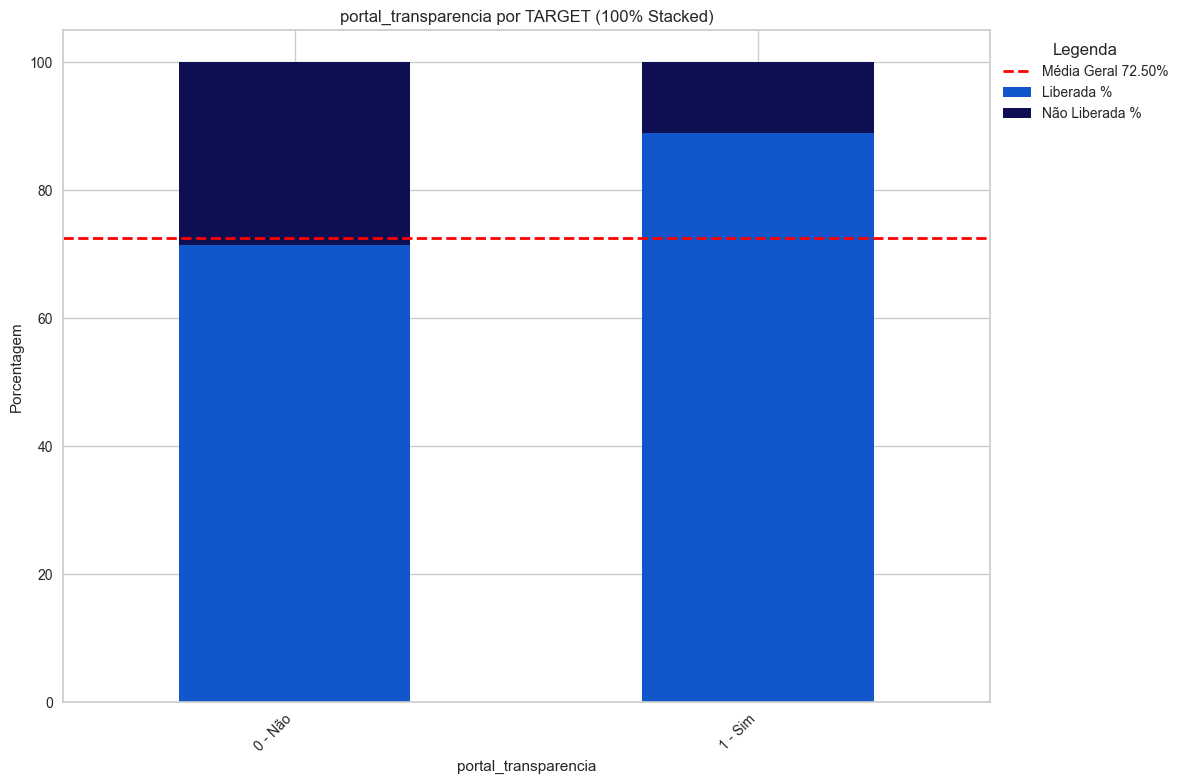

In [48]:
# Mapeamento dos códigos para os rótulos de grau de instrução
portal_transparencia_labels = {
    0: '0 - Não',
    1: '1 - Sim'
}

# Aplicando os rótulos à coluna
df_inicial['portal_transparencia'] = df_inicial['portal_transparencia'].map(portal_transparencia_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['portal_transparencia'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'portal_transparencia'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['portal_transparencia', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['portal_transparencia'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('portal_transparencia')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('portal_transparencia por TARGET (100% Stacked)')
plt.xlabel('portal_transparencia')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

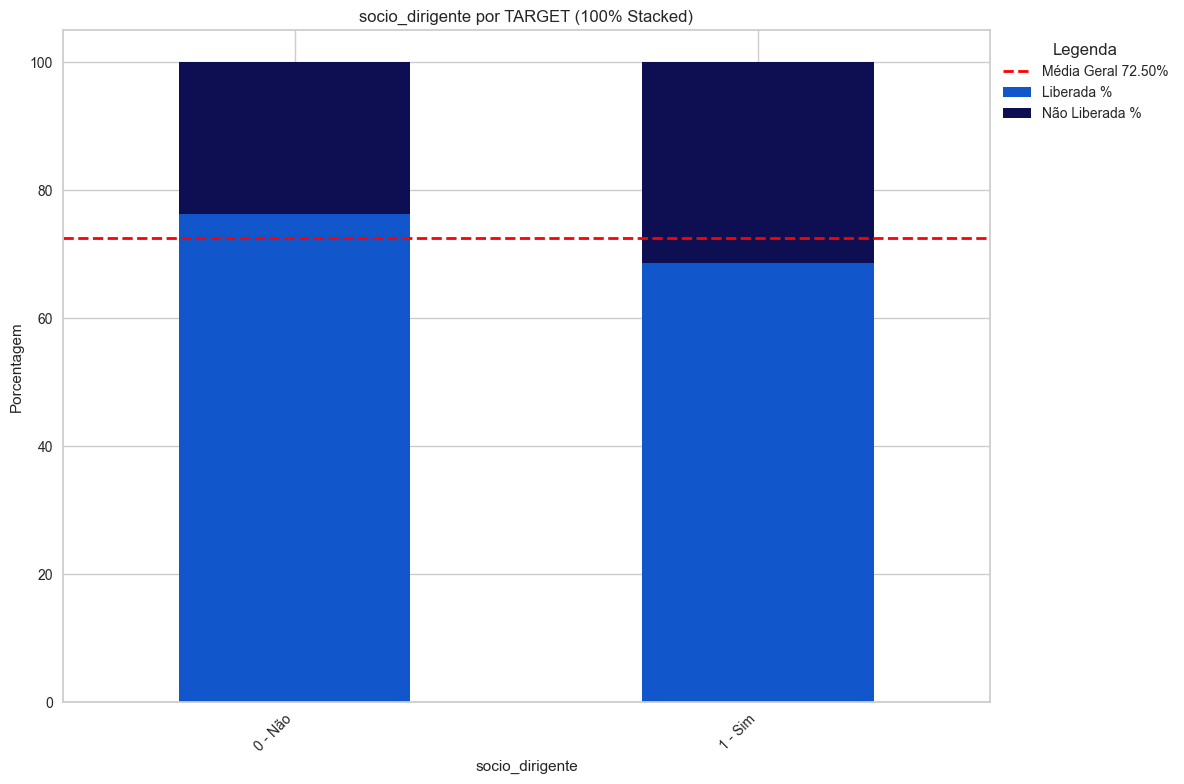

In [49]:
# Mapeamento dos códigos para os rótulos de grau de instrução
socio_dirigente_labels = {
    0: '0 - Não',
    1: '1 - Sim'
}

# Aplicando os rótulos à coluna
df_inicial['socio_dirigente'] = df_inicial['socio_dirigente'].map(socio_dirigente_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['socio_dirigente'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'socio_dirigente'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['socio_dirigente', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['socio_dirigente'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('socio_dirigente')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('socio_dirigente por TARGET (100% Stacked)')
plt.xlabel('socio_dirigente')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()

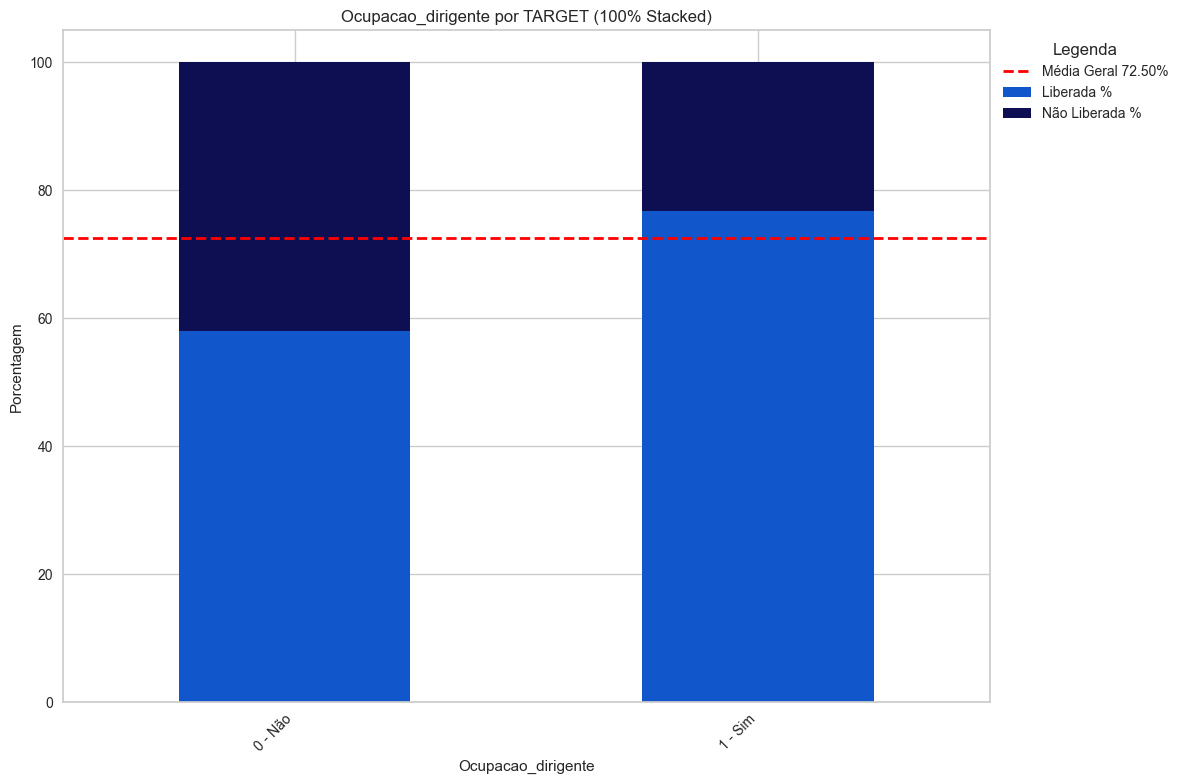

In [50]:
# Mapeamento dos códigos para os rótulos de grau de instrução
Ocupacao_dirigente_labels = {
    0: '0 - Não',
    1: '1 - Sim'
}

# Aplicando os rótulos à coluna
df_inicial['Ocupacao_dirigente'] = df_inicial['Ocupacao_dirigente'].map(Ocupacao_dirigente_labels)


# Criando a tabela de contingência
contingency_table = pd.crosstab(df_inicial['Ocupacao_dirigente'], df_inicial['TARGET'], margins=True)

# Renomeando as colunas
contingency_table.columns = ['Não Liberada', 'Liberada', 'Total']

# Calculando os totais e percentuais
contingency_table['% Total'] = (contingency_table['Total'] / contingency_table.loc['All', 'Total'] * 100).round(1)
contingency_table['% Acumulado'] = contingency_table['% Total'].cumsum().round(1)
contingency_table['% Liberada'] = (contingency_table['Liberada'] / contingency_table['Total'] * 100).round(1)
contingency_table['% Não Liberada'] = (contingency_table['Não Liberada'] / contingency_table['Total'] * 100).round(1)

# Ajustando a tabela final
final_table = contingency_table.drop('All').reset_index()
final_table.loc['Total'] = final_table.sum(numeric_only=True)
final_table.at['Total', 'Ocupacao_dirigente'] = 'Total'
final_table.at['Total', '% Total'] = 100
final_table.at['Total', '% Acumulado'] = 100
final_table.at['Total', '% Liberada'] = contingency_table.at['All', '% Liberada']
final_table.at['Total', '% Não Liberada'] = contingency_table.at['All', '% Não Liberada']

# Reordenando as colunas
final_table = final_table[['Ocupacao_dirigente', 'Total', '% Total', '% Acumulado', 'Liberada', 'Não Liberada', '% Liberada', '% Não Liberada']]

# Exibir a tabela com melhor formatação no Jupyter Notebook
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.expand_frame_repr', False)  # Evitar quebra de linha

# print(tabulate(final_table, headers='keys', tablefmt='pretty'))

# Exportar para HTML
html_table = final_table.to_html(classes='table table-striped table-bordered', index=False)

# Salvar o HTML em um arquivo
# with open('tabela_final.html', 'w') as f:
#    f.write(html_table)

# Exibir a tabela HTML no Jupyter Notebook
from IPython.core.display import HTML
display(HTML(html_table))

# Grafico final
# Remover a linha de Total da tabela final
df_plot = final_table[final_table['Ocupacao_dirigente'] != 'Total'].copy()

# Calcular as porcentagens
df_plot.loc[:, 'Liberada %'] = (df_plot['Liberada'] / df_plot['Total'] * 100).round(2)
df_plot.loc[:, 'Não Liberada %'] = (df_plot['Não Liberada'] / df_plot['Total'] * 100).round(2)

# Gráfico de barras empilhadas 100%
fig, ax = plt.subplots(figsize=(12, 8))  # Ajuste o tamanho conforme necessário

df_plot.set_index('Ocupacao_dirigente')[['Liberada %', 'Não Liberada %']].plot(
    kind='bar', stacked=True, ax=ax, color=['#1156ca', '#0e0f52']
)
 

# Adicionar linha de média geral  ff7f0e
average_percentage = 72.50
ax.axhline(y=average_percentage, color='red', linestyle='--', linewidth=2, label='Média Geral 72.50%')

plt.title('Ocupacao_dirigente por TARGET (100% Stacked)')
plt.xlabel('Ocupacao_dirigente')
plt.ylabel('Porcentagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.legend(title='Legenda', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Ajusta o layout
plt.show()


In [51]:
# Exibir informações detalhadas sobre o DataFrame df_inicial
print("Informações sobre o DataFrame df_inicial:")
df_inicial.info()

Informações sobre o DataFrame df_inicial:
<class 'pandas.core.frame.DataFrame'>
Index: 20315 entries, 0 to 20364
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   cd_cli                        20315 non-null  int64   
 1   cpf                           20315 non-null  float64 
 2   ts_protocolo                  20315 non-null  object  
 3   y                             20315 non-null  int64   
 4   renda_analisada               20315 non-null  float64 
 5   recebe_salario                20315 non-null  object  
 6   total_investimento            20315 non-null  float64 
 7   carteira_principal            20315 non-null  float64 
 8   vlr_bens                      20315 non-null  float64 
 9   tempo_relacionamento_anos     20315 non-null  int64   
 10  idade_anos                    20315 non-null  float64 
 11  cod_grau_inst                 20300 non-null  object  
 12  anotacao_

In [52]:
print(df_inicial.dtypes)

cd_cli                             int64
cpf                              float64
ts_protocolo                      object
y                                  int64
renda_analisada                  float64
recebe_salario                    object
total_investimento               float64
carteira_principal               float64
vlr_bens                         float64
tempo_relacionamento_anos          int64
idade_anos                       float64
cod_grau_inst                     object
anotacao_externa                   int64
anotacao_interna                   int64
anotacao_principal                 int64
qt_opr                             int64
vl_limite_credito                float64
outros                            object
dirigente                         object
agricultor                        object
estudantes                        object
aposentado                        object
sem_atividade                     object
servidor_publico                  object
iniciativa_priva

In [53]:
df_original_modelagem = df_inicial.copy(deep=True)

In [54]:
# Criando a variável 'Ocupacao_dirigente' no DataFrame df_inicial
df_original_modelagem['Ocupacao_dirigente'] = np.where(df_original_modelagem['dirigente'] == '1-Sim', 1, 0)

# Obtendo a frequência (contagem) dos valores da variável 'Ocupacao_dirigente'
freq_ocupacao_dirigente = df_original_modelagem['Ocupacao_dirigente'].value_counts()

# Exibindo a frequência
print(freq_ocupacao_dirigente)

Ocupacao_dirigente
0    20315
Name: count, dtype: int64


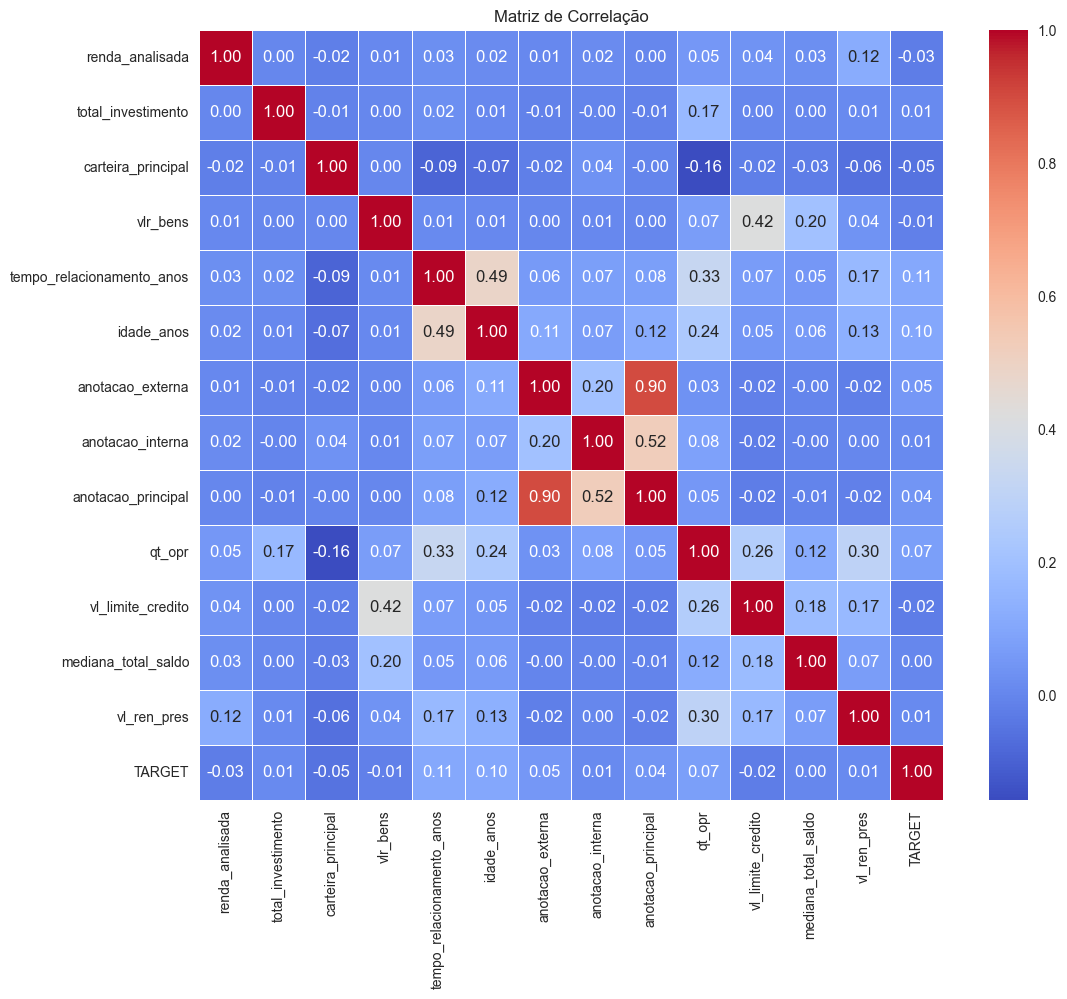

In [55]:
# Remover colunas indesejadas
columns_to_remove = ['cd_cli', 'cpf','ts_protocolo ','y','segmento']
df_filtered = df_inicial.drop(columns=columns_to_remove, errors='ignore')

# Selecionar apenas colunas numéricas
df_numeric = df_filtered.select_dtypes(include=['number'])

# Calcular a matriz de correlação
correlation_matrix = df_numeric.corr()

# Plotar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

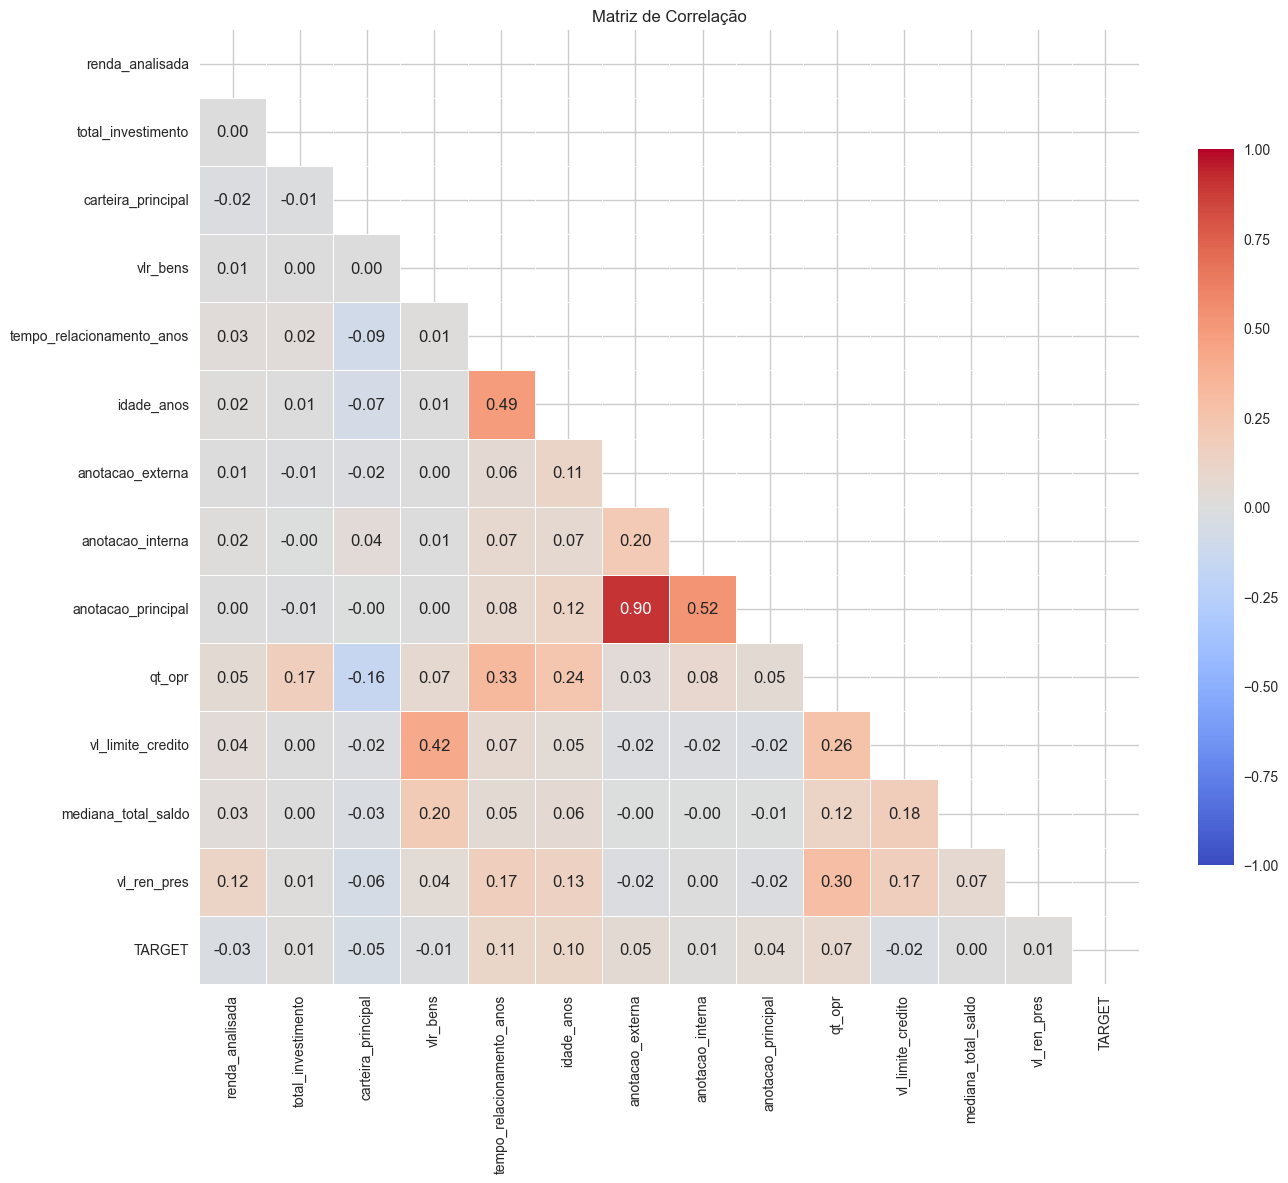

In [56]:
# Remover colunas indesejadas
columns_to_remove = ['cd_cli', 'cpf','ts_protocolo ','y','segmento']
df_filtered = df_inicial.drop(columns=columns_to_remove, errors='ignore')

# Selecionar apenas colunas numéricas
df_numeric = df_filtered.select_dtypes(include=['number'])

# Calcular a matriz de correlação
correlation_matrix = df_numeric.corr()

# Configurar a máscara para ocultar a parte superior da matriz
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plotar a matriz de correlação com configuração aprimorada
plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix, 
    mask=mask,  # Aplica a máscara
    annot=True,  # Adiciona anotações
    cmap='coolwarm',  # Paleta de cores
    fmt='.2f',  # Formato das anotações
    linewidths=0.5,  # Largura das linhas de divisão
    vmin=-1, vmax=1,  # Limites do mapa de calor
    cbar_kws={"shrink": .75}  # Configurações da barra de cores
)
plt.title('Matriz de Correlação')
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

## O Que É Correlação?

Correlação é uma medida que indica o grau e a direção da relação entre duas variáveis. Em termos simples, ela mostra se e como duas variáveis estão relacionadas.


**Exemplo Prático:**

Uma correlação de 0,45 sugere que há uma **relação moderada** entre as duas variáveis. Neste caso, **à medida que a `idade_cliente_atual` aumenta, a probabilidade de uma pessoa ser categorizada como `aposentado` também tende a aumentar**. 

- Se você observar que, em geral, clientes mais velhos têm uma maior probabilidade de serem aposentados, isso indica uma correlação positiva moderada. No entanto, **não significa que todas as pessoas mais velhas são aposentadas**, mas há uma tendência observada. A correlação de 0,45 indica que há uma tendência visível, mas não é uma regra absoluta. Existem exceções, e a correlação não explica completamente a relação.

### Interpretação Prática:

Embora não seja uma correlação perfeita, 0,45 indica que há uma tendência visível. Em termos práticos, isso significa que pessoas mais velhas têm uma maior probabilidade de serem aposentadas, mas não é uma regra absoluta. Existem exceções, e a correlação não explica completamente a relação.

## Significado das Cores na Matriz de Correlação

- **<span style="color:blue;">Azul (Valores Próximos a -1):</span>**
  Valores próximos a -1 indicam uma **correlação negativa forte**. Isso significa que, à medida que uma variável aumenta, a outra tende a diminuir. A cor azul mais escura geralmente representa uma correlação negativa mais forte.

- **<span style="color:red;">Vermelho (Valores Próximos a 1):</span>**
  Valores próximos a 1 indicam uma **correlação positiva forte**. Isso significa que, à medida que uma variável aumenta, a outra tende a aumentar também. A cor vermelha mais intensa geralmente representa uma correlação positiva mais forte.

- **<span style="color:gray;">Cor Neutra (Valores Próximos a 0):</span>**
  Valores próximos a 0 indicam pouca ou nenhuma correlação. Essas áreas geralmente são coloridas de forma mais neutra, como branco ou cinza, indicando que não há uma relação linear significativa entre as variáveis.

## Exemplo de Escala:

- **<span style="color:darkblue;">-1 (Azul Escuro):</span> Correlação Negativa Perfeita**
- **<span style="color:gray;">0 (Neutro):</span> Nenhuma Correlação**
- **<span style="color:darkred;">1 (Vermelho Escuro):</span> Correlação Positiva Perfeita**

## Como Usar:

- **Identificar Relações:** A cor pode ajudar a identificar rapidamente quais variáveis estão fortemente correlacionadas e em que direção (positiva ou negativa).
- **Detectar Anomalias:** Cores extremas podem destacar variáveis que têm correlações incomuns ou inesperadas.

## Analogias Simples:

- **Relacionamento Entre Altura e Peso:**
  **Exemplo:** Imagine que você está observando um grupo de pessoas. Geralmente, pessoas mais altas tendem a pesar mais. Isso significa que há uma **correlação positiva** entre altura e peso: quando uma aumenta, a outra também tende a aumentar.

- **Relação Entre Horas Estudadas e Notas:**
  **Exemplo:** Se você observar que estudantes que passam mais horas estudando tendem a obter notas mais altas, há uma **correlação positiva** entre o número de horas estudadas e as notas. Mais estudo está associado a melhores notas.

- **Temperatura e Uso de Sorvete:**
  **Exemplo:** Em um dia muito quente, as pessoas tendem a comprar mais sorvetes. Nesse caso, há uma **correlação positiva** entre a temperatura e o consumo de sorvete.

## Tipos de Correlação:

- **Correlação Positiva:**
  Quando duas variáveis aumentam ou diminuem juntas. Exemplo: Altura e peso.

- **Correlação Negativa:**
  Quando uma variável aumenta enquanto a outra diminui. Exemplo: Número de horas de TV assistidas e desempenho em exames (geralmente, mais TV está associado a notas mais baixas).

- **Sem Correlação:**
  Quando não há uma relação clara entre duas variáveis. Exemplo: A cor da camiseta que alguém usa e a altura da pessoa.

In [57]:
# Exportar o DataFrame para um arquivo CSV no diretório especificado
caminho_arquivo = r'E:\OneDrive\Documentos\Roger\Projetos\ES\Banco_Brasil\Modelo_Renda\banco_inicial_20000.csv'
df_inicial.to_csv(caminho_arquivo, index=False)

print(f"Arquivo exportado com sucesso para {caminho_arquivo}")

Arquivo exportado com sucesso para E:\OneDrive\Documentos\Roger\Projetos\ES\Banco_Brasil\Modelo_Renda\banco_inicial_20000.csv


In [62]:
df = df_inicial

In [63]:
categoricals = ['recebe_salario', 
                'carteira_principal', 
                'cod_grau_inst', 
                'outros', 
                'dirigente', 
                'agricultor', 
                'estudantes', 
                'aposentado', 
                'sem_atividade', 
                'servidor_publico', 
                'iniciativa_privada', 
                'segmento',
                'outras_fontes', 
                'bureau', 
                'behavior', 
                'portal_transparencia',
                'Fx_Renda_Analisada', 
                'Fx_total_investimento', 
                'Fx_tempo_relacionamento_anos', 
                'Fx_idade_anos', 
                'Fx_qt_opr', 
                'Fx_mediana_total_saldo',
                'Fx_vlr_bens',
                'Fx_vl_ren_pres',
               'Ocupacao_dirigente']
numericals   = ['renda_analisada', 
                'total_investimento', 
                'vlr_bens', 
                'tempo_relacionamento_anos', 
                'idade_anos', 
                'anotacao_externa', 
                'anotacao_interna', 
                'anotacao_principal', 
                'qt_opr', 
                'vl_limite_credito', 
                'mediana_total_saldo', 
                'vl_ren_pres']

'socio_dirigente', 
                'Fx_vl_limite_credito',  e acrescentei Ocupacao_dirigente                  

In [64]:
from sklearn.preprocessing import LabelEncoder

# Criar o LabelEncoder
le = LabelEncoder()

# Aplicar o LabelEncoder em cada variável categórica
for col in categoricals:
    df[col] = le.fit_transform(df[col].astype(str))

# Verificar o resultado
#print(df[categoricals].head())

# Exibir a tabela HTML no notebook
display(HTML(df.head(10).to_html()))

## Procedimento de Modelagem Preditiva

### 1. Divisão Inicial da Amostra
- **Frequência Inicial**: A amostra original apresenta 72% de casos onde a renda foi liberada e 28% onde não foi liberada.
- **Separação da Base**:
  - **25% da Amostra**: Foi separada e salva em um banco de dados isolado. Essa parte não será utilizada nas análises iniciais.
  - **75% Restantes**: Esta parte será utilizada para o desenvolvimento do modelo.

### 2. Divisão Secundária da Amostra
- **Divisão dos 75% Restantes**:
  - **Amostra de Treino (70%)**: Dentro dessa parte, será realizado o treinamento do modelo.
  - **Amostra de Validação (30%)**: Utilizada para validar a performance do modelo desenvolvido.

### 3. Ajuste da Amostra de Treino
- **Desbalanceamento Original**: A amostra de treino original também apresenta 72% de casos de renda liberada e 28% de casos de renda não liberada.
- **Balanceamento da Amostra**: Para ajustar essa distribuição e garantir que o modelo seja treinado de forma equilibrada, foi utilizado um processo conhecido como **undersampling** (subamostragem) ou **oversampling** (superamostragem). 
  - **Undersampling**: Reduz o número de exemplos da classe majoritária (renda liberada) para equilibrá-los com a classe minoritária (renda não liberada).
  - **Oversampling**: Aumenta o número de exemplos da classe minoritária (renda não liberada) para igualá-los ao número de exemplos da classe majoritária.
  - Em ambos os casos, o objetivo é criar uma amostra balanceada com 50% de casos de renda liberada e 50% de casos de renda não liberada.

### 4. Treinamento e Validação do Modelo
- **Treinamento**: O modelo será treinado utilizando a amostra de treino balanceada.
- **Validação**: O modelo treinado será aplicado na amostra de validação (30%) que mantém o desbalanceamento original. Isso permitirá avaliar a assertividade do modelo em dados que representam a realidade.

### 5. Aplicação e Avaliação Final
- **Aplicação na Amostra Separada (25%)**: Após treinar e validar o modelo, ele será aplicado na amostra inicial de 25% que foi deixada de lado. Essa etapa final permitirá avaliar a performance do modelo em uma amostra totalmente nova e não utilizada anteriormente.
- **Salvamento do Modelo**: O modelo final será salvo e estará pronto para ser utilizado em previsões futuras.

In [65]:
# Separe 25% dos dados para um novo DataFrame
df_analysis, df_separado25 = train_test_split(df, test_size=0.25, random_state=321)

# df_validation agora contém 25% dos dados e df_analysis contém 75%

# Mostrar o número de linhas em cada DataFrame
print(f"Linhas em df_analysis: {len(df_analysis)}")
print(f"Linhas em df_separado25: {len(df_separado25)}")


Linhas em df_analysis: 15236
Linhas em df_separado25: 5079


In [66]:
df_modelagem=df_analysis

In [67]:
df_modelagem

cd_cli           cpf                ts_protocolo  y  renda_analisada  recebe_salario  total_investimento  carteira_principal  vlr_bens  tempo_relacionamento_anos  idade_anos  cod_grau_inst  anotacao_externa  anotacao_interna  anotacao_principal  qt_opr  vl_limite_credito  outros  dirigente  agricultor  estudantes  aposentado  sem_atividade  servidor_publico  iniciativa_privada  segmento  mediana_total_saldo  vl_ren_pres  outras_fontes  bureau  behavior  portal_transparencia socio_dirigente  Ocupacao_dirigente  TARGET  Fx_Renda_Analisada  Fx_total_investimento  Fx_vlr_bens  Fx_tempo_relacionamento_anos  Fx_idade_anos  Fx_qt_opr Fx_vl_limite_credito  Fx_mediana_total_saldo  Fx_vl_ren_pres
4189   113177709  4.949515e+10  2024-08-06 14:15:30.961974  1         18417.51               0                 0.0                  24       0.0                         17        55.0              2                 2                 1                   3      14                0.0       0          0           0           0           0              0                 1                   0         1                0.000     15150.00              1       0         0                     0         0 - Não                   1       1                  10                      5            5                             2              4          6                    0                       7               1
15677  100723784  1.012132e+10    2024-07-18 11:05:24.8084  1          8245.00               0                 0.0                  19    6502.0                         27        79.0              2                 4                 6                   6      25                0.0       0          0           0           0           1              0                 0                   0         2                0.000     16077.75              0       0         0                     1         0 - Não                   1       1                   6                      5            0                             4              7          8                    0                       7               1
8297   513609626  1.544531e+10  2024-07-17 10:58:06.215927  1         20074.85               0                 0.0                   0       0.0                          9        29.0              7                 0                 1                   1       9                0.0       0          0           0           0           0              0                 1                   0         1            20074.850      5700.00              1       0         0                     0         0 - Não                   1       1                  11                      5            5                             7              1          0                    0                       1               4
14810  605211992  6.499768e+10  2024-07-19 14:19:49.950439  0          6779.77               1                 0.0                  24       0.0                         16        38.0              3                 0                 1                   1      13                0.0       0          0           0           0           0              0                 1                   0         1            10751.815      6379.68              0       0         0                     1         0 - Não                   1       0                   7                      5            5                             2              2          6                    0                       1               4
128    605416810  3.626114e+10  2024-07-29 13:06:59.092297  1         12369.32               0                 0.0                  24       0.0                         16        37.0              4                 1                 1                   2      24                0.0       0          0           0           0           0              0                 1                   0         1                0.000       700.00              1       0         0              

In [68]:
# Remover as variáveis indesejadas
variables_to_drop = ['cd_cli', 'cpf', 'ts_protocolo', 'y','Fx_vl_limite_credito', 'socio_dirigente' ]
df_modelo = df_modelagem.drop(columns=variables_to_drop)

In [69]:
exp1 = ClassificationExperiment() 
exp1.setup(df_modelo,  target='TARGET', session_id=123, train_size=0.7, preprocess=False, categorical_features= categoricals, numeric_features=numericals)


In [70]:
exp1.models()

Name                                                    Reference  Turbo
ID                                                                                                           
lr                    Logistic Regression            sklearn.linear_model._logistic.LogisticRegression   True
knn                K Neighbors Classifier       sklearn.neighbors._classification.KNeighborsClassifier   True
nb                            Naive Bayes                               sklearn.naive_bayes.GaussianNB   True
dt               Decision Tree Classifier                 sklearn.tree._classes.DecisionTreeClassifier   True
svm                   SVM - Linear Kernel      sklearn.linear_model._stochastic_gradient.SGDClassifier   True
rbfsvm                SVM - Radial Kernel                                     sklearn.svm._classes.SVC  False
gpc           Gaussian Process Classifier      sklearn.gaussian_process._gpc.GaussianProcessClassifier  False
mlp                        MLP Classifier  sklearn.neural_network._multilayer_perceptron.MLPClassifier  False
ridge                    Ridge Classifier                  sklearn.linear_model._ridge.RidgeClassifier   True
rf               Random Forest Classifier              sklearn.ensemble._forest.RandomForestClassifier   True
qda       Quadratic Discriminant Analysis  sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis   True
ada                  Ada Boost Classifier         sklearn.ensemble._weight_boosting.AdaBoostClassifier   True
gbc          Gradient Boosting Classifier              sklearn.ensemble._gb.GradientBoostingClassifier   True
lda          Linear Discriminant Analysis     sklearn.discriminant_analysis.LinearDiscriminantAnalysis   True
et                 Extra Trees Classifier                sklearn.ensemble._forest.ExtraTreesClassifier   True
xgboost         Extreme Gradient Boosting                                xgboost.sklearn.XGBClassifier   True
lightgbm  Light Gradient Boosting Machine                              lightgbm.sklearn.LGBMClassifier   True
catboost              CatBoost Classifier                             catboost.core.CatBoostClassifier   True
dummy                    Dummy Classifier                                sklearn.dummy.DummyClassifier   True

In [71]:
# Defina a semente para garantir a reprodutibilidade
session_id = 1517

In [72]:
# Separe as características (X) e o alvo (y)
X = df_modelo.drop(columns=['TARGET'])
y = df_modelo['TARGET']

In [73]:
# Divida os dados em treino e validação, mantendo a proporção das classes
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.3,  # 70% treino, 30% validação
    stratify=y,     # Estratificação para manter a proporção das classes
    random_state=session_id  # Define a semente para reprodutibilidade
)

In [74]:
# Construa os DataFrames de treino e validação
df_train = X_train.copy()
df_train['TARGET'] = y_train

df_valid = X_valid.copy()
df_valid['TARGET'] = y_valid


In [75]:
# Mostrar a distribuição original das classes
print("Distribuição original das classes (contagem e proporção):")
distribution_original = df_modelo['TARGET'].value_counts()
proporcao_original = df_modelo['TARGET'].value_counts(normalize=True)

# Combinar contagem e proporção em um único DataFrame
distribution_df = pd.DataFrame({
    'Contagem': distribution_original,
    'Proporção': proporcao_original
})
display(HTML(distribution_df.head().to_html()))

Distribuição original das classes (contagem e proporção):


In [76]:
# Mostrar a distribuição das classes na amostra de treino
print("\nDistribuição das classes na amostra de treino:")
print(df_train['TARGET'].value_counts(normalize=True))



Distribuição das classes na amostra de treino:
TARGET
1    0.726113
0    0.273887
Name: proportion, dtype: float64


In [77]:
# Balancear a amostra de treino para 50% de cada categoria
min_class_size = df_train['TARGET'].value_counts().min()

In [78]:
# Balancear o DataFrame para ter 50% de cada categoria
df_train_balanced = df_train.groupby('TARGET').apply(lambda x: x.sample(min_class_size, random_state=session_id)).reset_index(drop=True)

In [79]:
# Mostrar a distribuição balanceada das classes
print("\nDistribuição das classes após balanceamento:")
print(df_train_balanced['TARGET'].value_counts(normalize=True))


Distribuição das classes após balanceamento:
TARGET
0    0.5
1    0.5
Name: proportion, dtype: float64


In [80]:
# Calcular a contagem e a proporção das classes
count_freq = df_train_balanced['TARGET'].value_counts()
proportion_freq = df_train_balanced['TARGET'].value_counts(normalize=True)

# Criar um DataFrame para exibir os resultados
freq_df = pd.DataFrame({
    'Contagem': count_freq,
    'Proporção': proportion_freq
})
# Exibir a tabela no Jupyter Notebook
print("Distribuição das classes - Amostra balanceada")
display(freq_df)


# Calcular a contagem e a proporção das classes
count_freq = df_valid['TARGET'].value_counts()
proportion_freq = df_valid['TARGET'].value_counts(normalize=True)

# Criar um DataFrame para exibir os resultados
freq_df = pd.DataFrame({
    'Contagem': count_freq,
    'Proporção': proportion_freq
})
# Exibir a tabela no Jupyter Notebook
print("Distribuição das classes da amostra validação:")
display(freq_df)

Distribuição das classes - Amostra balanceada


Contagem  Proporção
TARGET                     
0           2921        0.5
1           2921        0.5

Distribuição das classes da amostra validação:


Contagem  Proporção
TARGET                     
1           3319   0.726099
0           1252   0.273901

In [81]:
# Configurar o PyCaret usando o DataFrame balanceado
exp1 = ClassificationExperiment()

exp1.setup(
    data=df_train_balanced, 
    target='TARGET', 
    session_id=5417,
    preprocess=False, 
    categorical_features=categoricals, 
    numeric_features=numericals,
    fold_shuffle=True
)

In [82]:
# Comparar modelos e selecionar o melhor
top3_exp1 = exp1.compare_models(n_select=3)

Processing:   0%|          | 0/71 [00:00<?, ?it/s]

# CatBoost Classifier

O **CatBoost Classifier** é um algoritmo de machine learning baseado em boosting de gradiente em árvores de decisão, desenvolvido pela Yandex. O nome "CatBoost" vem de "Categorical Boosting," pois o modelo foi projetado para lidar eficientemente com variáveis categóricas, uma tarefa que outros algoritmos de boosting costumam tratar de maneira menos eficiente. Aqui estão as principais características e informações sobre o **CatBoost Classifier**:

## Características Principais

### Manuseio Eficiente de Variáveis Categóricas:
- **CatBoost** tem um método nativo para lidar com variáveis categóricas sem a necessidade de pré-processamento como one-hot encoding. Ele transforma as variáveis categóricas em valores numéricos durante o processo de treinamento usando uma abordagem de "target-based encoding" ou "mean encoding", mas com melhorias para evitar overfitting.

### Boosting de Gradiente:
- Como outros métodos de boosting, o **CatBoost** cria um conjunto de árvores de decisão, onde cada árvore tenta corrigir os erros cometidos pelas árvores anteriores. Este processo é iterativo e conduz a um modelo altamente preciso.

### Regularização e Controle de Overfitting:
- **CatBoost** inclui várias técnicas para evitar overfitting, como uso de _subsampling_, _l2-leaf regularization_, e _depth-wise regularization_. Essas técnicas ajudam o modelo a generalizar melhor e evitar se ajustar demais aos dados de treinamento.

### Suporte a Dados Não Balanceados:
- O **CatBoost** pode lidar bem com dados não balanceados, o que é uma vantagem em muitas aplicações práticas onde as classes são desproporcionais (por exemplo, detecção de fraudes).

### Alta Performance:
- **CatBoost** é otimizado para alta velocidade e baixo consumo de memória, além de ser eficiente em processamento paralelo. Isso permite que ele seja utilizado em grandes conjuntos de dados sem sacrificar a precisão.

### Interpretação:
- Apesar de ser um modelo complexo, o **CatBoost** oferece métodos de interpretação, como a análise de importância das variáveis e a geração de gráficos SHAP, que ajudam a entender como o modelo está tomando decisões.

### Compatibilidade com GPUs:

In [83]:
catboost = exp1.create_model('catboost')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [84]:
#tuned_catboost = exp1.tune_model(catboost, optimize = 'Accuracy')

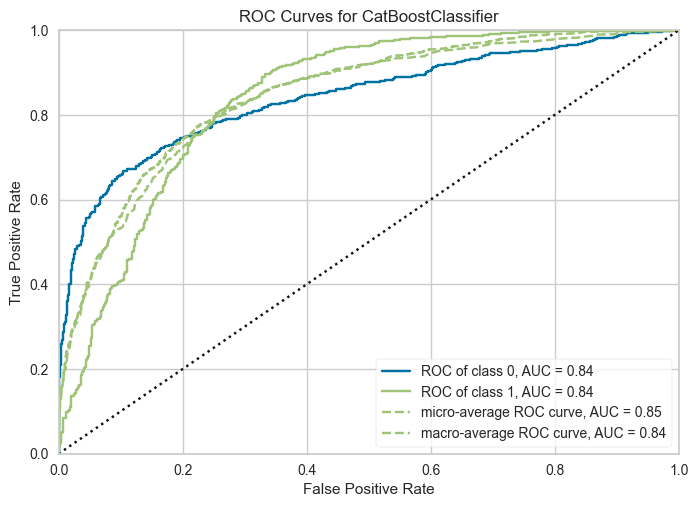

In [85]:
exp1.plot_model(catboost, plot = 'auc')

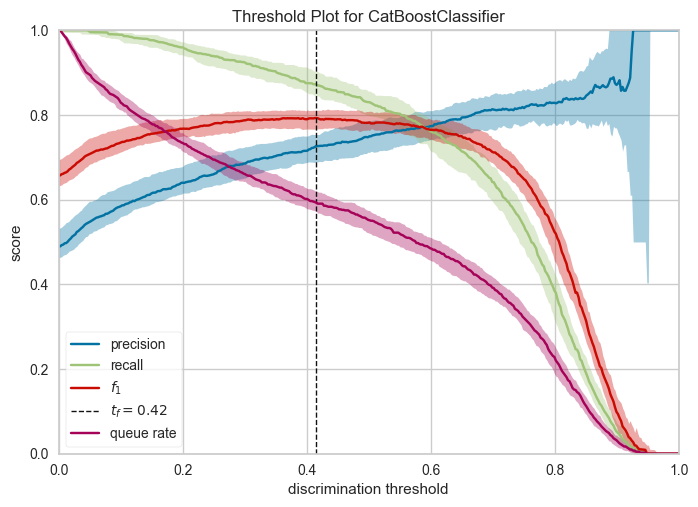

In [86]:
exp1.plot_model(catboost, plot = 'threshold')

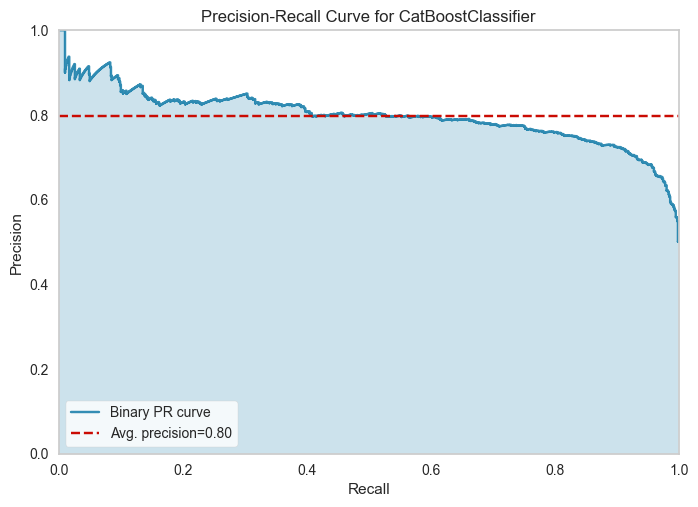

In [87]:
exp1.plot_model(catboost, plot = 'pr')

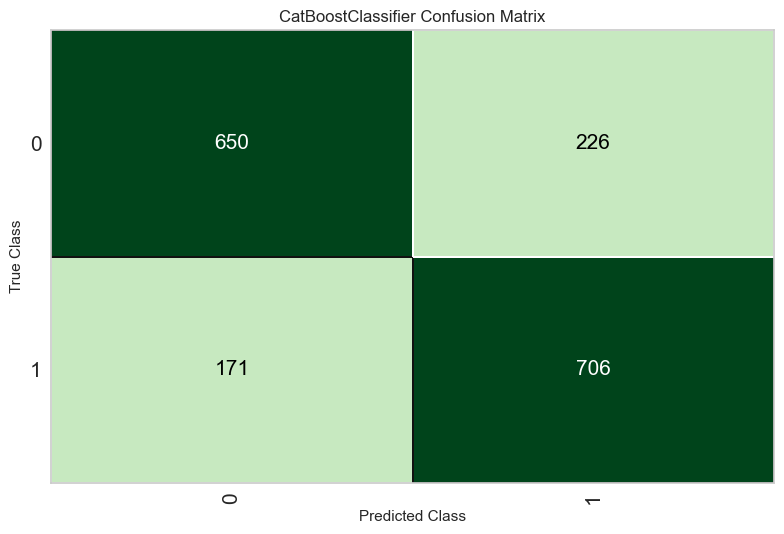

In [88]:
exp1.plot_model(catboost, plot = 'confusion_matrix')

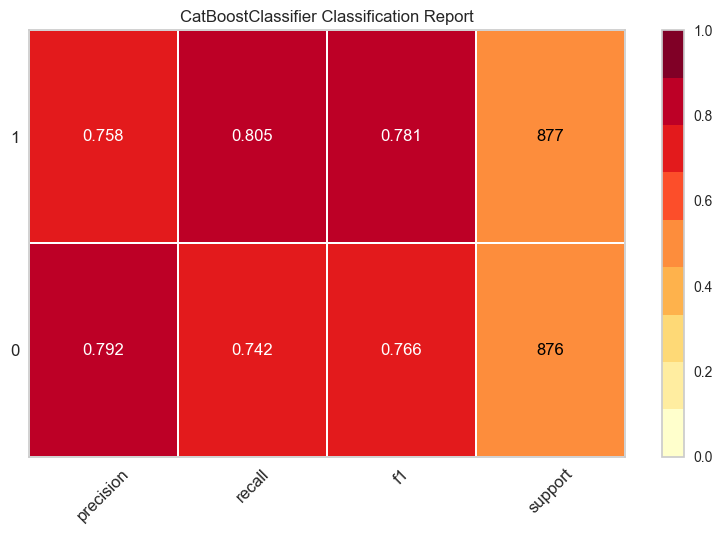

In [89]:
exp1.plot_model(catboost, plot = 'class_report')

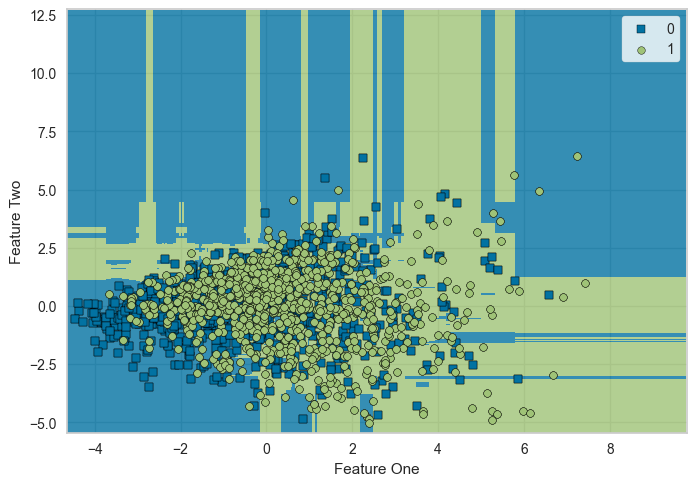

In [90]:
exp1.plot_model(catboost, plot = 'boundary')

### Interpretação do Gráfico de Regiões de Decisão

Este gráfico mostra as regiões de decisão geradas pelo modelo CatBoost em relação a duas características, denominadas "Feature One" e "Feature Two". Aqui estão algumas interpretações chave:

#### Regiões de Decisão:
- O gráfico é dividido em áreas coloridas, onde cada cor representa uma classe prevista pelo modelo. No caso, as regiões em verde representam a classe `1` e as regiões em azul representam a classe `0`.
- As áreas com cor sólida indicam onde o modelo está confiante em sua previsão, enquanto as áreas de transição (bordas entre as cores) mostram onde o modelo pode estar menos confiante.

#### Distribuição dos Pontos de Dados:
- Os pontos no gráfico representam os dados reais que foram classificados pelo modelo. Os círculos representam instâncias da classe `1`, e os quadrados representam instâncias da classe `0`.
- Os pontos que aparecem dentro de uma região da mesma cor sugerem que o modelo fez uma previsão correta para esses pontos.
- Por outro lado, pontos de uma classe (por exemplo, quadrados) que aparecem em regiões da cor correspondente à outra classe (por exemplo, verde) indicam erros de classificação.

#### Análise dos Erros:
- Em algumas áreas, especialmente nas bordas entre diferentes regiões, você pode notar sobreposições entre pontos das duas classes. Isso indica que o modelo encontra dificuldades em separar essas instâncias, sugerindo que essas áreas do espaço de características são mais ambíguas.

#### Complexidade do Modelo:
- A presença de múltiplas pequenas regiões coloridas, especialmente em azul, pode indicar que o modelo está criando regras de decisão mais complexas para tentar capturar nuances nos dados, o que pode levar a um possível overfitting em alguns casos.

Em resumo, o gráfico ajuda a visualizar como o modelo CatBoost está separando as classes `0` e `1` no espaço definido pelas duas características. Ele mostra onde o modelo é mais confiante e onde as previsões podem ser menos seguras, além de ajudar a identificar potenciais erros de classificação.

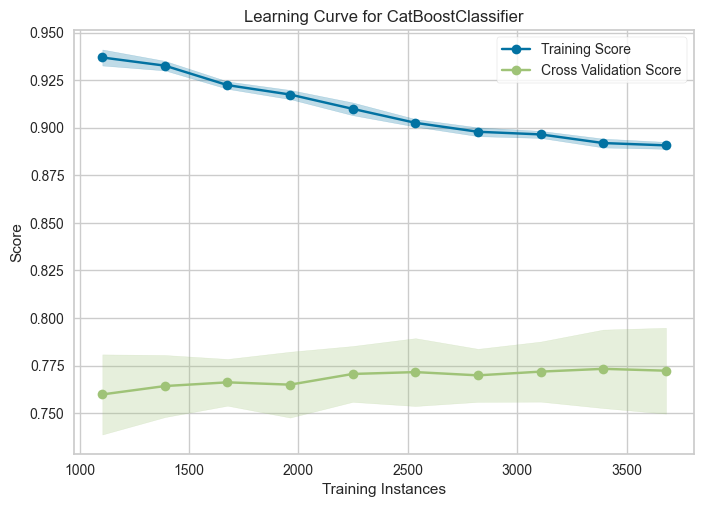

In [91]:
exp1.plot_model(catboost, plot = 'learning')

### Curva de Aprendizado para o Modelo CatBoostClassifier

Este gráfico é uma curva de aprendizado para o modelo `CatBoostClassifier`. Ele mostra como o desempenho do modelo evolui à medida que o número de instâncias de treinamento aumenta. Aqui está uma interpretação detalhada:

#### Desempenho no Conjunto de Treinamento:
- **Linha Azul (Training Score)**: A linha azul representa a pontuação do modelo no conjunto de treinamento. No início, com menos instâncias de treinamento, o modelo tem uma alta pontuação (próxima de 0,95), o que pode indicar que o modelo está ajustando bem os dados de treinamento iniciais.
- **Tendência de Queda**: À medida que o número de instâncias de treinamento aumenta, a pontuação no conjunto de treinamento começa a cair gradualmente, estabilizando-se em torno de 0,88. Isso é esperado, pois o modelo se torna menos capaz de memorizar os dados à medida que o conjunto de treinamento aumenta, forçando-o a generalizar melhor.

#### Desempenho na Validação Cruzada:
- **Linha Verde (Cross Validation Score)**: A linha verde representa a pontuação do modelo em validação cruzada, que é uma estimativa mais robusta de como o modelo vai se comportar em dados não vistos. Inicialmente, a pontuação está em torno de 0,75 e apresenta uma ligeira tendência de crescimento conforme o número de instâncias de treinamento aumenta.
- **Área Sombreada**: A área sombreada ao redor da linha verde representa a variabilidade (ou incerteza) na pontuação de validação cruzada. A largura da área sombreada sugere a estabilidade do modelo, e aqui parece que essa incerteza é relativamente baixa.

#### Análise do Desempenho:
- **Diferença Entre as Linhas**: Existe uma diferença notável entre a pontuação do treinamento (azul) e a pontuação de validação (verde). Essa diferença sugere que o modelo pode estar sofrendo de overfitting, ou seja, está se ajustando muito bem aos dados de treinamento, mas não consegue generalizar bem para novos dados.
- **Estabilidade na Validação Cruzada**: A pontuação de validação cruzada se estabiliza com o aumento do número de instâncias de treinamento, o que é um sinal positivo. No entanto, a pontuação relativamente baixa em comparação com a pontuação de treinamento indica que há espaço para melhorar a generalização do modelo.

#### Conclusão:
O gráfico sugere que, embora o modelo `CatBoostClassifier` esteja ajustando bem os dados de treinamento, ele ainda não generaliza tão bem quanto poderia para novos dados, possivelmente devido ao overfitting. A estabilidade na pontuação de validação cruzada é um bom sinal, mas o desempenho geral poderia ser melhorado com técnicas de regularização ou aumentando a diversidade dos dados de treinamento.

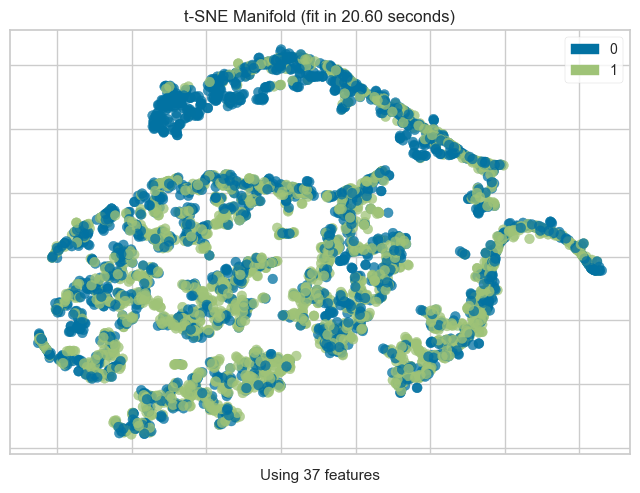

In [92]:
exp1.plot_model(catboost, plot = 'manifold')

A separação observada no gráfico de t-SNE parece ser razoavelmente boa, mas há alguns pontos a considerar:

### Clusters Relativamente Definidos:

Existem áreas no gráfico onde os pontos das classes 0 e 1 estão bem separados, formando clusters distintos. Isso indica que o modelo conseguiu capturar padrões que diferenciam essas classes em várias partes do espaço de características.

### Sobreposição Entre Classes:

No entanto, há uma certa sobreposição entre os pontos verdes (classe 1) e azuis (classe 0). Essa sobreposição sugere que, para alguns exemplos, o modelo pode ter dificuldade em distinguir entre as classes, resultando em possíveis erros de classificação (falsos positivos ou falsos negativos).

### Proporção de Sobreposição:

A quantidade de sobreposição observada não é excessiva, mas ela existe. Em termos práticos, a presença de sobreposição pode ser aceitável dependendo da aplicação e dos requisitos de performance do modelo. Por exemplo, se a sobreposição ocorrer em uma pequena proporção dos dados, e se a taxa de erro resultante for baixa, então o modelo pode ser considerado bom para o propósito pretendido.

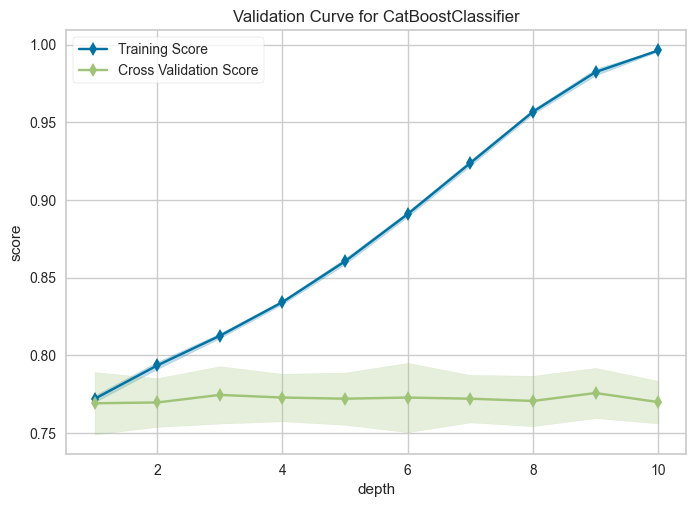

In [93]:
exp1.plot_model(catboost, plot = 'vc')

## Análise do Gráfico de Validação para CatBoostClassifier

### Análise
- **Pontuação de Treinamento (Linha Azul)**:
  - Aumenta consistentemente com a profundidade.
  - Indica que o modelo está aprendendo mais detalhes dos dados de treinamento.

- **Pontuação de Validação Cruzada (Linha Verde)**:
  - Aumenta inicialmente, mas se estabiliza em profundidades maiores.
  - Indica que o modelo está melhorando seu desempenho em dados novos, mas com alguma variabilidade.

### Interpretação
- **Linha Azul**: Mostra o desempenho nos dados de treinamento. Aumenta com a profundidade, indicando melhor ajuste aos dados de treinamento.
- **Linha Verde**: Mostra o desempenho nos dados de validação cruzada. Estabiliza em profundidades maiores, sugerindo que o modelo já capturou os padrões principais e aumentar a complexidade não traz melhorias significativas.

### Conclusão
- O modelo está se saindo bem, com ambas as pontuações aumentando sem sinais claros de overfitting.
- A linha verde estável indica que o modelo atingiu um ponto de saturação de aprendizado.

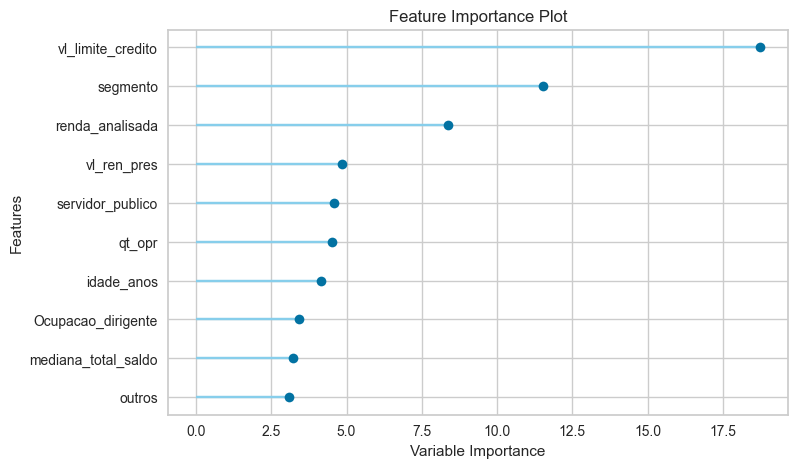

In [94]:
exp1.plot_model(catboost, plot = 'feature')

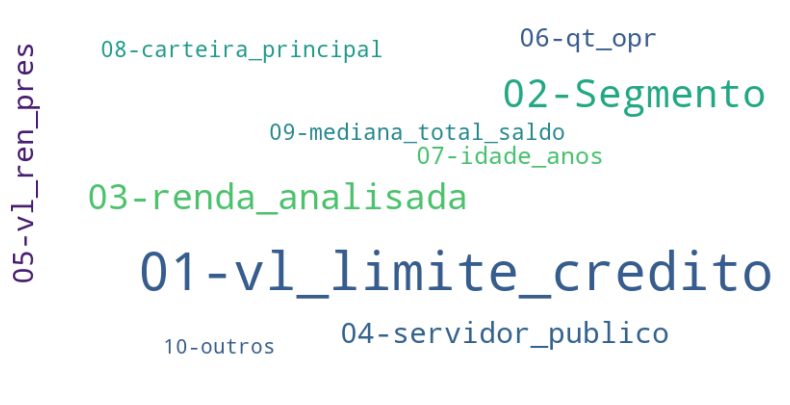

In [95]:
# Dados das variáveis e seus pesos
word_freq = {
    '01-vl_limite_credito': 20,
    '02-Segmento': 10,
    '03-renda_analisada': 8,
    '04-servidor_publico': 5,
    '05-vl_ren_pres': 5,
    '06-qt_opr': 4,
    '07-idade_anos': 3.5,
    '08-carteira_principal': 3,
    '09-mediana_total_saldo': 3,
    '10-outros': 2.5
}

# Cria a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plota a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove os eixos
plt.show()

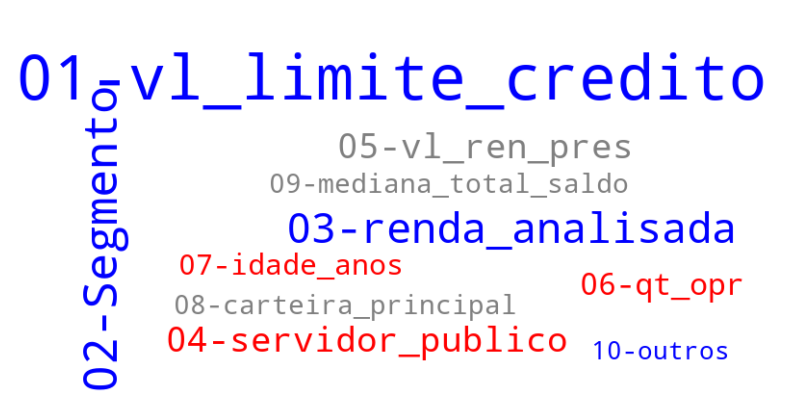

In [96]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# Dados das variáveis e seus pesos
word_freq = {
    '01-vl_limite_credito': 20,
    '02-Segmento': 10,
    '03-renda_analisada': 8,
    '04-servidor_publico': 5,
    '05-vl_ren_pres': 5,
    '06-qt_opr': 4,
    '07-idade_anos': 3.5,
    '08-carteira_principal': 3,
    '09-mediana_total_saldo': 3,
    '10-outros': 2.5
}

# Define a função para colorir as palavras
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word in ['01-vl_limite_credito', '02-Segmento', '03-renda_analisada','10-outros']:
        return 'blue'  # Cores para palavras 1, 2, 3
    elif word in ['04-servidor_publico', '06-qt_opr', '07-idade_anos']:
        return 'red'   # Cores para palavras 7, 8, 9
    else:
        return 'grey'  # Cores neutras para outras palavras 05-vl_ren_pres 08-carteira_principal 09-mediana_total_saldo

# Cria a nuvem de palavras com cores personalizadas
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    min_font_size=10, 
    max_font_size=100,
    color_func=color_func  # Aplica a função de cores
).generate_from_frequencies(word_freq)

# Plota a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove os eixos
plt.show()

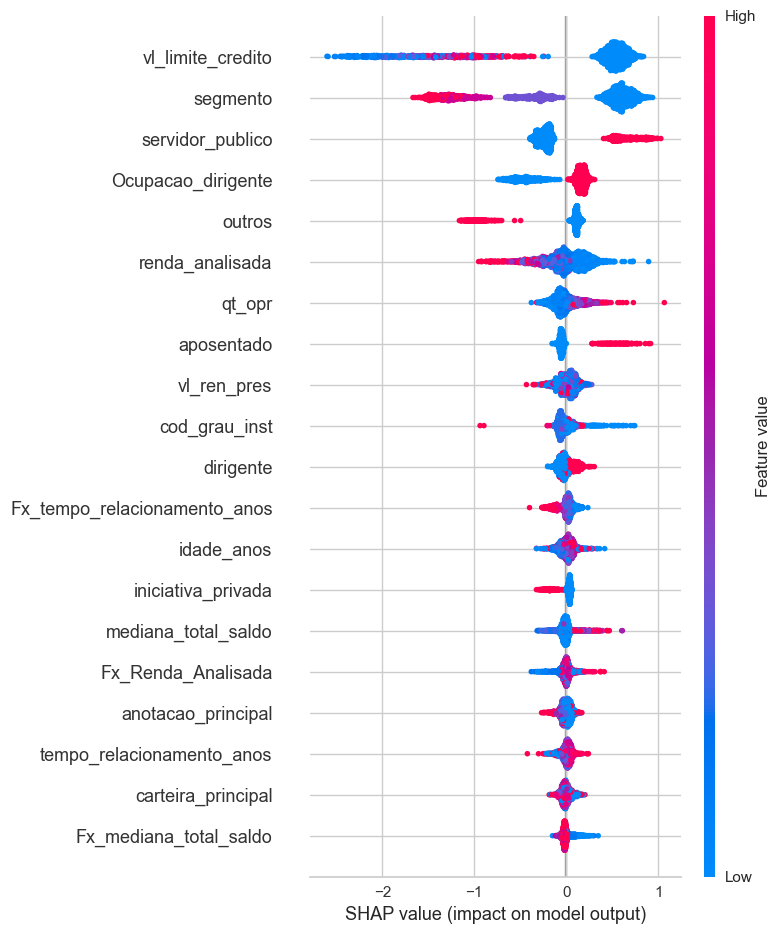

In [97]:
exp1.interpret_model(catboost)

## O que o SHAP Faz?

O SHAP (SHapley Additive exPlanations) é uma técnica para interpretar modelos de machine learning. Ele ajuda a entender como cada característica contribui para a previsão do modelo para uma instância específica. Utiliza visualizações para mostrar a importância e o impacto das características.

## Exemplos Específicos com Cores Vermelho e Azul

### 1. `vl_limite_credito`

- **Descrição**: O gráfico SHAP mostra o impacto da variável `vl_limite_credito` na previsão.
- **Interpretação**:
  - **<span style="color:red">Vermelho</span>**: Valores mais altos de `vl_limite_credito` são associados a um impacto positivo na previsão.
  - **<span style="color:blue">Azul</span>**: Valores mais baixos estão associados a um impacto negativo na previsão.
- **Exemplo**:
  - Se a variável `vl_limite_credito` é `0.5` e está representada em <span style="color:red">vermelho</span>, isso indica que um limite de crédito mais alto tende a aumentar a previsão.
  - Se há uma bola oval <span style="color:blue">azul</span> no valor `-0.5`, isso indica que um limite de crédito mais baixo tem um impacto negativo na previsão.

### 2. `servidor_publico`

- **Descrição**: A variável `servidor_publico` é binária, com valores 0 ou 1, onde 0 significa "não" e 1 significa "sim".
- **Interpretação**:
  - **<span style="color:red">Vermelho</span>**: A cor <span style="color:red">vermelha</span> indica que a presença do valor 1 (sim) tem um impacto positivo na previsão.
  - **<span style="color:blue">Azul</span>**: A cor <span style="color:blue">azul</span> indica que a ausência do valor 1 (não) tem um impacto negativo na previsão.
- **Exemplo**:
  - Se `servidor_publico` é `1` e está em uma área acima de `0.5`, a cor <span style="color:red">vermelha</span> indica que a presença de "servidor público" tem um impacto positivo na previsão.
  - Se `servidor_publico` é `0` e está entre `-0.5` e `0`, a cor <span style="color:blue">azul</span> indica que a ausência de "servidor público" tem um impacto negativo na previsão.

### 3. `renda_analisada`

- **Descrição**: A variável `renda_analisada` é representada no gráfico SHAP.
- **Interpretação**:
  - **<span style="color:blue">Azul</span>**: Valores abaixo de `-0.25` até `0.75` têm um impacto negativo na previsão.
  - **<span style="color:red">Vermelho</span>**: Valores acima de `0.75` têm um impacto positivo na previsão.
- **Exemplo**:
  - Se a variável `renda_analisada` é menor que `-0.25` e está <span style="color:blue">azul</span>, isso indica um impacto negativo na previsão.
  - Se a variável está entre `-0.25` e `0.75`, ela ainda está <span style="color:blue">azul</span>, indicando um impacto negativo, mas menos intenso.
  - Se a variável `renda_analisada` é maior que `0.75` e aparece <span style="color:red">vermelha</span>, isso indica um impacto positivo na previsão.

## Resumo

No gráfico SHAP:
- **<span style="color:red">Vermelho</span>** indica um impacto positivo da variável na previsão.
- **<span style="color:blue">Azul</span>** indica um impacto negativo da variável na previsão.

Essas cores ajudam a visualizar como diferentes valores de cada característica, como `vl_limite_credito`, `servidor_publico`, e `renda_analisada`, influenciam a decisão final do modelo.

In [98]:
# Obter previsões no conjunto de treino balanceado
y_train_pred = exp1.predict_model(catboost, data=df_train_balanced)

In [99]:
exp1.evaluate_model(catboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

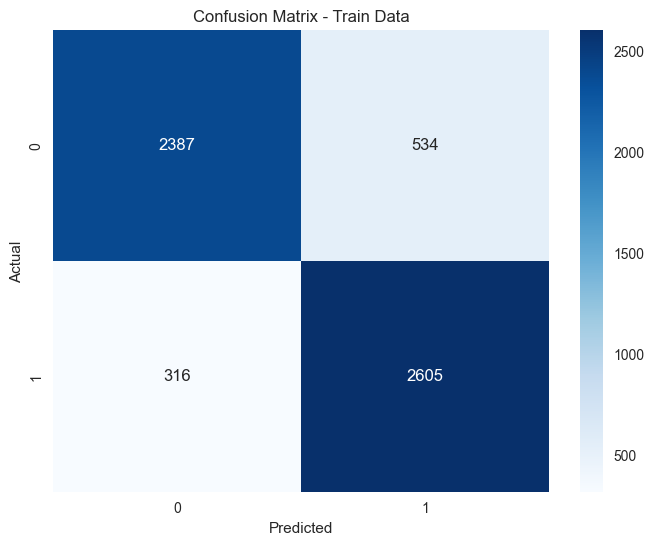

In [100]:
# Gerar a matriz de confusão para o conjunto de treino balanceado
cm_train = confusion_matrix(df_train_balanced['TARGET'], y_train_pred['prediction_label'])

# Plotar a matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=df_train_balanced['TARGET'].unique(), 
            yticklabels=df_train_balanced['TARGET'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Train Data')
plt.show()

In [101]:
# Obter previsões no conjunto de treino
y_valid_pred = exp1.predict_model(catboost, data=df_train_balanced)

# Gerar o relatório de classificação para o conjunto de validação
class_report_valid = classification_report(df_train_balanced['TARGET'], y_valid_pred['prediction_label'])

print("Classification Report - Validation Data:")
print(class_report_valid)

Classification Report - Validation Data:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2921
           1       0.83      0.89      0.86      2921

    accuracy                           0.85      5842
   macro avg       0.86      0.85      0.85      5842
weighted avg       0.86      0.85      0.85      5842



In [102]:
# Obter previsões no conjunto de validação
y_valid_pred = exp1.predict_model(catboost, data=df_valid)

In [103]:
y_valid_pred

renda_analisada  recebe_salario  total_investimento  carteira_principal      vlr_bens  tempo_relacionamento_anos  idade_anos  cod_grau_inst  anotacao_externa  anotacao_interna  ...  Fx_total_investimento  Fx_vlr_bens  Fx_tempo_relacionamento_anos  Fx_idade_anos  Fx_qt_opr  Fx_mediana_total_saldo  Fx_vl_ren_pres  TARGET  prediction_label  prediction_score
3873       5200.000000               0                 0.0                  24       0.00000                          4        22.0              7                 0                 1  ...                      5            5                             0              0          0                       7               0       0                 1            0.8804
1964      28457.330078               1                 0.0                   0  174308.00000                         35        65.0              3                 1                 2  ...                      5            6                             4              6          1                       0               1       0                 0            0.6602
2618      45481.179688               0                 0.0                   0  135958.40625                         28        77.0              3                 0                 1  ...                      5            6                             4              7          6                       7               6       1                 1            0.5148
4430      12652.200195               0                 0.0                  26       0.00000                          1        39.0              3                 0                 1  ...                      5            5                             9              2          0                       0               0       1                 0            0.8710
6091      50629.640625               0                 0.0                  31       0.00000                          6        35.0              3                 1                 1  ...                      5            5                             7              2          8                       7               3       1                 1            0.6843
...                ...             ...                 ...                 ...           ...                        ...         ...            ...               ...               ...  ...                    ...          ...                           ...            ...        ...                     ...             ...     ...               ...               ...
6604      48232.160156               0                 0.0                   0   23316.00000                         15        59.0              2                 2                 1  ...                      5            7                             1              4          1                       7               5       0                 1            0.8144
3015      13902.200195               1                 0.0                  16       0.00000                          3        44.0              2                 0                 1  ...                      5            5                             0              2          6                       1               3       1                 1            0.7383
16727     33370.308594               0                 0.0                  18   35699.00000                         30        56.0              3                 0                 1  ...                      5            9                             4              4          8                       7               1       1                 1            0.9024
5618      10041.879883               0                 0.0                  15       0.00000                          0        51.0              3                 1                 1  ...                      5            5                             9              3          0                       7               1       1                 0            0.7756
183

In [104]:
# Calcular a contagem e a proporção das classes
count_freq = df_valid['TARGET'].value_counts()
proportion_freq = df_valid['TARGET'].value_counts(normalize=True)

# Criar um DataFrame para exibir os resultados
freq_df = pd.DataFrame({
    'Contagem': count_freq,
    'Proporção': proportion_freq
})
# Exibir a tabela no Jupyter Notebook
print("Distribuição das classes da amostra validação:")
display(freq_df)

Distribuição das classes da amostra validação:


Contagem  Proporção
TARGET                     
1           3319   0.726099
0           1252   0.273901

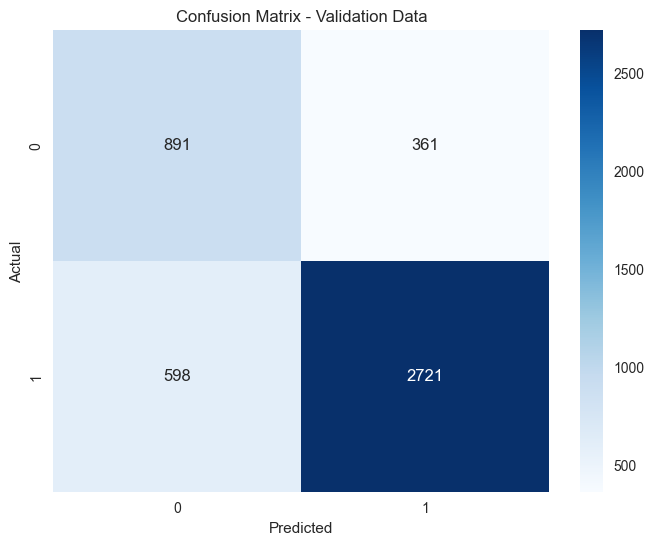

Classification Report - Validation Data:
              precision    recall  f1-score   support

           0       0.60      0.71      0.65      1252
           1       0.88      0.82      0.85      3319

    accuracy                           0.79      4571
   macro avg       0.74      0.77      0.75      4571
weighted avg       0.80      0.79      0.80      4571



In [105]:
# Gerar a matriz de confusão para o conjunto de validação balanceado
cm_valid = confusion_matrix(df_valid['TARGET'], y_valid_pred['prediction_label'], labels=[0, 1])

# Plotar a matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(cm_valid, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[0, 1], 
            yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# Gerar o relatório de classificação para o conjunto de validação
class_report_valid = classification_report(df_valid['TARGET'], y_valid_pred['prediction_label'], labels=[0, 1])

print("Classification Report - Validation Data:")
print(class_report_valid)

## Save Model

Esta função salva o pipeline de transformação e o objeto do modelo treinado no diretório de trabalho atual como um arquivo pickle para uso posterior

In [106]:
exp1.save_model(catboost, 'modelo_valid_renda_v02')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('placeholder', None),
                 ('trained_model',
                  <catboost.core.CatBoostClassifier object at 0x000002169D613D90>)],
          verbose=False),
 'modelo_valid_renda_v02.pkl')

In [107]:
from pycaret.classification import load_model, predict_model

# Carregar o modelo salvo
classificar_new = load_model('modelo_valid_renda_v02')

# Suponha que Z_valid_separado seja o DataFrame com novos dados
# Fazer previsões com o modelo carregado
previsoes = predict_model(classificar_new, data=df_separado25)


Transformation Pipeline and Model Successfully Loaded


In [108]:
previsoes

cd_cli           cpf                ts_protocolo  y  renda_analisada  recebe_salario  total_investimento  carteira_principal    vlr_bens  tempo_relacionamento_anos  ...  Fx_vlr_bens  Fx_tempo_relacionamento_anos  Fx_idade_anos  Fx_qt_opr   Fx_vl_limite_credito  Fx_mediana_total_saldo  Fx_vl_ren_pres  TARGET  prediction_label  prediction_score
12182  500575428  3.453874e+10  2024-07-23 09:37:45.498005  1     22584.669922               1                 0.0                   0        0.00                         38  ...            5                             5              5          9                      0                       3               4       1                 1            0.6592
19734   33091308  2.891684e+09  2024-07-16 09:23:19.410094  1     16257.209961               0                 0.0                  24        0.00                          5  ...            5                             0              1          6                      0                       1               0       1                 1            0.7533
13335  303847426  1.786108e+10  2024-07-22 11:16:08.993183  1      9195.860352               0                 0.0                  18        0.00                         28  ...            5                             4              6          0                      0                       7               1       1                 1            0.8583
18752  203990876  4.803431e+09  2024-08-09 11:57:21.958321  1    174809.687500               0                 0.0                   0  3474504.25                         30  ...            4                             4              5          5                      0                       4               5       1                 1            0.8247
14188  501410209  6.753108e+10  2024-07-29 10:30:52.251911  1     15274.349609               1                 0.0                  16        0.00                         33  ...            5                             4              4          9                      0                       3               1       1                 1            0.8035
...          ...           ...                         ... ..              ...             ...                 ...                 ...         ...                        ...  ...          ...                           ...            ...        ...                    ...                     ...             ...     ...               ...               ...
11124  502570816  5.560486e+10  2024-07-22 14:19:00.184385  1     31882.259766               0                 0.0                   0        0.00                         31  ...            5                             4              3          6  25.000,01 - 50.000,00                       7               1       1                 0            0.8791
10232   30502847  6.966395e+10  2024-07-25 14:12:31.530011  0     29755.300781               0                 0.0                  16        0.00                         19  ...            5                             2              3          8                      0                       7               4       0                 0            0.8965
12991  602604844  8.347641e+10  2024-08-01 15:33:31.633285  1      2349.000000               0                 0.0                  16    78300.00                         32  ...            3                             4              3         11                      0                       5               1       1                 1            0.7582
17083  932999116  1.129113e+10  2024-08-05 11:50:40.171049  1     19013.130859               0                 0.0                  16        0.00                         13  ...            5                             1              6          0                      0                       7               1       1                 1            0.7083
3983   209694173  2.796249e+10  2024-07-24 12:15:49.145973  1     16556.050781               0           

In [109]:
Z_valid_separado=previsoes

In [110]:
# Calcular a contagem e a proporção das classes
count_freq = Z_valid_separado['TARGET'].value_counts()
proportion_freq = Z_valid_separado['TARGET'].value_counts(normalize=True)

# Criar um DataFrame para exibir os resultados
freq_df = pd.DataFrame({
    'Contagem': count_freq,
    'Proporção': proportion_freq
})
# Exibir a tabela no Jupyter Notebook
print("Distribuição das classes da amostra Z_valid_separado:")
display(freq_df)

Distribuição das classes da amostra Z_valid_separado:


Contagem  Proporção
TARGET                     
1           3665   0.721599
0           1414   0.278401

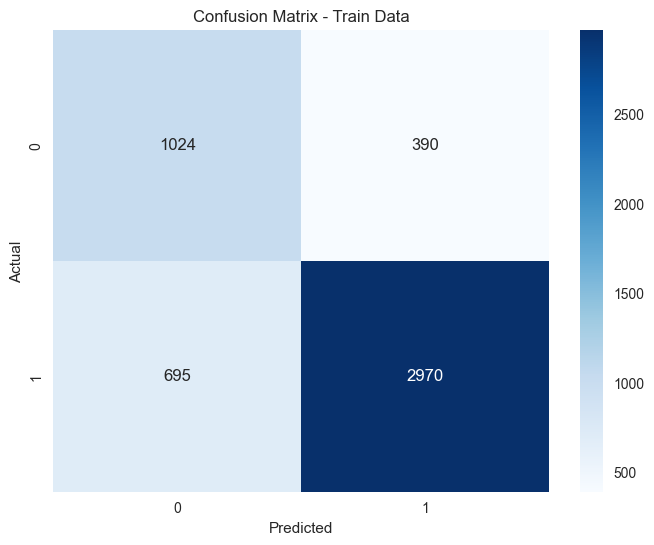

In [111]:
# Gerar a matriz de confusão para o conjunto de treino balanceado
cm_separado = confusion_matrix(df_separado25['TARGET'], Z_valid_separado['prediction_label'], labels=[0, 1])

# Plotar a matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(cm_separado, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[0, 1], 
            yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Train Data')
plt.show()

### Essas métricas ajudam a entender se o algoritmo está tomando as decisões corretas ao prever se um cliente deve ou não ter sua renda liberada.
- **1. Acurácia:** Mede o quanto o sistema acerta no geral, tanto para liberações quanto para não liberações.
- **2. Precisão:** Entre as vezes que o sistema previu que a renda seria liberada, quantas estavam corretas.
- **3. Recall:** Entre todas as vezes que a renda foi realmente liberada, quantas foram corretamente previstas pelo sistema.
- **4. F1-Score:** Um equilíbrio entre precisão e recall, útil para ver o desempenho geral do sistema.



### 1. Acurácia
**Importante quando:** As classes estão balanceadas (ou seja, há uma quantidade similar de clientes com renda liberada e não liberada). Ela dá uma visão geral do desempenho, mas pode ser enganosa se houver um desequilíbrio significativo entre as classes.

### 2. Precisão
**Importante quando:** Você quer minimizar os falsos positivos. No seu caso, isso significa que é crucial evitar liberar a renda para clientes que não deveriam recebê-la. Isso é vital se a liberação errônea de renda resultar em riscos financeiros elevados para a empresa.

### 3. Recall
**Importante quando:** Você quer minimizar os falsos negativos. Aqui, significa que você quer garantir que quase todos os clientes que deveriam ter a renda liberada realmente a recebam. Isso é essencial se a prioridade for evitar perder bons clientes que foram negados injustamente.

### 4. F1-Score
**Importante quando:** Há uma necessidade de equilíbrio entre precisão e recall. O F1-Score é útil quando você quer um bom desempenho geral sem priorizar excessivamente um tipo de erro sobre o outro. É particularmente relevante quando as classes são desbalanceadas e ambos os erros (falsos positivos e falsos negativos) têm consequências significativas.


Métricas Derivadas da Matriz de Confusão:
Acurácia: (VP + VN) / Total
Precisão: VP / (VP + FP)
Recall (Sensibilidade): VP / (VP + FN)
F1-Score: 2 * (Precisão * Recall) / (Precisão + Recall)

### Qual escolher?
- **Se a prioridade é evitar perdas financeiras grandes:** **Precisão** pode ser mais importante, pois você quer garantir que poucas pessoas recebam uma liberação de renda quando não deveriam.
- **Se a prioridade é não perder clientes bons:** **Recall** seria mais relevante, já que você quer maximizar a aprovação dos clientes que realmente merecem ter a renda liberada.
- **Se você precisa de um bom equilíbrio entre os dois:** **F1-Score** é o mais indicado, especialmente se há um trade-off importante entre precisão e recall.

Essas métricas ajudam a entender se o algoritmo está tomando as decisões corretas ao prever se um cliente deve ou não ter sua renda liberada.

No final, a métrica mais importante depende dos objetivos do negócio e das consequências associadas a erros de previsão no contexto específico em que o modelo será aplicado.

In [112]:
Z_valid_separado

cd_cli           cpf                ts_protocolo  y  renda_analisada  recebe_salario  total_investimento  carteira_principal    vlr_bens  tempo_relacionamento_anos  ...  Fx_vlr_bens  Fx_tempo_relacionamento_anos  Fx_idade_anos  Fx_qt_opr   Fx_vl_limite_credito  Fx_mediana_total_saldo  Fx_vl_ren_pres  TARGET  prediction_label  prediction_score
12182  500575428  3.453874e+10  2024-07-23 09:37:45.498005  1     22584.669922               1                 0.0                   0        0.00                         38  ...            5                             5              5          9                      0                       3               4       1                 1            0.6592
19734   33091308  2.891684e+09  2024-07-16 09:23:19.410094  1     16257.209961               0                 0.0                  24        0.00                          5  ...            5                             0              1          6                      0                       1               0       1                 1            0.7533
13335  303847426  1.786108e+10  2024-07-22 11:16:08.993183  1      9195.860352               0                 0.0                  18        0.00                         28  ...            5                             4              6          0                      0                       7               1       1                 1            0.8583
18752  203990876  4.803431e+09  2024-08-09 11:57:21.958321  1    174809.687500               0                 0.0                   0  3474504.25                         30  ...            4                             4              5          5                      0                       4               5       1                 1            0.8247
14188  501410209  6.753108e+10  2024-07-29 10:30:52.251911  1     15274.349609               1                 0.0                  16        0.00                         33  ...            5                             4              4          9                      0                       3               1       1                 1            0.8035
...          ...           ...                         ... ..              ...             ...                 ...                 ...         ...                        ...  ...          ...                           ...            ...        ...                    ...                     ...             ...     ...               ...               ...
11124  502570816  5.560486e+10  2024-07-22 14:19:00.184385  1     31882.259766               0                 0.0                   0        0.00                         31  ...            5                             4              3          6  25.000,01 - 50.000,00                       7               1       1                 0            0.8791
10232   30502847  6.966395e+10  2024-07-25 14:12:31.530011  0     29755.300781               0                 0.0                  16        0.00                         19  ...            5                             2              3          8                      0                       7               4       0                 0            0.8965
12991  602604844  8.347641e+10  2024-08-01 15:33:31.633285  1      2349.000000               0                 0.0                  16    78300.00                         32  ...            3                             4              3         11                      0                       5               1       1                 1            0.7582
17083  932999116  1.129113e+10  2024-08-05 11:50:40.171049  1     19013.130859               0                 0.0                  16        0.00                         13  ...            5                             1              6          0                      0                       7               1       1                 1            0.7083
3983   209694173  2.796249e+10  2024-07-24 12:15:49.145973  1     16556.050781               0           

In [113]:
Z_valid_separado['Predicted_final'] = Z_valid_separado.apply(
    lambda row: 1 - row['prediction_score'] if row['prediction_label'] == 0 else row['prediction_score'],
    axis=1
)


In [114]:
Z_valid_separado

cd_cli           cpf                ts_protocolo  y  renda_analisada  recebe_salario  total_investimento  carteira_principal    vlr_bens  tempo_relacionamento_anos  ...  Fx_tempo_relacionamento_anos  Fx_idade_anos  Fx_qt_opr   Fx_vl_limite_credito  Fx_mediana_total_saldo  Fx_vl_ren_pres  TARGET  prediction_label  prediction_score  Predicted_final
12182  500575428  3.453874e+10  2024-07-23 09:37:45.498005  1     22584.669922               1                 0.0                   0        0.00                         38  ...                             5              5          9                      0                       3               4       1                 1            0.6592           0.6592
19734   33091308  2.891684e+09  2024-07-16 09:23:19.410094  1     16257.209961               0                 0.0                  24        0.00                          5  ...                             0              1          6                      0                       1               0       1                 1            0.7533           0.7533
13335  303847426  1.786108e+10  2024-07-22 11:16:08.993183  1      9195.860352               0                 0.0                  18        0.00                         28  ...                             4              6          0                      0                       7               1       1                 1            0.8583           0.8583
18752  203990876  4.803431e+09  2024-08-09 11:57:21.958321  1    174809.687500               0                 0.0                   0  3474504.25                         30  ...                             4              5          5                      0                       4               5       1                 1            0.8247           0.8247
14188  501410209  6.753108e+10  2024-07-29 10:30:52.251911  1     15274.349609               1                 0.0                  16        0.00                         33  ...                             4              4          9                      0                       3               1       1                 1            0.8035           0.8035
...          ...           ...                         ... ..              ...             ...                 ...                 ...         ...                        ...  ...                           ...            ...        ...                    ...                     ...             ...     ...               ...               ...              ...
11124  502570816  5.560486e+10  2024-07-22 14:19:00.184385  1     31882.259766               0                 0.0                   0        0.00                         31  ...                             4              3          6  25.000,01 - 50.000,00                       7               1       1                 0            0.8791           0.1209
10232   30502847  6.966395e+10  2024-07-25 14:12:31.530011  0     29755.300781               0                 0.0                  16        0.00                         19  ...                             2              3          8                      0                       7               4       0                 0            0.8965           0.1035
12991  602604844  8.347641e+10  2024-08-01 15:33:31.633285  1      2349.000000               0                 0.0                  16    78300.00                         32  ...                             4              3         11                      0                       5               1       1                 1            0.7582           0.7582
17083  932999116  1.129113e+10  2024-08-05 11:50:40.171049  1     19013.130859               0                 0.0                  16        0.00                         13  ...                             1              6          0                      0                       7               1       1                 1            0.7083           0.7083
3983   209694173  2.796249e+10  2024-07-24 12:15:49.145973  1

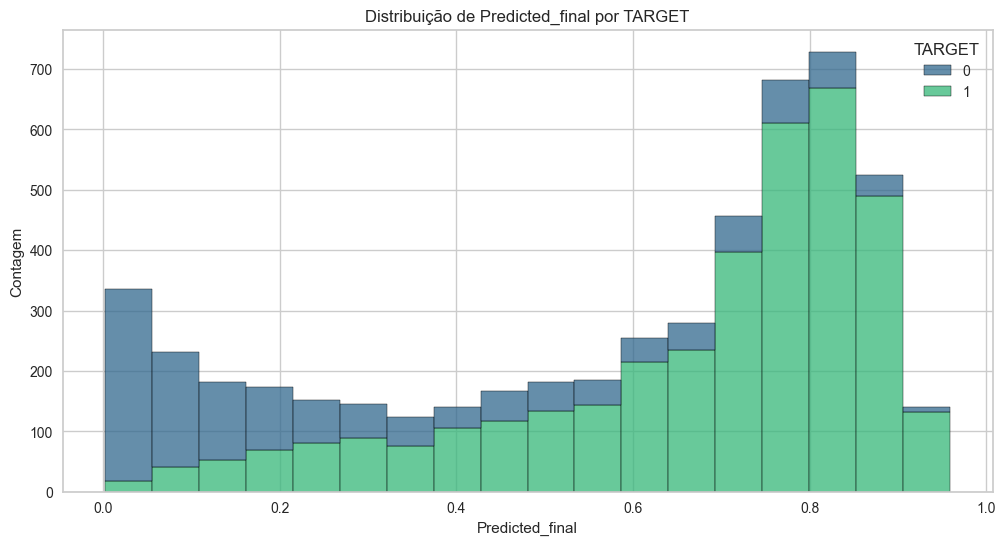

In [115]:
# Histograma de Predicted_final por target
plt.figure(figsize=(12, 6))
sns.histplot(data=Z_valid_separado, x='Predicted_final', hue='TARGET', multiple='stack', palette='viridis')
plt.title('Distribuição de Predicted_final por TARGET')
plt.xlabel('Predicted_final')
plt.ylabel('Contagem')
plt.show()

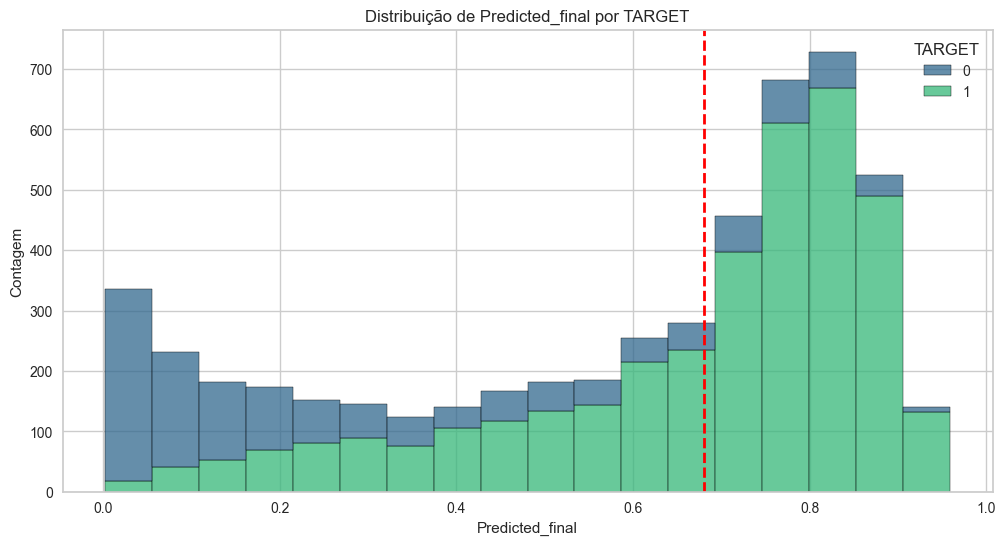

In [116]:
# Criando o histograma com a linha vermelha vertical
plt.figure(figsize=(12, 6))
sns.histplot(data=Z_valid_separado, x='Predicted_final', hue='TARGET', multiple='stack', palette='viridis')
plt.axvline(x=0.68, color='red', linestyle='--', linewidth=2)
plt.title('Distribuição de Predicted_final por TARGET')
plt.xlabel('Predicted_final')
plt.ylabel('Contagem')
plt.show()

In [117]:
# Agrupando os dados por 'TARGET' e calculando as estatísticas para 'Predicted_final'
estatisticas = Z_valid_separado.groupby('TARGET')['Predicted_final'].agg(['min', 'max', 'mean'])

# Exibindo o resultado
display(estatisticas)

min     max      mean
TARGET                          
0       0.0020  0.9332  0.308758
1       0.0126  0.9592  0.678902

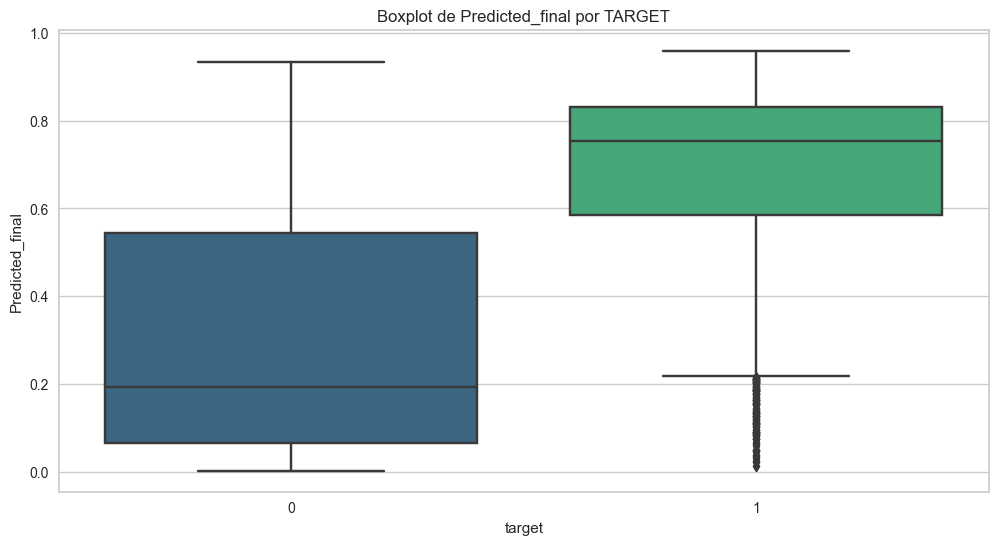

In [118]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=Z_valid_separado, x='TARGET', y='Predicted_final', palette='viridis')
plt.title('Boxplot de Predicted_final por TARGET')
plt.xlabel('target')
plt.ylabel('Predicted_final')
plt.show()

In [119]:

# Dividir 'Predicted_final' em faixas
bins = np.linspace(Z_valid_separado['Predicted_final'].min(), Z_valid_separado['Predicted_final'].max(), num=11)  # 10 faixas

# Dividir os dados
Z_valid_separado['Score_Bins'] = pd.cut(Z_valid_separado['Predicted_final'], bins=bins)

# Calcular a contagem de 1 e 0 em cada faixa
contingency_table = pd.crosstab(Z_valid_separado['Score_Bins'], Z_valid_separado['TARGET'])

# Adicionar colunas para a quantidade acumulada de 1s e 0s
contingency_table['Cumulative_1'] = contingency_table[1].cumsum()
contingency_table['Cumulative_0'] = contingency_table[0].cumsum()

# Calcular a porcentagem acumulada de 1s e 0s
total_1 = contingency_table[1].sum()
total_0 = contingency_table[0].sum()

contingency_table['Percent_1'] = contingency_table['Cumulative_1'] / total_1
contingency_table['Percent_0'] = contingency_table['Cumulative_0'] / total_0

# Encontrar o ponto de corte onde a porcentagem acumulada de 1s atinge pelo menos 60%
# e onde a porcentagem acumulada de 0s é relativamente baixa
target_percent_1 = 0.60
best_cutoff = contingency_table[contingency_table['Percent_1'] >= target_percent_1].iloc[0]

# Exibir a tabela de contingência e o melhor ponto de corte
print(contingency_table)
print(f"Melhor ponto de corte baseado em capturar {target_percent_1*100}% dos 1:")
print(best_cutoff)
print(f"Intervalo correspondente ao melhor ponto de corte: {best_cutoff.name}")

TARGET             0     1  Cumulative_1  Cumulative_0  Percent_1  Percent_0
Score_Bins                                                                  
(0.002, 0.0977]  473    50            50           473   0.013643   0.334749
(0.0977, 0.193]  233    96           146           706   0.039836   0.499646
(0.193, 0.289]   137   151           297           843   0.081037   0.596603
(0.289, 0.385]    80   144           441           923   0.120327   0.653220
(0.385, 0.481]    79   204           645          1002   0.175989   0.709130
(0.481, 0.576]    81   250           895          1083   0.244202   0.766454
(0.576, 0.672]    73   370          1265          1156   0.345157   0.818117
(0.672, 0.768]   117   703          1968          1273   0.536971   0.900920
(0.768, 0.863]   105  1205          3173          1378   0.865757   0.975230
(0.863, 0.959]    35   492          3665          1413   1.000000   1.000000
Melhor ponto de corte baseado em capturar 60.0% dos 1:
TARGET
0             

In [120]:
# Dividir 'Predicted_final' em 10 faixas com aproximadamente a mesma quantidade de observações
Z_valid_separado['FX_Score_padronizado_10'], bins = pd.qcut(Z_valid_separado['Predicted_final'], q=10, labels=False, retbins=True)

# Ajustar para que as faixas comecem de 1
Z_valid_separado['FX_Score_padronizado_10'] = Z_valid_separado['FX_Score_padronizado_10'] + 1

# Definir os intervalos como rótulos
interval_labels = [f'{bins[i]:.4f} - {bins[i+1]:.4f}' for i in range(len(bins) - 1)]

# Mapear os rótulos para a coluna FX_Score_padronizado_10
Z_valid_separado['FX_Score_padronizado_10'] = Z_valid_separado['FX_Score_padronizado_10'].map(lambda x: interval_labels[x - 1])

# Criar a tabela de contingência
contingency_table = pd.crosstab(Z_valid_separado['FX_Score_padronizado_10'], Z_valid_separado['TARGET'])

# Adicionar a linha de totais
contingency_table.loc['Total'] = contingency_table.sum()

# Adicionar a coluna de totais
contingency_table['Total'] = contingency_table.sum(axis=1)

# Calcular os percentuais
contingency_table['% Não Liberada'] = ((contingency_table[0] / contingency_table['Total']) * 100).round(2)
contingency_table['% Liberada'] = ((contingency_table[1] / contingency_table['Total']) * 100).round(2)

# Exibir a tabela de contingência com totais e percentuais
display (contingency_table)

TARGET                      0     1  Total  % Não Liberada  % Liberada
FX_Score_padronizado_10                                               
0.0020 - 0.0941           462    47    509           90.77        9.23
0.0941 - 0.2495           330   177    507           65.09       34.91
0.2495 - 0.4444           175   333    508           34.45       65.55
0.4444 - 0.5911           126   382    508           24.80       75.20
0.5911 - 0.6918            85   423    508           16.73       83.27
0.6918 - 0.7503            69   439    508           13.58       86.42
0.7503 - 0.7906            53   454    507           10.45       89.55
0.7906 - 0.8283            44   464    508            8.66       91.34
0.8283 - 0.8645            38   470    508            7.48       92.52
0.8645 - 0.9592            32   476    508            6.30       93.70
Total                    1414  3665   5079           27.84       72.16